In [1]:
"""
ENHANCED FEATURE ANALYSIS WITH COMPOSITE TARGET VARIABLE - CSV VERSION (FAST)
Target = (Qualified Flag = "Yes") AND (Law Type = "MVA")
"""

# Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from scipy import stats as spstats  # rename to avoid collisions
import warnings
import os
from datetime import datetime
import re
from collections import defaultdict
import logging
import sys

warnings.filterwarnings('ignore')

# === Update this to your CSV path ===
import_file = 'sample_data_synthetic_sensible.csv'

# ----------- FAST CSV READER -----------
def read_csv_fast(
    path,
    *,
    usecols=None,
    dtypes=None,
    parse_dates=None,
    chunksize=None,
    thousands=None,
    decimal=".",
    low_memory=False,
    on_bad_lines="skip",
    # order matters: fast/likely first, then permissive fallbacks
    encodings=("utf-8", "utf-8-sig", "cp1252", "latin1"),
):
    """
    Robust CSV reader:
    1) Try PyArrow only for UTF-8 encodings (fastest).
    2) Fall back to pandas with multiple encodings and tolerant decoding.
    Returns a DataFrame (or an iterator if chunksize is set).
    """
    import pandas as pd

    # kwargs common to pandas engines
    base_pd_kwargs = dict(
        usecols=usecols,
        dtype=dtypes,
        parse_dates=parse_dates,
        chunksize=chunksize,
        thousands=thousands,
        decimal=decimal,
        on_bad_lines=on_bad_lines,
        # tolerate stray bytes instead of crashing (pandas >= 1.5)
        encoding_errors="replace",
        low_memory=low_memory,  # only for pandas C/Python engines
    )

    last_err = None

    for enc in encodings:
        # --- Fast path: PyArrow supports only UTF-8/UTF-8-SIG and not low_memory/on_bad_lines ---
        if enc.lower() in ("utf-8", "utf-8-sig"):
            try:
                arrow_kwargs = dict(
                    usecols=usecols,
                    dtype=dtypes,
                    parse_dates=parse_dates,
                    chunksize=chunksize,
                    thousands=thousands,
                    decimal=decimal,
                )
                # PyArrow does NOT accept: low_memory, on_bad_lines, encoding, encoding_errors
                return pd.read_csv(path, engine="pyarrow", **{k: v for k, v in arrow_kwargs.items() if v is not None})
            except Exception as e:
                last_err = e  # fall through to pandas attempts

        # --- Fallbacks: pandas C engine with explicit encoding ---
        try:
            pd_kwargs = base_pd_kwargs.copy()
            pd_kwargs["encoding"] = enc
            return pd.read_csv(path, **pd_kwargs)
        except Exception as e:
            last_err = e
            continue

    # If nothing worked, raise the last error for visibility
    raise last_err



class EnhancedFeatureAnalyzer:
    """
    Enhanced feature analyzer with aggressive risk detection
    Keeps all data and creates composite target variable
    """

    def __init__(
        self,
        file_path,
        *,
        qual_flag_col_pattern="qualified flag",
        law_type_col_pattern="law type.*broad",
        target_law_type="MVA",
        composite_target_name="MVA_Qualified",
        # CSV-specific performance knobs:
        csv_usecols=None,
        csv_dtypes=None,
        csv_parse_dates=None,
        csv_chunksize=None,
        csv_thousands=None,
        csv_decimal=".",
        csv_low_memory=False,
    ):
        self.file_path = file_path
        self.qual_flag_col_pattern = qual_flag_col_pattern
        self.law_type_col_pattern = law_type_col_pattern
        self.target_law_type = target_law_type
        self.composite_target_name = composite_target_name
        self.df = None
        self.analysis_results = None
        self.logger = self._setup_logger()
        self.row_tracker = RowDropTracker()

        # CSV perf options
        self.csv_usecols = csv_usecols
        self.csv_dtypes = csv_dtypes
        self.csv_parse_dates = csv_parse_dates
        self.csv_chunksize = csv_chunksize
        self.csv_thousands = csv_thousands
        self.csv_decimal = csv_decimal
        self.csv_low_memory = csv_low_memory

        # Configuration
        self.config = FeatureAnalysisConfig()

        # Define pattern-based risk indicators
        self.pii_patterns = {
            "name": ["name", "first", "last", "middle", "surname", "fname", "lname"],
            "contact": ["email", "phone", "mobile", "cell", "fax", "contact"],
            "address": ["address", "street", "city", "state", "zip", "postal", "location"],
            "identifier": ["ssn", "social", "license", "passport", "tax", "ein"],
            "financial": ["account", "bank", "credit", "debit", "routing"],
        }

        self.system_patterns = {
            "id": ["id", "identifier", "number", "code", "key", "uuid", "guid"],
            "reference": ["ref", "reference", "case", "claim", "ticket", "tracking"],
            "timestamp": ["date", "time", "timestamp", "created", "modified", "updated", "logged"],
            "internal": ["internal", "system", "admin", "meta", "audit"],
        }

        self.text_patterns = {
            "notes": ["note", "comment", "description", "memo", "remark", "observation"],
            "narrative": ["narrative", "story", "detail", "explanation", "summary"],
            "user_input": ["input", "entry", "response", "answer", "feedback"],
        }

        self.outcome_patterns = {
            "qualification": ["qual", "eligible", "approved", "accepted", "rejected"],
            "status": ["status", "result", "outcome", "decision", "determination"],
            "fulfillment": ["fulfill", "complete", "achieve", "satisfy", "meet"],
            "retention": ["retain", "kept", "held", "maintain", "preserve"],
        }

    def _setup_logger(self):
        """Setup logging configuration"""
        logger = logging.getLogger("EnhancedFeatureAnalyzer")
        logger.setLevel(logging.INFO)
        logger.handlers = []

        formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

        fh = logging.FileHandler("logs/enhanced_feature_analysis_log.txt", mode="w")
        fh.setLevel(logging.INFO)
        fh.setFormatter(formatter)

        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.INFO)
        ch.setFormatter(formatter)

        logger.addHandler(fh)
        logger.addHandler(ch)

        return logger

    def load_data(self):
        """Load and perform initial data processing (CSV, fast)"""
        self.logger.info("=" * 80)
        self.logger.info("ENHANCED FEATURE ANALYZER - LOADING DATA (CSV)")
        self.logger.info("=" * 80)

        try:
            self.logger.info(f"Loading data from: {self.file_path}")
            # Force CSV (fast). If someone passes .xlsx by accident, raise.
            if str(self.file_path).lower().endswith(".xlsx"):
                raise ValueError(
                    "This refactored version only reads CSV. Please export your Excel to CSV."
                )

            reader = read_csv_fast(
                self.file_path,
                usecols=self.csv_usecols,
                dtypes=self.csv_dtypes,
                parse_dates=self.csv_parse_dates,
                chunksize=self.csv_chunksize,  # if set, we will concatenate
                thousands=self.csv_thousands,
                decimal=self.csv_decimal,
                low_memory=self.csv_low_memory,
            )

            if self.csv_chunksize:
                # Stream all chunks into a single DataFrame for downstream steps
                chunks = []
                for chunk in reader:
                    chunks.append(chunk)
                self.df = pd.concat(chunks, ignore_index=True)
            else:
                self.df = reader  # already a DataFrame

            self.row_tracker.checkpoint("Initial Load", self.df, "Raw data loaded")
            self.logger.info(f"✅ Successfully loaded {len(self.df):,} rows and {len(self.df.columns)} columns")

            # Display basic info
            self.logger.info(f"\nDataset shape: {self.df.shape}")
            self.logger.info(f"Memory usage: {self.df.memory_usage().sum() / 1024**2:.2f} MB")

            # Diagnose data distribution
            self._diagnose_data_distribution()

            # Create composite target variable
            self._create_composite_target()

            # Detect redundant features
            self._detect_and_log_redundant_features()

            return True

        except Exception as e:
            self.logger.error(f"❌ Error loading data: {e}")
            return False

    def _diagnose_data_distribution(self):
        """Diagnose data distribution across law types"""
        self.logger.info("\n" + "=" * 80)
        self.logger.info("DATA DISTRIBUTION ANALYSIS")
        self.logger.info("=" * 80)

        # Find law type column
        law_type_cols = [col for col in self.df.columns if re.search(self.law_type_col_pattern, col.lower())]

        if law_type_cols:
            law_type_col = law_type_cols[0]
            self.logger.info(f"\nLaw type column found: '{law_type_col}'")

            # Show distribution
            law_type_dist = self.df[law_type_col].value_counts(dropna=False)
            self.logger.info("\n📊 Law Type Distribution:")
            self.logger.info("-" * 50)
            for law_type, count in law_type_dist.items():
                percentage = (count / len(self.df)) * 100
                self.logger.info(f"  {str(law_type):<20} {count:>8,} ({percentage:>5.1f}%)")

        # Find qualified flag column
        qual_cols = [col for col in self.df.columns if re.search(self.qual_flag_col_pattern, col.lower())]

        if qual_cols:
            qual_col = qual_cols[0]
            self.logger.info(f"\nQualified flag column found: '{qual_col}'")

            # Show distribution
            qual_dist = self.df[qual_col].value_counts(dropna=False)
            self.logger.info("\n📊 Qualification Distribution:")
            self.logger.info("-" * 50)
            for qual_status, count in qual_dist.items():
                percentage = (count / len(self.df)) * 100
                self.logger.info(f"  {str(qual_status):<20} {count:>8,} ({percentage:>5.1f}%)")

    def _create_composite_target(self):
        """Create composite target variable"""
        self.logger.info("\n🎯 Creating Composite Target Variable...")

        # Find columns
        law_type_cols = [col for col in self.df.columns if re.search(self.law_type_col_pattern, col.lower())]
        qual_cols = [col for col in self.df.columns if re.search(self.qual_flag_col_pattern, col.lower())]

        if not law_type_cols or not qual_cols:
            raise ValueError("Could not find required columns for target creation")

        law_type_col = law_type_cols[0]
        qual_col = qual_cols[0]

        # Create composite target (match strings robustly)
        is_qualified = self.df[qual_col].astype(str).str.strip().str.lower().eq("yes")
        is_mva = self.df[law_type_col].astype(str).str.strip().str.upper().eq(self.target_law_type.upper())

        self.df[self.composite_target_name] = (is_qualified & is_mva).astype(int)

        # Log statistics
        target_sum = self.df[self.composite_target_name].sum()
        target_rate = target_sum / len(self.df)

        self.logger.info(f"\n✅ Created composite target: '{self.composite_target_name}'")
        self.logger.info(f"   Definition: ({qual_col} = 'Yes') AND ({law_type_col} = '{self.target_law_type}')")
        self.logger.info(f"   Positive cases: {target_sum:,} ({target_rate:.2%})")
        self.logger.info(f"   Negative cases: {len(self.df) - target_sum:,} ({1 - target_rate:.2%})")

        # Breakdown by component
        self.logger.info("\n📊 Target Component Breakdown:")
        self.logger.info(f"   Qualified (any type): {is_qualified.sum():,} ({is_qualified.mean():.2%})")
        self.logger.info(f"   MVA cases: {is_mva.sum():,} ({is_mva.mean():.2%})")
        self.logger.info(f"   MVA & Qualified: {target_sum:,} ({target_rate:.2%})")

        # Cross-tabulation
        crosstab = pd.crosstab(is_mva, is_qualified, margins=True)
        self.logger.info("\n📊 Cross-tabulation (MVA vs Qualified):")
        self.logger.info(str(crosstab))

    def _detect_and_log_redundant_features(self):
        """Detect and log redundant (highly correlated) features"""
        self.logger.info("\n🔍 Detecting Redundant Features...")

        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            # Sample if too many columns
            if len(numeric_cols) > 100:
                numeric_cols = numeric_cols[:100]
                self.logger.info(f"   Checking first 100 numeric columns for redundancy...")

            corr_matrix = self.df[numeric_cols].corr(numeric_only=True)

            redundant_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i + 1, len(corr_matrix.columns)):
                    corr_value = corr_matrix.iloc[i, j]
                    if abs(corr_value) > self.config.ENGINEERING_PARAMS["max_correlation_redundancy"]:
                        redundant_pairs.append(
                            {"feature1": corr_matrix.columns[i], "feature2": corr_matrix.columns[j], "correlation": corr_value}
                        )

            if redundant_pairs:
                self.logger.info(f"Found {len(redundant_pairs)} redundant feature pairs:")
                for pair in redundant_pairs[:5]:  # Show first 5
                    self.logger.info(f"  - {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
                if len(redundant_pairs) > 5:
                    self.logger.info(f"  ... and {len(redundant_pairs) - 5} more")

    def _check_patterns(self, column_name):
        """Check if column name matches any risk patterns"""
        col_lower = column_name.lower()
        pattern_matches = defaultdict(list)

        # Check all pattern categories
        all_patterns = {
            "pii": self.pii_patterns,
            "system": self.system_patterns,
            "text": self.text_patterns,
            "outcome": self.outcome_patterns,
        }

        for pattern_type, pattern_dict in all_patterns.items():
            for category, patterns in pattern_dict.items():
                for pattern in patterns:
                    if pattern in col_lower:
                        pattern_matches[pattern_type].append(f"{category}:{pattern}")

        return pattern_matches

    def _detect_temporal_leakage(self, df, col, y):
        """Detect potential temporal data leakage"""
        if df[col].dtype in ["datetime64[ns]", "object"]:
            try:
                # Convert to datetime if string
                dates = pd.to_datetime(df[col], errors="coerce")

                # Check various temporal leakage patterns
                leakage_indicators = []

                # Pattern 1: Dates in the future
                future_dates = dates > pd.Timestamp.now()
                if future_dates.sum() > len(df) * 0.01:
                    leakage_indicators.append(f"future_dates({future_dates.sum()/len(df):.1%})")

                # Pattern 2: Dates after incident (if incident date exists)
                incident_cols = [c for c in df.columns if "incident" in c.lower() and "date" in c.lower()]
                if incident_cols:
                    incident_dates = pd.to_datetime(df[incident_cols[0]], errors="coerce")
                    after_incident = dates > incident_dates
                    if after_incident.sum() > len(df) * 0.1:
                        leakage_indicators.append(f"after_incident({after_incident.sum()/len(df):.1%})")

                # Pattern 3: Correlation with target that's too high
                if dates.notna().sum() > 100:
                    date_numeric = dates.view("int64") / 10**9  # seconds since epoch
                    valid_mask = dates.notna() & y.notna()
                    if valid_mask.sum() > 10:
                        corr = np.corrcoef(date_numeric[valid_mask], y[valid_mask])[0, 1]
                        if abs(corr) > 0.7:
                            leakage_indicators.append(f"high_temporal_corr({corr:.3f})")

                if leakage_indicators:
                    return True, "; ".join(leakage_indicators)
            except:
                pass

        return False, ""

    def _check_feature_stability(self, df, col, y, n_splits=5):
        """Check if feature's predictive power is stable across folds"""
        try:
            if pd.api.types.is_numeric_dtype(df[col]):
                correlations = []

                skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
                for train_idx, val_idx in skf.split(df, y):
                    # Skip if not enough samples
                    if len(train_idx) < 100 or len(val_idx) < 20:
                        continue

                    # Calculate correlation
                    train_feature = df.iloc[train_idx][col]
                    train_target = y.iloc[train_idx]

                    valid_mask = train_feature.notna() & train_target.notna()
                    if valid_mask.sum() > 10:
                        corr = np.corrcoef(train_feature[valid_mask], train_target[valid_mask])[0, 1]
                        if not np.isnan(corr):
                            correlations.append(corr)

                if len(correlations) >= 3:
                    cv_std = np.std(correlations)
                    cv_mean = np.mean(correlations)
                    is_stable = cv_std < 0.15  # More lenient threshold
                    return is_stable, f"cv_std={cv_std:.3f}, cv_mean={cv_mean:.3f}"
        except Exception as e:
            self.logger.debug(f"Stability check failed for {col}: {e}")

        return True, "stability_check_failed"

    def analyze_features(self, parallel=False, max_workers=None):
        """Perform comprehensive feature analysis with enhanced risk detection"""
        self.logger.info("\n" + "=" * 80)
        self.logger.info("ENHANCED FEATURE ANALYSIS WITH AGGRESSIVE RISK DETECTION")
        self.logger.info("=" * 80)

        y = self.df[self.composite_target_name]

        # Get features to analyze (exclude target)
        features_to_analyze = [col for col in self.df.columns if col != self.composite_target_name]
        total_features = len(features_to_analyze)

        self.logger.info(f"\n🔍 Analyzing {total_features} features with enhanced risk detection...")
        self.logger.info(f"   Using sequential processing")

        feature_stats = []

        for i, col in enumerate(features_to_analyze):
            if i % 50 == 0:
                self.logger.info(f"   Progress: {i}/{len(features_to_analyze)} features analyzed...")

            try:
                one = self._analyze_single_feature_enhanced(self.df, col, y)
                if one:
                    feature_stats.append(one)
            except Exception as e:
                self.logger.warning(f"   Failed to analyze {col}: {e}")

        # Convert to DataFrame
        self.analysis_results = pd.DataFrame(feature_stats)

        # Calculate mutual information
        self._calculate_mutual_information(self.df, y)

        # Calculate enhanced risk scores
        self._calculate_enhanced_risk_scores()

        # Sort by risk score
        self.analysis_results = self.analysis_results.sort_values("Risk_Score", ascending=False)

        self.logger.info(f"\n✅ Completed enhanced analysis of {len(self.analysis_results)} features")

        return self.analysis_results

    def _analyze_single_feature_enhanced(self, df, col, y):
        """Enhanced analysis of a single feature"""
        try:
            feat_stats = {
                "Feature": col,
                "Type": str(df[col].dtype),
                "Unique_Values": df[col].nunique(dropna=True),
                "Missing_Count": df[col].isna().sum(),
                "Missing_Pct": df[col].isna().sum() / len(df),
                "Unique_Ratio": df[col].nunique(dropna=True) / len(df),
                "Non_Missing_Unique_Ratio": df[col].nunique(dropna=True) / df[col].notna().sum()
                if df[col].notna().sum() > 0
                else 0,
            }

            # Pattern matching
            pattern_matches = self._check_patterns(col)
            feat_stats["Has_PII_Pattern"] = len(pattern_matches.get("pii", [])) > 0
            feat_stats["Has_System_Pattern"] = len(pattern_matches.get("system", [])) > 0
            feat_stats["Has_Text_Pattern"] = len(pattern_matches.get("text", [])) > 0
            feat_stats["Has_Outcome_Pattern"] = len(pattern_matches.get("outcome", [])) > 0
            feat_stats["Pattern_Details"] = str(pattern_matches) if pattern_matches else ""

            # Temporal leakage detection
            has_temporal_leakage, temporal_details = self._detect_temporal_leakage(df, col, y)
            feat_stats["Has_Temporal_Leakage"] = has_temporal_leakage
            feat_stats["Temporal_Leakage_Details"] = temporal_details

            # Feature stability check
            is_stable, stability_details = self._check_feature_stability(df, col, y)
            feat_stats["Is_Stable"] = is_stable
            feat_stats["Stability_Details"] = stability_details

            # Check if likely free text (high cardinality string)
            if df[col].dtype == "object":
                avg_length = df[col].dropna().astype(str).str.len().mean()
                feat_stats["Avg_String_Length"] = avg_length
                feat_stats["Likely_Free_Text"] = avg_length > 50 and feat_stats["Unique_Ratio"] > 0.3
            else:
                feat_stats["Avg_String_Length"] = 0
                feat_stats["Likely_Free_Text"] = False

            # Calculate correlation/association
            if pd.api.types.is_numeric_dtype(df[col]):
                try:
                    valid_mask = ~(df[col].isna() | y.isna())
                    if valid_mask.sum() > 10:
                        corr = np.corrcoef(df.loc[valid_mask, col], y[valid_mask])[0, 1]
                        feat_stats["Correlation"] = abs(corr) if not np.isnan(corr) else 0
                    else:
                        feat_stats["Correlation"] = 0
                except:
                    feat_stats["Correlation"] = 0
            else:
                try:
                    ctab = pd.crosstab(df[col].fillna("Missing"), y, dropna=False)
                    if ctab.shape[0] > 1 and ctab.shape[1] > 1:
                        chi2_stat = spstats.chi2_contingency(ctab)[0]
                        n = ctab.sum().sum()
                        cramers_v = np.sqrt(chi2_stat / (n * (min(ctab.shape) - 1)))
                        feat_stats["Cramers_V"] = cramers_v if not np.isnan(cramers_v) else 0
                    else:
                        feat_stats["Cramers_V"] = 0
                except:
                    feat_stats["Cramers_V"] = 0

            # Sample values
            sample_vals = df[col].dropna().head(3).tolist()
            feat_stats["Sample_Values"] = str(sample_vals)[:100]

            # Add default values for missing keys
            if "Correlation" not in feat_stats:
                feat_stats["Correlation"] = 0
            if "Cramers_V" not in feat_stats:
                feat_stats["Cramers_V"] = 0

            return feat_stats

        except Exception as e:
            self.logger.debug(f"Error analyzing {col}: {e}")
            return None

    def _calculate_mutual_information(self, df, y):
        """Calculate mutual information scores"""
        self.logger.info("\n🧮 Calculating mutual information scores...")

        try:
            # Create a copy and prepare features
            X = df.drop(columns=[self.composite_target_name])
            X_mi = X.copy()

            # Encode categorical variables
            for col in X_mi.select_dtypes(include=["object", "category"]).columns:
                try:
                    X_mi[col] = pd.Categorical(X_mi[col].fillna("Unknown")).codes
                except:
                    X_mi[col] = 0  # If encoding fails, set to 0

            # Fill missing values
            X_mi = X_mi.fillna(-999)

            # Select only numeric columns
            X_mi = X_mi.select_dtypes(include=[np.number])

            if len(X_mi.columns) > 0:
                # Limit features if too many
                if len(X_mi.columns) > 500:
                    X_mi = X_mi[X_mi.columns[:500]]
                    self.logger.info(f"   Limited to first 500 features for MI calculation")

                mi_scores = mutual_info_classif(X_mi, y.fillna(0), random_state=42)
                mi_dict = dict(zip(X_mi.columns, mi_scores))

                # Add MI scores to results
                self.analysis_results["Mutual_Info"] = self.analysis_results["Feature"].map(mi_dict).fillna(0)

                max_mi = self.analysis_results["Mutual_Info"].max()
                if max_mi > 0:
                    self.analysis_results["MI_Normalized"] = self.analysis_results["Mutual_Info"] / max_mi
                else:
                    self.analysis_results["MI_Normalized"] = 0

                self.logger.info(f"✅ Calculated MI for {len(X_mi.columns)} features")
            else:
                self.analysis_results["Mutual_Info"] = 0
                self.analysis_results["MI_Normalized"] = 0

        except Exception as e:
            self.logger.error(f"⚠️ Error calculating mutual information: {e}")
            self.analysis_results["Mutual_Info"] = 0
            self.analysis_results["MI_Normalized"] = 0

    def _calculate_enhanced_risk_scores(self):
        """Calculate enhanced risk scores with aggressive detection"""
        self.logger.info("\n📊 Calculating enhanced risk scores with aggressive thresholds...")

        # Initialize risk scores
        self.analysis_results["Risk_Score"] = 0
        self.analysis_results["Risk_Reasons"] = ""

        for idx, row in self.analysis_results.iterrows():
            score = 0
            reasons = []

            # 1. CARDINALITY-BASED RISKS
            thresholds = self.config.CARDINALITY_THRESHOLDS
            if row["Unique_Ratio"] > thresholds["very_high"]:
                score += 10
                reasons.append(f"very_high_cardinality({row['Unique_Ratio']:.1%})")
            elif row["Unique_Ratio"] > thresholds["high"]:
                score += 6
                reasons.append(f"high_cardinality({row['Unique_Ratio']:.1%})")
            elif row["Unique_Ratio"] > thresholds["medium"]:
                score += 4
                reasons.append(f"medium_cardinality({row['Unique_Ratio']:.1%})")
            elif row["Unique_Ratio"] > thresholds["elevated"]:
                score += 2
                reasons.append(f"elevated_cardinality({row['Unique_Ratio']:.1%})")

            # Additional penalty for high absolute unique values
            if row["Unique_Values"] > 1000:
                score += 3
                reasons.append(f"high_unique_count({row['Unique_Values']})")
            elif row["Unique_Values"] > 500:
                score += 2
                reasons.append(f"medium_unique_count({row['Unique_Values']})")

            # 2. PATTERN-BASED RISKS
            if row.get("Has_PII_Pattern", False):
                score += 8
                reasons.append("PII_pattern")

            if row.get("Has_System_Pattern", False):
                score += 6
                reasons.append("system_pattern")

            if row.get("Has_Text_Pattern", False):
                score += 5
                reasons.append("text_pattern")

            if row.get("Has_Outcome_Pattern", False):
                score += 7
                reasons.append("outcome_pattern")

            if row.get("Likely_Free_Text", False):
                score += 6
                reasons.append("likely_free_text")

            # 3. TEMPORAL LEAKAGE
            if row.get("Has_Temporal_Leakage", False):
                score += 10
                reasons.append(f"temporal_leakage({row.get('Temporal_Leakage_Details', '')})")

            # 4. STABILITY ISSUES
            if not row.get("Is_Stable", True):
                score += 3
                reasons.append(f"unstable_feature({row.get('Stability_Details', '')})")

            # 5. STATISTICAL ASSOCIATION RISKS
            # Correlation with target
            if "Correlation" in row and row["Correlation"] > 0:
                if row["Correlation"] > 0.8:
                    score += 5
                    reasons.append(f"very_high_corr({row['Correlation']:.3f})")
                elif row["Correlation"] > 0.6:
                    score += 3
                    reasons.append(f"high_corr({row['Correlation']:.3f})")
                elif row["Correlation"] > 0.4:
                    score += 2
                    reasons.append(f"medium_corr({row['Correlation']:.3f})")

            # Cramers V for categorical
            if "Cramers_V" in row and row["Cramers_V"] > 0:
                if row["Cramers_V"] > 0.8:
                    score += 5
                    reasons.append(f"very_high_cramers({row['Cramers_V']:.3f})")
                elif row["Cramers_V"] > 0.6:
                    score += 3
                    reasons.append(f"high_cramers({row['Cramers_V']:.3f})")
                elif row["Cramers_V"] > 0.4:
                    score += 2
                    reasons.append(f"medium_cramers({row['Cramers_V']:.3f})")

            # Mutual Information
            if "MI_Normalized" in row and row["MI_Normalized"] > 0:
                if row["MI_Normalized"] > 0.8:
                    score += 6
                    reasons.append(f"very_high_MI({row['MI_Normalized']:.3f})")
                elif row["MI_Normalized"] > 0.6:
                    score += 4
                    reasons.append(f"high_MI({row['MI_Normalized']:.3f})")
                elif row["MI_Normalized"] > 0.4:
                    score += 2
                    reasons.append(f"medium_MI({row['MI_Normalized']:.3f})")

            # 6. DATA TYPE SPECIFIC RISKS
            if row["Type"] == "object" and row["Unique_Values"] > 100:
                score += 2
                reasons.append("high_cardinality_text")

            # 7. MISSING DATA CONSIDERATIONS
            if row["Missing_Pct"] < 0.01 and row["Unique_Ratio"] > 0.1:
                score += 1
                reasons.append("suspiciously_complete")

            # Check if feature name contains target-related terms
            feature_lower = row["Feature"].lower()
            if any(term in feature_lower for term in ["qualified", "mva", "qualify"]):
                score += 5
                reasons.append("target_related_name")

            self.analysis_results.at[idx, "Risk_Score"] = score
            self.analysis_results.at[idx, "Risk_Reasons"] = "; ".join(reasons)

    def generate_tiered_exclusions(self):
        """Generate tiered exclusion recommendations"""
        self.logger.info("\n" + "=" * 80)
        self.logger.info("🚫 TIERED EXCLUSION RECOMMENDATIONS")
        self.logger.info("=" * 80)

        # Ensure we have results
        if self.analysis_results is None or len(self.analysis_results) == 0:
            self.logger.error("No analysis results available for tiered exclusions")
            return {
                "tier1_auto_exclude": [],
                "tier2_strong_review": [],
                "tier3_consider_carefully": [],
                "tier4_likely_safe": [],
            }

        results = self.analysis_results
        risk_thresholds = self.config.RISK_THRESHOLDS

        # Define tiers
        tier1 = results[results["Risk_Score"] >= risk_thresholds["auto_exclude"]]
        tier2 = results[(results["Risk_Score"] >= risk_thresholds["strong_review"]) & (results["Risk_Score"] < risk_thresholds["auto_exclude"])]
        tier3 = results[(results["Risk_Score"] >= risk_thresholds["consider"]) & (results["Risk_Score"] < risk_thresholds["strong_review"])]
        tier4 = results[results["Risk_Score"] < risk_thresholds["consider"]]

        exclusions = {
            "tier1_auto_exclude": tier1["Feature"].tolist() if len(tier1) > 0 else [],
            "tier2_strong_review": tier2["Feature"].tolist() if len(tier2) > 0 else [],
            "tier3_consider_carefully": tier3["Feature"].tolist() if len(tier3) > 0 else [],
            "tier4_likely_safe": tier4["Feature"].tolist() if len(tier4) > 0 else [],
        }

        # Display summary
        self.logger.info(f"\n📊 EXCLUSION TIERS:")
        self.logger.info(f"  Tier 1 (Auto-exclude, Risk ≥ {risk_thresholds['auto_exclude']}):      {len(tier1):4d} features ({len(tier1)/len(results):.1%})")
        self.logger.info(f"  Tier 2 (Strong review, Risk {risk_thresholds['strong_review']}-{risk_thresholds['auto_exclude']-1}):     {len(tier2):4d} features ({len(tier2)/len(results):.1%})")
        self.logger.info(f"  Tier 3 (Consider carefully, Risk {risk_thresholds['consider']}-{risk_thresholds['strong_review']-1}): {len(tier3):4d} features ({len(tier3)/len(results):.1%})")
        self.logger.info(f"  Tier 4 (Likely safe, Risk < {risk_thresholds['consider']}):        {len(tier4):4d} features ({len(tier4)/len(results):.1%})")

        # Show examples from each tier
        if len(tier1) > 0:
            self.logger.info("\n🔍 TIER 1 - AUTO-EXCLUDE (Top 20):")
            for _, row in tier1.head(20).iterrows():
                self.logger.info(f"  - {row['Feature']}: Score {row['Risk_Score']:.0f} ({row['Risk_Reasons']})")

        if len(tier2) > 0:
            self.logger.info("\n⚠️ TIER 2 - STRONG REVIEW NEEDED (Top 10):")
            for _, row in tier2.head(10).iterrows():
                self.logger.info(f"  - {row['Feature']}: Score {row['Risk_Score']:.0f} ({row['Risk_Reasons']})")

        return exclusions

    def save_enhanced_outputs(self):
        """Save all enhanced analysis outputs"""
        self.logger.info("\n" + "=" * 80)
        self.logger.info("💾 SAVING ENHANCED OUTPUTS")
        self.logger.info("=" * 80)

        # Create output directory
        output_dir = "enhanced_feature_analysis_outputs"
        os.makedirs(output_dir, exist_ok=True)

        # Generate exclusions first
        exclusions = self.generate_tiered_exclusions()

        # 1. Save detailed analysis
        if self.analysis_results is not None and len(self.analysis_results) > 0:
            analysis_file = os.path.join(output_dir, "enhanced_feature_analysis.csv")
            self.analysis_results.to_csv(analysis_file, index=False)
            self.logger.info(f"✅ Saved detailed analysis to: {analysis_file}")
        else:
            self.logger.error("No analysis results to save")

        # 2. Save row tracking summary
        row_summary = self.row_tracker.get_summary()
        if len(row_summary) > 0:
            row_file = os.path.join(output_dir, "row_tracking_summary.csv")
            row_summary.to_csv(row_file, index=False)
            self.logger.info(f"✅ Saved row tracking to: {row_file}")

        # 3. Save tiered Excel report (kept for compatibility)
        excel_file = os.path.join(output_dir, "tiered_feature_report.xlsx")
        try:
            with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
                # Overview
                overview_data = {
                    "Tier": ["Tier 1 (Auto-exclude)", "Tier 2 (Strong review)", "Tier 3 (Consider)", "Tier 4 (Likely safe)"],
                    "Count": [
                        len(exclusions["tier1_auto_exclude"]),
                        len(exclusions["tier2_strong_review"]),
                        len(exclusions["tier3_consider_carefully"]),
                        len(exclusions["tier4_likely_safe"]),
                    ],
                    "Risk_Range": [
                        f'≥{self.config.RISK_THRESHOLDS["auto_exclude"]}',
                        f'{self.config.RISK_THRESHOLDS["strong_review"]}-{self.config.RISK_THRESHOLDS["auto_exclude"]-1}',
                        f'{self.config.RISK_THRESHOLDS["consider"]}-{self.config.RISK_THRESHOLDS["strong_review"]-1}',
                        f'<{self.config.RISK_THRESHOLDS["consider"]}',
                    ],
                }
                pd.DataFrame(overview_data).to_excel(writer, sheet_name="Overview", index=False)

                # Data distribution
                dist_data = self._get_data_distribution_summary()
                if dist_data:
                    pd.DataFrame(dist_data).to_excel(writer, sheet_name="Data_Distribution", index=False)

                # Detailed analysis
                if self.analysis_results is not None and len(self.analysis_results) > 0:
                    self.analysis_results.to_excel(writer, sheet_name="All_Features", index=False)

                # Each tier
                for tier_name, tier_key in [
                    ("Tier1_AutoExclude", "tier1_auto_exclude"),
                    ("Tier2_StrongReview", "tier2_strong_review"),
                    ("Tier3_Consider", "tier3_consider_carefully"),
                    ("Tier4_LikelySafe", "tier4_likely_safe"),
                ]:
                    tier_features = exclusions[tier_key]
                    if tier_features and self.analysis_results is not None:
                        tier_data = self.analysis_results[self.analysis_results["Feature"].isin(tier_features)].sort_values("Risk_Score", ascending=False)
                        if len(tier_data) > 0:
                            tier_data.to_excel(writer, sheet_name=tier_name, index=False)

            self.logger.info(f"✅ Saved tiered Excel report to: {excel_file}")
        except Exception as e:
            self.logger.error(f"Failed to save Excel report: {e}")

        # 4. Save Python exclusion file
        python_file = os.path.join(output_dir, "feature_exclusions_tiered.py")
        self._save_python_exclusions(python_file, exclusions)
        self.logger.info(f"✅ Saved Python exclusion lists to: {python_file}")

        # 5. Create summary report
        summary_file = os.path.join(output_dir, "enhanced_summary_report.md")
        self._create_enhanced_summary(summary_file, exclusions)
        self.logger.info(f"✅ Saved summary report to: {summary_file}")

        self.logger.info(f"\n🎉 All enhanced outputs saved to: {output_dir}/")

    def _get_data_distribution_summary(self):
        """Get data distribution summary for Excel report"""
        summary = []

        # Law type distribution
        law_type_cols = [col for col in self.df.columns if re.search(self.law_type_col_pattern, col.lower())]
        if law_type_cols:
            law_type_col = law_type_cols[0]
            for law_type, count in self.df[law_type_col].value_counts(dropna=False).items():
                summary.append(
                    {"Category": "Law Type", "Value": str(law_type), "Count": int(count), "Percentage": f"{count/len(self.df)*100:.1f}%"}
                )

        # Target distribution
        if self.composite_target_name in self.df.columns:
            target_sum = self.df[self.composite_target_name].sum()
            summary.append(
                {"Category": "Target Variable", "Value": f"{self.composite_target_name} = 1", "Count": int(target_sum), "Percentage": f"{self.df[self.composite_target_name].mean()*100:.1f}%"}
            )
            summary.append(
                {
                    "Category": "Target Variable",
                    "Value": f"{self.composite_target_name} = 0",
                    "Count": int(len(self.df) - target_sum),
                    "Percentage": f"{(1 - self.df[self.composite_target_name].mean())*100:.1f}%",
                }
            )

        return summary

    def _save_python_exclusions(self, filepath, exclusions):
        """Save Python exclusion file"""
        with open(filepath, "w") as f:
            f.write('"""\n')
            f.write("Tiered Feature Exclusion Lists for MVA Qualification Model\n")
            f.write(f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n')
            f.write("Enhanced version with aggressive risk detection\n")
            f.write(f'Target: {self.composite_target_name} = (Qualified="Yes" AND Law_Type="MVA")\n')
            f.write('"""\n\n')

            f.write("# TIER 1: Auto-exclude (Risk Score >= 8)\n")
            f.write("# These features have very high risk of data leakage or are inappropriate\n")
            f.write("TIER1_AUTO_EXCLUDE = [\n")
            for feature in sorted(exclusions["tier1_auto_exclude"]):
                f.write(f'    "{feature}",\n')
            f.write("]\n\n")

            f.write("# TIER 2: Strong review needed (Risk Score 5-7)\n")
            f.write("# These features require careful domain expert review\n")
            f.write("TIER2_STRONG_REVIEW = [\n")
            for feature in sorted(exclusions["tier2_strong_review"]):
                f.write(f'    "{feature}",\n')
            f.write("]\n\n")

            f.write("# TIER 3: Consider carefully (Risk Score 3-4)\n")
            f.write("# These features may be useful but need validation\n")
            f.write("TIER3_CONSIDER_CAREFULLY = [\n")
            for feature in sorted(exclusions["tier3_consider_carefully"]):
                f.write(f'    "{feature}",\n')
            f.write("]\n\n")

            f.write("# TIER 4: Likely safe features (Risk Score < 3)\n")
            f.write("# These features appear safe for modeling\n")
            f.write("TIER4_LIKELY_SAFE = [\n")
            safe_features = sorted(exclusions["tier4_likely_safe"])
            for feature in safe_features[:100]:  # Top 100
                f.write(f'    "{feature}",\n')
            if len(safe_features) > 100:
                f.write(f"    # ... and {len(safe_features) - 100} more\n")
            f.write("]\n\n")

            f.write("# Helper function to get safe features for modeling\n")
            f.write("def get_safe_features(include_tier3=False, include_tier2=False):\n")
            f.write('    """Get features safe for modeling based on tier preferences"""\n')
            f.write("    safe = TIER4_LIKELY_SAFE.copy()\n")
            f.write("    if include_tier3:\n")
            f.write("        safe.extend(TIER3_CONSIDER_CAREFULLY)\n")
            f.write("    if include_tier2:\n")
            f.write("        safe.extend(TIER2_STRONG_REVIEW)\n")
            f.write("    return safe\n")

    def _create_enhanced_summary(self, filepath, exclusions):
        """Create enhanced summary report"""
        with open(filepath, "w", encoding="utf-8") as f:
            f.write("✅ Ready for Unicode!")
            f.write("# Enhanced Feature Analysis Summary\n\n")
            f.write(f"**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("**Version:** Enhanced with Aggressive Risk Detection and Composite Target\n\n")

            # Target definition
            f.write("## Target Variable Definition\n\n")
            f.write(f"**Target Name:** `{self.composite_target_name}`\n\n")
            f.write("**Definition:** A record is positive (1) if:\n")
            f.write("- Inquiry Call Type Qualified Flag = 'Yes' AND\n")
            f.write("- Inquiry Call Type Law Type (Broad) = 'MVA'\n\n")

            # Overview
            f.write("## Dataset Overview\n\n")
            f.write(f"- **Total records:** {len(self.df):,}\n")
            if self.analysis_results is not None:
                f.write(f"- **Total features:** {len(self.analysis_results):,}\n")
            f.write(f"- **Target variable:** {self.composite_target_name}\n")
            if self.composite_target_name in self.df.columns:
                f.write(f"- **Positive cases (MVA Qualified):** {self.df[self.composite_target_name].sum():,} ({self.df[self.composite_target_name].mean():.2%})\n")
                f.write(f"- **Negative cases:** {len(self.df) - self.df[self.composite_target_name].sum():,} ({1 - self.df[self.composite_target_name].mean():.2%})\n\n")

            # Data composition
            f.write("## Data Composition\n\n")
            law_type_cols = [col for col in self.df.columns if re.search(self.law_type_col_pattern, col.lower())]
            if law_type_cols:
                law_type_col = law_type_cols[0]
                f.write(f"### Law Type Distribution\n\n")
                f.write("| Law Type | Count | Percentage |\n")
                f.write("|----------|-------|------------|\n")
                for law_type, count in self.df[law_type_col].value_counts().head(10).items():
                    f.write(f"| {law_type} | {count:,} | {count/len(self.df):.1%} |\n")
                f.write("\n")

            # Tier distribution
            if self.analysis_results is not None and len(self.analysis_results) > 0:
                f.write("## Tiered Risk Distribution\n\n")
                f.write("| Tier | Risk Score | Count | Percentage | Action |\n")
                f.write("|------|------------|-------|------------|--------|\n")

                total_features = len(self.analysis_results)
                f.write(
                    f"| Tier 1 | ≥{self.config.RISK_THRESHOLDS['auto_exclude']} | {len(exclusions['tier1_auto_exclude'])} | "
                    f"{len(exclusions['tier1_auto_exclude'])/total_features:.1%} | Auto-exclude |\n"
                )
                f.write(
                    f"| Tier 2 | {self.config.RISK_THRESHOLDS['strong_review']}-{self.config.RISK_THRESHOLDS['auto_exclude']-1} | {len(exclusions['tier2_strong_review'])} | "
                    f"{len(exclusions['tier2_strong_review'])/total_features:.1%} | Strong review |\n"
                )
                f.write(
                    f"| Tier 3 | {self.config.RISK_THRESHOLDS['consider']}-{self.config.RISK_THRESHOLDS['strong_review']-1} | {len(exclusions['tier3_consider_carefully'])} | "
                    f"{len(exclusions['tier3_consider_carefully'])/total_features:.1%} | Consider carefully |\n"
                )
                f.write(
                    f"| Tier 4 | <{self.config.RISK_THRESHOLDS['consider']} | {len(exclusions['tier4_likely_safe'])} | "
                    f"{len(exclusions['tier4_likely_safe'])/total_features:.1%} | Likely safe |\n\n"
                )

                # Risk factor analysis
                f.write("## Risk Factor Analysis\n\n")
                risk_factors = {
                    "Temporal Leakage": len(self.analysis_results[self.analysis_results.get("Has_Temporal_Leakage", False) == True]),
                    "Unstable Features": len(self.analysis_results[self.analysis_results.get("Is_Stable", True) == False]),
                    "PII Patterns": len(self.analysis_results[self.analysis_results.get("Has_PII_Pattern", False) == True]),
                    "System Patterns": len(self.analysis_results[self.analysis_results.get("Has_System_Pattern", False) == True]),
                    "High Cardinality (>50%)": len(self.analysis_results[self.analysis_results["Unique_Ratio"] > 0.5]),
                    "Very High Correlation (>0.8)": len(
                        self.analysis_results[
                            (self.analysis_results.get("Correlation", 0) > 0.8)
                            | (self.analysis_results.get("Cramers_V", 0) > 0.8)
                        ]
                    ),
                }

                f.write("| Risk Factor | Feature Count |\n")
                f.write("|------------|---------------|\n")
                for factor, count in risk_factors.items():
                    f.write(f"| {factor} | {count} |\n")
                f.write("\n")

                # Top risky features
                f.write("## Top 15 Highest Risk Features\n\n")
                f.write("| Feature | Risk Score | Unique Ratio | Key Reasons |\n")
                f.write("|---------|------------|--------------|-------------|\n")

                top_risky = self.analysis_results.head(15)
                for _, row in top_risky.iterrows():
                    reasons = row["Risk_Reasons"].split("; ")[:3]
                    reasons_str = ", ".join(reasons)
                    f.write(
                        f"| {row['Feature']} | {row['Risk_Score']:.0f} | "
                        f"{row['Unique_Ratio']:.1%} | {reasons_str} |\n"
                    )

            f.write("\n## Recommendations\n\n")
            f.write("### Immediate Actions\n\n")
            f.write(
                f"1. **Exclude {len(exclusions['tier1_auto_exclude'])} Tier 1 features** - "
                f"These have clear data leakage or PII risks\n"
            )
            f.write(
                f"2. **Review {len(exclusions['tier2_strong_review'])} Tier 2 features** - "
                f"Domain expert review required\n"
            )
            f.write(
                f"3. **Start modeling with {min(50, len(exclusions['tier4_likely_safe']))} "
                f"Tier 4 features** - These appear safest\n\n"
            )

            f.write("### Feature Selection Strategy\n\n")
            f.write("1. Begin with Tier 4 features only for baseline model\n")
            f.write("2. Gradually add reviewed Tier 3 features if needed\n")
            f.write("3. Only include Tier 2 features after thorough validation\n")
            f.write("4. Never include Tier 1 features\n\n")

            f.write("### Model Development Considerations\n\n")
            f.write("- The composite target captures MVA-specific qualification patterns\n")
            f.write("- Consider building separate models for other law types if needed\n")
            f.write("- Monitor for class imbalance given the low positive rate\n")
            f.write("- Use stratified sampling to maintain target distribution\n\n")

            f.write("### Risk Mitigation\n\n")
            f.write("- Validate temporal integrity (no future information)\n")
            f.write("- Check for indirect target leakage\n")
            f.write("- Consider feature engineering from safe features only\n")
            f.write("- Monitor model performance for signs of overfitting\n")
            f.write("- Implement cross-validation to ensure generalization\n")


# Supporting Classes

class RowDropTracker:
    """Track row drops throughout the pipeline"""

    def __init__(self):
        self.checkpoints = []

    def checkpoint(self, name, df, reason=""):
        """Log a checkpoint with current row count"""
        self.checkpoints.append(
            {
                "name": name,
                "rows": len(df),
                "columns": len(df.columns),
                "reason": reason,
                "timestamp": datetime.now(),
            }
        )

    def get_summary(self):
        """Get summary of row drops"""
        summary = []
        for i, cp in enumerate(self.checkpoints):
            if i == 0:
                drop = 0
                drop_pct = 0
            else:
                drop = self.checkpoints[i - 1]["rows"] - cp["rows"]
                drop_pct = (drop / self.checkpoints[i - 1]["rows"]) * 100 if self.checkpoints[i - 1]["rows"] > 0 else 0

            summary.append(
                {
                    "checkpoint": cp["name"],
                    "rows": cp["rows"],
                    "columns": cp["columns"],
                    "dropped": drop,
                    "drop_pct": drop_pct,
                    "reason": cp["reason"],
                }
            )

        return pd.DataFrame(summary)


class FeatureAnalysisConfig:
    """Centralized configuration for feature analysis"""

    # Risk thresholds
    RISK_THRESHOLDS = {"auto_exclude": 8, "strong_review": 5, "consider": 3}

    # Cardinality thresholds
    CARDINALITY_THRESHOLDS = {"very_high": 0.5, "high": 0.25, "medium": 0.1, "elevated": 0.05}

    # Feature engineering parameters
    ENGINEERING_PARAMS = {"min_samples_per_category": 30, "max_correlation_redundancy": 0.95, "spline_knots": 4, "polynomial_degree": 2}

    # Analysis parameters
    ANALYSIS_PARAMS = {"min_samples_for_stability": 100, "cv_folds": 5, "stability_threshold": 0.15, "temporal_correlation_threshold": 0.7}


def run_enhanced_analysis():
    """Main execution function for enhanced analysis (CSV version)"""
    print("\n🚀 Starting ENHANCED Feature Analysis with Composite Target Variable (CSV)\n")

    # Initialize analyzer
    analyzer = EnhancedFeatureAnalyzer(
        file_path=import_file,
        qual_flag_col_pattern="qualified flag",
        law_type_col_pattern="call type law type.*broad",
        target_law_type="MVA",
        composite_target_name="MVA_Qualified",
        # Optional CSV speed tweaks:
        # csv_usecols=[...],     # list only the columns you need
        # csv_dtypes={...},      # e.g., {"Impressions": "Int64", "Net Spend": "float64"}
        # csv_parse_dates=[...], # e.g., ["Date"] or {"air_datetime": ["Date","Time"]}
        # csv_chunksize=500_000, # stream big files
        csv_low_memory=False,
    )

    # Run analysis pipeline
    if analyzer.load_data():
        # Analyze features (sequential processing for stability)
        results = analyzer.analyze_features(parallel=False)

        # Save all outputs
        analyzer.save_enhanced_outputs()

        # Print final summary
        print("\n" + "=" * 80)
        print("✅ ENHANCED ANALYSIS COMPLETE!")
        print("=" * 80)

        print("\n📊 Final Statistics:")
        print(f"  - Total records analyzed: {len(analyzer.df):,}")
        if analyzer.composite_target_name in analyzer.df.columns:
            print(f"  - Composite target positive cases: {analyzer.df[analyzer.composite_target_name].sum():,}")
            print(f"  - Composite target rate: {analyzer.df[analyzer.composite_target_name].mean():.2%}")
        if analyzer.analysis_results is not None:
            print(f"  - Total features analyzed: {len(results)}")

            # Get exclusions for summary
            exclusions = analyzer.generate_tiered_exclusions()
            print(f"  - Tier 1 (Auto-exclude): {len(exclusions['tier1_auto_exclude'])}")
            print(f"  - Tier 2 (Strong review): {len(exclusions['tier2_strong_review'])}")
            print(f"  - Tier 3 (Consider): {len(exclusions['tier3_consider_carefully'])}")
            print(f"  - Tier 4 (Likely safe): {len(exclusions['tier4_likely_safe'])}")

        print("\n📁 Check these output files:")
        print("  - enhanced_feature_analysis_log.txt (detailed log)")
        print("  - enhanced_feature_analysis_outputs/")
        print("    - enhanced_feature_analysis.csv (all features with risk scores)")
        print("    - row_tracking_summary.csv (data flow tracking)")
        print("    - tiered_feature_report.xlsx (organized by risk tiers)")
        print("    - feature_exclusions_tiered.py (ready-to-use Python lists)")
        print("    - enhanced_summary_report.md (executive summary)")

        print("\n💡 Next Steps:")
        print("  1. Review Tier 1 features to confirm they should be excluded")
        print("  2. Have domain experts review Tier 2 features")
        print("  3. Start modeling with Tier 4 features")
        print("  4. Use the feature_exclusions_tiered.py file in your modeling pipeline")
        print("  5. Consider the composite target definition when interpreting results")

        return analyzer, results, exclusions
    else:
        print("\n❌ Failed to complete analysis. Check the log file for details.")
        return None, None, None


# Execute if run directly
if __name__ == "__main__":
    analyzer, results, exclusions = run_enhanced_analysis()



🚀 Starting ENHANCED Feature Analysis with Composite Target Variable (CSV)

2025-10-18 05:05:50,726 - INFO - ================================================================================
2025-10-18 05:05:50,727 - INFO - ENHANCED FEATURE ANALYZER - LOADING DATA (CSV)
2025-10-18 05:05:50,727 - INFO - ================================================================================
2025-10-18 05:05:50,728 - INFO - Loading data from: sample_data_synthetic_sensible.csv
2025-10-18 05:05:50,741 - INFO - ✅ Successfully loaded 1,200 rows and 61 columns
2025-10-18 05:05:50,753 - INFO - 
Dataset shape: (1200, 61)
2025-10-18 05:05:50,756 - INFO - Memory usage: 0.56 MB
2025-10-18 05:05:50,757 - INFO - 
2025-10-18 05:05:50,757 - INFO - DATA DISTRIBUTION ANALYSIS
2025-10-18 05:05:50,758 - INFO - ================================================================================
2025-10-18 05:05:50,759 - INFO - 
Law type column found: 'Inquiry Call Type Law Type (Broad)'
2025-10-18 05:05:50,760 - INFO 

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line 107

2025-10-18 05:05:51,138 - INFO -    Progress: 50/60 features analyzed...
2025-10-18 05:05:51,195 - INFO - 
🧮 Calculating mutual information scores...
2025-10-18 05:05:51,380 - INFO - ✅ Calculated MI for 60 features
2025-10-18 05:05:51,382 - INFO - 
📊 Calculating enhanced risk scores with aggressive thresholds...
2025-10-18 05:05:51,390 - INFO - 
✅ Completed enhanced analysis of 60 features
2025-10-18 05:05:51,392 - INFO - 


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f9ee' in position 35: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line

2025-10-18 05:05:51,393 - INFO - 💾 SAVING ENHANCED OUTPUTS
2025-10-18 05:05:51,396 - INFO - ================================================================================
2025-10-18 05:05:51,396 - INFO - 
2025-10-18 05:05:51,397 - INFO - 🚫 TIERED EXCLUSION RECOMMENDATIONS
2025-10-18 05:05:51,399 - INFO - ================================================================================
2025-10-18 05:05:51,401 - INFO - 
📊 EXCLUSION TIERS:
2025-10-18 05:05:51,403 - INFO -   Tier 1 (Auto-exclude, Risk ≥ 8):        19 features (31.7%)
2025-10-18 05:05:51,405 - INFO -   Tier 2 (Strong review, Risk 5-7):       18 features (30.0%)
2025-10-18 05:05:51,405 - INFO -   Tier 3 (Consider carefully, Risk 3-4):    0 features (0.0%)
2025-10-18 05:05:51,406 - INFO -   Tier 4 (Likely safe, Risk < 3):          23 features (38.3%)
2025-10-18 05:05:51,407 - INFO - 
🔍 TIER 1 - AUTO-EXCLUDE (Top 20):
2025-10-18 05:05:51,409 - INFO -   - TimeToFirstResponseMinutes: Score 24 (medium_cardinality(15.8%); PII_pat

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f6ab' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line

2025-10-18 05:05:51,805 - INFO - ✅ Saved tiered Excel report to: enhanced_feature_analysis_outputs\tiered_feature_report.xlsx
2025-10-18 05:05:51,807 - INFO - ✅ Saved Python exclusion lists to: enhanced_feature_analysis_outputs\feature_exclusions_tiered.py
2025-10-18 05:05:51,812 - INFO - ✅ Saved summary report to: enhanced_feature_analysis_outputs\enhanced_summary_report.md
2025-10-18 05:05:51,814 - INFO - 
🎉 All enhanced outputs saved to: enhanced_feature_analysis_outputs/

✅ ENHANCED ANALYSIS COMPLETE!

📊 Final Statistics:
  - Total records analyzed: 1,200
  - Composite target positive cases: 1,200
  - Composite target rate: 100.00%
  - Total features analyzed: 60
2025-10-18 05:05:51,816 - INFO - 
2025-10-18 05:05:51,817 - INFO - 🚫 TIERED EXCLUSION RECOMMENDATIONS
2025-10-18 05:05:51,818 - INFO - ================================================================================
2025-10-18 05:05:51,820 - INFO - 
📊 EXCLUSION TIERS:
2025-10-18 05:05:51,822 - INFO -   Tier 1 (Auto-exclude

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line 107

In [2]:
"""ENHANCED MVA FEATURE ENGINEERING PIPELINE
This script engineers features for MVA qualification prediction
Works with ALL data using composite target: (Qualified="Yes" AND Law_Type="MVA")
"""

# Import all necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import os
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import logging
import sys
import json
from collections import defaultdict
import pickle

warnings.filterwarnings('ignore')

# Check pandas version for compatibility
if pd.__version__ < '0.24.0':
    print("⚠️ Warning: Your pandas version is old. Some features may not work properly.")
    print(f"Current version: {pd.__version__}. Recommended: >= 0.24.0")


class FeatureStore:
    """Simple feature store for tracking feature lineage and metadata"""
    


    def __init__(self):
        self.features = {}
        self.creation_order = []
        
    def register_feature(self, name, metadata):
        """Register a feature with its metadata"""
        self.features[name] = {
            'created_date': datetime.now().isoformat(),
            'source_features': metadata.get('source_features', []),
            'engineering_method': metadata.get('method', 'unknown'),
            'validation_status': metadata.get('validation_status', 'pending'),
            'importance_score': metadata.get('importance_score', None),
            'description': metadata.get('description', ''),
            'data_type': metadata.get('data_type', 'unknown')
        }
        self.creation_order.append(name)
    
    def get_feature_lineage(self, feature_name, depth=0, max_depth=5):
        """Get complete lineage of a feature"""
        if depth > max_depth or feature_name not in self.features:
            return {}
        
        feature_info = self.features[feature_name]
        lineage = {
            'feature': feature_name,
            'method': feature_info['engineering_method'],
            'source_features': {}
        }
        
        for source_feature in feature_info['source_features']:
            if source_feature in self.features:
                lineage['source_features'][source_feature] = self.get_feature_lineage(
                    source_feature, depth + 1, max_depth
                )
        
        return lineage
    
    def save(self, filepath):
        """Save feature store to file"""
        with open(filepath, 'w') as f:
            json.dump({
                'features': self.features,
                'creation_order': self.creation_order
            }, f, indent=2)
    
    def load(self, filepath):
        """Load feature store from file"""
        with open(filepath, 'r') as f:
            data = json.load(f)
            self.features = data['features']
            self.creation_order = data['creation_order']


class EnhancedMVAFeatureEngineer:
    """
    Enhanced feature engineering pipeline for MVA qualification prediction
    Works with full dataset and composite target variable
    """
    def _bucket_time_of_day(self, dt):
        """
        Map hour -> one of:
        Night     = 00:00–05:59
        Morning   = 06:00–11:59
        Afternoon = 12:00–17:59
        Evening   = 18:00–23:59

        Returns a categorical with ONLY these 4 labels.
        NaT stays missing (no 'Unknown' label).
        """
        hour = dt.dt.hour  # 0..23 or NaN
        bins   = [-0.1, 6, 12, 18, 24]  # right-open with right=False below
        labels = ["Night", "Morning", "Afternoon", "Evening"]
        tod = pd.cut(hour, bins=bins, labels=labels, right=False, include_lowest=True)
        # Keep NaT as <NA>; do not map to 'Unknown'
        return tod.astype("category").cat.set_categories(labels, ordered=False)

    def _ohe_tod(self, prefix, tod):
        """
        One-hot encode the 4 fixed buckets.
        Missing values result in all-zeros (no Unknown column).
        """
        expected = ["Night", "Morning", "Afternoon", "Evening"]
        cat = pd.Categorical(tod, categories=expected)  # preserves NaN
        dmy = pd.get_dummies(cat, prefix=prefix, dtype="Int8")
        ordered = [f"{prefix}_{c}" for c in expected]
        # Ensure all 4 columns exist in order
        for col in ordered:
            if col not in dmy.columns:
                dmy[col] = 0
        return dmy[ordered]
    
    def __init__(self, data_path, 
                 risk_analysis_path='enhanced_feature_analysis_outputs/enhanced_feature_analysis.csv',
                 composite_target_name='MVA_Qualified',
                 risk_threshold=5):
        self.data_path = data_path
        self.risk_analysis_path = risk_analysis_path
        self.composite_target_name = composite_target_name
        self.risk_threshold = risk_threshold
        self.df = None
        self.df_engineered = None
        self.excluded_features = []
        self.logger = self._setup_logger()
        self.feature_store = FeatureStore()
        self.validation_issues = []
        
        # Row tracking
        self.row_tracker = RowTracker()
        
        # Feature mappings for identification
        self.temporal_features = []
        self.call_features = []
        self.lead_features = []
        self.revenue_features = []
        self.text_features = []
        self.law_type_features = []
        
        # Track engineered features
        self.engineered_features = []
        
    def _setup_logger(self):
        """Setup logging configuration"""
        logger = logging.getLogger('EnhancedMVAFeatureEngineer')
        logger.setLevel(logging.INFO)
        logger.handlers = []
        
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        
        # File handler
        fh = logging.FileHandler('logs/enhanced_feature_engineering_log.txt', mode='w')
        fh.setLevel(logging.INFO)
        fh.setFormatter(formatter)
        
        # Console handler
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.INFO)
        ch.setFormatter(formatter)
        
        logger.addHandler(fh)
        logger.addHandler(ch)
        
        return logger
    
    def load_data_and_risk_scores(self):
        """Load main data and risk analysis results"""
        self.logger.info("="*80)
        self.logger.info("LOADING DATA AND RISK ANALYSIS")
        self.logger.info("="*80)
        
        # Load main dataset
        self.logger.info(f"Loading dataset from: {self.data_path}")
        if self.data_path.endswith('.xlsx'):
            self.df = pd.read_excel(self.data_path)
        else:
            self.df = pd.read_csv(
    self.data_path,
    encoding="cp1252",          # common on Windows exports
    encoding_errors="replace",  # don’t crash on odd bytes (pandas ≥1.5)
    low_memory=False,           # better type inference
    on_bad_lines="skip"         # ignore broken rows instead of failing
)

        
        self.row_tracker.checkpoint("Initial Load", len(self.df), "Raw data loaded")
        self.logger.info(f"✅ Loaded {len(self.df):,} rows and {len(self.df.columns)} columns")
        
        # Check for composite target
        if self.composite_target_name not in self.df.columns:
            self.logger.warning(f"⚠️ Composite target '{self.composite_target_name}' not found. Creating it...")
            self._create_composite_target()
        else:
            self.logger.info(f"✅ Found composite target: '{self.composite_target_name}'")
        
        # Display target distribution
        self._display_target_distribution()
        
        # Load risk analysis
        self._load_risk_analysis()
        
        # Categorize features
        self._categorize_all_features()
        
        return True
    
    def _create_composite_target(self):
        """Create composite target if it doesn't exist"""
        # Find columns
        qual_cols = [col for col in self.df.columns if 'qualified flag' in col.lower()]
        law_type_cols = [col for col in self.df.columns 
                        if 'law type' in col.lower() and 'broad' in col.lower()]
        
        if qual_cols and law_type_cols:
            qual_col = qual_cols[0]
            law_type_col = law_type_cols[0]
            
            is_qualified = self.df[qual_col] == 'Yes'
            is_mva = self.df[law_type_col] == 'MVA'
            
            self.df[self.composite_target_name] = (is_qualified & is_mva).astype(int)
            self.logger.info(f"✅ Created composite target '{self.composite_target_name}'")
        else:
            raise ValueError("Cannot create composite target - required columns not found")
    
    def _display_target_distribution(self):
        """Display target variable distribution"""
        target_sum = self.df[self.composite_target_name].sum()
        target_rate = target_sum / len(self.df)
        
        self.logger.info(f"\n📊 Target Distribution ({self.composite_target_name}):")
        self.logger.info(f"  - Positive cases (MVA Qualified): {target_sum:,} ({target_rate:.2%})")
        self.logger.info(f"  - Negative cases: {len(self.df) - target_sum:,} ({1-target_rate:.2%})")
        
        # Law type breakdown
        law_type_cols = [col for col in self.df.columns 
                        if 'law type' in col.lower() and 'broad' in col.lower()]
        if law_type_cols:
            self.logger.info(f"\n📊 Law Type Distribution:")
            law_type_dist = self.df[law_type_cols[0]].value_counts()
            for law_type, count in law_type_dist.head(5).items():
                self.logger.info(f"  - {law_type}: {count:,} ({count/len(self.df):.1%})")
    
    def _load_risk_analysis(self):
        """Load risk analysis results"""
        if os.path.exists(self.risk_analysis_path):
            risk_df = pd.read_csv(self.risk_analysis_path)
            
            # Get high-risk features to exclude
            high_risk = risk_df[risk_df['Risk_Score'] > self.risk_threshold]
            self.excluded_features = high_risk['Feature'].tolist()
            
            self.logger.info(f"\n🚫 Excluding {len(self.excluded_features)} high-risk features (risk > {self.risk_threshold})")
            
            # Store risk scores for later use
            self.feature_risk_scores = dict(zip(risk_df['Feature'], risk_df['Risk_Score']))
            
            # Categorize remaining features
            safe_features = risk_df[risk_df['Risk_Score'] <= self.risk_threshold]
            self._categorize_features(safe_features)
        else:
            self.logger.warning(f"⚠️ Risk analysis file not found. Using all features.")
            self.excluded_features = []
            self.feature_risk_scores = {}
            self._categorize_features_by_name()
    
    def _categorize_features(self, feature_df):
        """Categorize features based on risk analysis"""
        for _, row in feature_df.iterrows():
            feature = row['Feature']
            feature_lower = feature.lower()
            
            if any(term in feature_lower for term in ['date', 'time', 'seconds', 'month', 'year']):
                self.temporal_features.append(feature)
            elif 'call' in feature_lower:
                self.call_features.append(feature)
            elif 'lead' in feature_lower:
                self.lead_features.append(feature)
            elif any(term in feature_lower for term in ['revenue', 'price', 'fee', 'contract']):
                self.revenue_features.append(feature)
            elif row.get('Has_Text_Pattern', False) or row.get('Likely_Free_Text', False):
                self.text_features.append(feature)
            elif 'law' in feature_lower and 'type' in feature_lower:
                self.law_type_features.append(feature)
    
    def _categorize_features_by_name(self):
        """Categorize features by name patterns if no risk analysis available"""
        for col in self.df.columns:
            if col == self.composite_target_name:
                continue
                
            col_lower = col.lower()
            
            if any(term in col_lower for term in ['date', 'time', 'seconds', 'month', 'year']):
                self.temporal_features.append(col)
            elif 'call' in col_lower:
                self.call_features.append(col)
            elif 'lead' in col_lower:
                self.lead_features.append(col)
            elif any(term in col_lower for term in ['revenue', 'price', 'fee', 'contract']):
                self.revenue_features.append(col)
            elif 'law' in col_lower and 'type' in col_lower:
                self.law_type_features.append(col)
    
    def _categorize_all_features(self):
        """Categorize all features for reporting"""
        self.logger.info("\n📂 Feature Categories:")
        self.logger.info(f"  - Temporal features: {len(self.temporal_features)}")
        self.logger.info(f"  - Call features: {len(self.call_features)}")
        self.logger.info(f"  - Lead features: {len(self.lead_features)}")
        self.logger.info(f"  - Revenue features: {len(self.revenue_features)}")
        self.logger.info(f"  - Law type features: {len(self.law_type_features)}")
        self.logger.info(f"  - Text features: {len(self.text_features)}")
    
    def exclude_high_risk_features(self):
        """Remove high-risk features from dataset"""
        self.logger.info("\n" + "="*80)
        self.logger.info("EXCLUDING HIGH-RISK FEATURES")
        self.logger.info("="*80)
        
        # Start with original data
        self.df_engineered = self.df.copy()
        
        # Remove excluded features that exist in dataset
        features_to_remove = [f for f in self.excluded_features if f in self.df_engineered.columns]
        
        if features_to_remove:
            self.df_engineered = self.df_engineered.drop(columns=features_to_remove)
            self.logger.info(f"✅ Removed {len(features_to_remove)} high-risk features")
            self.logger.info(f"📊 Remaining features: {len(self.df_engineered.columns)}")
            
            # Register remaining original features in feature store
            for col in self.df_engineered.columns:
                if col != self.composite_target_name:
                    self.feature_store.register_feature(col, {
                        'method': 'original',
                        'source_features': [],
                        'description': 'Original feature from dataset',
                        'data_type': str(self.df_engineered[col].dtype)
                    })
        else:
            self.logger.info("ℹ️ No high-risk features to remove")
        
        self.row_tracker.checkpoint("After Risk Exclusion", len(self.df_engineered), 
                                   f"Removed {len(features_to_remove)} high-risk features")
    
    def engineer_temporal_features(self):
        """Create temporal features using ONLY 'Inquiry Start Timestamp', 4 buckets (no Unknown)."""
        self.logger.info("\n🕐 Engineering Temporal Features (Inquiry Start Timestamp only, 4 buckets)")
        df = self.df_engineered
        newf = []

        src_col = "Inquiry Start Timestamp"  # forced source
        # --- QUICK SANITY CHECK ---
        self.logger.info(f"Does '{src_col}' exist? {src_col in df.columns}")
        self.logger.info(f"First 10 columns: {list(df.columns[:10])}")

        if src_col in df.columns:
            sample_vals = df[src_col].dropna().astype(str).head(10).tolist()
            self.logger.info(f"Sample '{src_col}' values: {sample_vals}")
        else:
            # bail early with a clear error if name mismatch
            raise KeyError(f"Required timestamp column '{src_col}' not found. "
                        f"Closest matches: {[c for c in df.columns if 'Inquiry' in c and 'Timestamp' in c]}")

        if src_col not in df.columns:
            msg = f"Required timestamp column '{src_col}' not found."
            self.logger.error(msg)
            raise KeyError(msg)

        # Parse datetime (timezone handling can be added before .dt.hour if needed)
        dt = pd.to_datetime(df[src_col], errors="coerce", infer_datetime_format=True)
        self.logger.info(f"Parse success rate: {dt.notna().mean():.1%}")
        self.logger.info(f"Example parsed datetimes: {dt.dropna().astype(str).head(3).tolist()}")
        self.logger.info(f"Hour distribution (including NaN):\n{dt.dt.hour.value_counts(dropna=False).sort_index()}")

        parse_ok = dt.notna().mean()
        self.logger.info(f"Parse success for '{src_col}': {parse_ok:.1%}")

        # Basic QA on hour distribution
        hours = dt.dt.hour
        non_midnight = (hours.notna() & (hours != 0)).mean()
        self.logger.info(f"[QA] Fraction with non-midnight times: {non_midnight:.1%}")

        prefix = "Inquiry_Start_Date"

        # Core temporals
        df[f"{prefix}_Hour"]       = dt.dt.hour
        df[f"{prefix}_DayOfWeek"]  = dt.dt.dayofweek
        df[f"{prefix}_IsWeekend"]  = (df[f"{prefix}_DayOfWeek"] >= 5).astype("Int8")
        df[f"{prefix}_TimeOfDay"]  = self._bucket_time_of_day(dt)
        newf += [f"{prefix}_Hour", f"{prefix}_DayOfWeek", f"{prefix}_IsWeekend", f"{prefix}_TimeOfDay"]

        # OHE: 4 columns only (Night/Morning/Afternoon/Evening). Missing → all zeros.
        dmy = self._ohe_tod(f"{prefix}_TimeOfDay", df[f"{prefix}_TimeOfDay"])
        df[dmy.columns] = dmy
        newf += list(dmy.columns)

        # QA: non-zero counts per bucket
        total = len(df)
        for b in ["Night", "Morning", "Afternoon", "Evening"]:
            col = f"{prefix}_TimeOfDay_{b}"
            nz = int((df[col] == 1).sum())
            self.logger.info(f"[QA] {col}: {nz:,} non-zeros ({(nz/total if total else 0):.2%})")

        # Register in feature store
        for c in newf:
            self.feature_store.register_feature(
                c,
                {
                    "method": "temporal_engineering" if "TimeOfDay_" not in c else "one_hot",
                    "source_features": [src_col],
                    "data_type": (
                        "binary" if c.endswith(("_IsWeekend","Night","Morning","Afternoon","Evening"))
                        else ("categorical" if c.endswith("_TimeOfDay") else "numeric")
                    ),
                },
            )

        self.engineered_features.extend(newf)
        self.logger.info(f"✅ Created/updated {len(newf)} temporal features (4-bucket TimeOfDay).")


    
    def engineer_law_type_features(self):
        """Create law type specific features"""
        self.logger.info("\n⚖️ Engineering Law Type Features...")
        
        df = self.df_engineered
        new_features = []
        
        # Find law type column
        law_type_col = None
        for col in self.law_type_features:
            if col in df.columns:
                law_type_col = col
                break
        
        if law_type_col:
            # One-hot encode major law types
            major_law_types = df[law_type_col].value_counts().head(5).index.tolist()
            
            for law_type in major_law_types:
                feature_name = f'Is_{law_type.replace(" ", "_")}_Case'
                df[feature_name] = (df[law_type_col] == law_type).astype(int)
                new_features.append(feature_name)
                self.feature_store.register_feature(feature_name, {
                    'method': 'law_type_engineering',
                    'source_features': [law_type_col],
                    'description': f'Binary indicator for {law_type} cases',
                    'data_type': 'binary'
                })
            
            # Law type frequency encoding
            law_type_counts = df[law_type_col].value_counts()
            feature_name = 'Law_Type_Frequency'
            df[feature_name] = df[law_type_col].map(law_type_counts)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'frequency_encoding',
                'source_features': [law_type_col],
                'description': 'Frequency of law type in dataset',
                'data_type': 'numeric'
            })
            
            # Law type qualification rate (target encoding with smoothing)
            feature_name = 'Law_Type_Qual_Rate'
            global_mean = df[self.composite_target_name].mean()
            smoothing_factor = 20
            
            law_type_stats = df.groupby(law_type_col)[self.composite_target_name].agg(['mean', 'count'])
            smoothed_rates = {}
            
            for law_type, row in law_type_stats.iterrows():
                count = row['count']
                mean = row['mean']
                smoothed_rate = (count * mean + smoothing_factor * global_mean) / (count + smoothing_factor)
                smoothed_rates[law_type] = smoothed_rate
            
            df[feature_name] = df[law_type_col].map(smoothed_rates)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'target_encoding',
                'source_features': [law_type_col, self.composite_target_name],
                'description': 'Smoothed qualification rate by law type',
                'data_type': 'numeric'
            })
        
        self.engineered_features.extend(new_features)
        self.logger.info(f"✅ Created {len(new_features)} law type features")
    
    def engineer_engagement_features(self):
        """Create engagement and interaction features"""
        self.logger.info("\n📞 Engineering Engagement Features...")
        
        df = self.df_engineered
        new_features = []
        
        # Multi-touch engagement score
        engagement_cols = []
        for col in df.columns:
            if any(term in col.lower() for term in ['call', 'attempt', 'contact', 'touch']):
                if pd.api.types.is_numeric_dtype(df[col]):
                    engagement_cols.append(col)
        
        if engagement_cols:
            feature_name = 'Multi_Touch_Engagement_Score'
            df[feature_name] = 0
            for col in engagement_cols:
                if df[col].std() > 0:
                    normalized = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
                    df[feature_name] += normalized
            df[feature_name] /= len(engagement_cols)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'composite_score',
                'source_features': engagement_cols,
                'description': 'Normalized composite score of multi-channel engagement',
                'data_type': 'numeric'
            })
        
        # Call-specific features
        call_count_cols = [col for col in self.call_features if 'count' in col.lower() and col in df.columns]
        if call_count_cols:
            feature_name = 'Total_Call_Attempts'
            df[feature_name] = df[call_count_cols].sum(axis=1)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'aggregation',
                'source_features': call_count_cols,
                'description': 'Total sum of all call attempts',
                'data_type': 'numeric'
            })
        
        # Communication velocity
        if 'Days_Since_First_Contact' in df.columns and 'Total_Call_Attempts' in df.columns:
            feature_name = 'Communication_Velocity'
            df[feature_name] = df['Total_Call_Attempts'] / (df['Days_Since_First_Contact'] + 1)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'ratio',
                'source_features': ['Total_Call_Attempts', 'Days_Since_First_Contact'],
                'description': 'Average calls per day since first contact',
                'data_type': 'numeric'
            })
        
        # Channel diversity
        channel_indicators = []
        for channel in ['call', 'email', 'web', 'chat', 'sms', 'mobile']:
            channel_cols = [col for col in df.columns if channel in col.lower()]
            if channel_cols:
                feature_name = f'Has_{channel.title()}_Channel'
                df[feature_name] = (df[channel_cols].notna().sum(axis=1) > 0).astype(int)
                channel_indicators.append(feature_name)
                new_features.append(feature_name)
                self.feature_store.register_feature(feature_name, {
                    'method': 'presence_indicator',
                    'source_features': channel_cols,
                    'description': f'Binary indicator for {channel} channel usage',
                    'data_type': 'binary'
                })
        
        if channel_indicators:
            feature_name = 'Channel_Diversity_Index'
            df[feature_name] = df[channel_indicators].sum(axis=1)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'count',
                'source_features': channel_indicators,
                'description': 'Number of different communication channels used',
                'data_type': 'numeric'
            })
        
        self.engineered_features.extend(new_features)
        self.logger.info(f"✅ Created {len(new_features)} engagement features")
    
    def engineer_financial_features(self):
        """Create financial and revenue-based features"""
        self.logger.info("\n💰 Engineering Financial Features...")
        
        df = self.df_engineered
        new_features = []
        
        # Revenue per lead ratio
        revenue_cols = [col for col in self.revenue_features if 'revenue' in col.lower() and col in df.columns]
        lead_price_cols = [col for col in self.revenue_features if 'lead' in col.lower() and 'price' in col.lower() and col in df.columns]
        
        if revenue_cols and lead_price_cols:
            for rev_col in revenue_cols[:1]:
                for price_col in lead_price_cols[:1]:
                    if pd.api.types.is_numeric_dtype(df[rev_col]) and pd.api.types.is_numeric_dtype(df[price_col]):
                        feature_name = 'Revenue_Per_Lead_Ratio'
                        df[feature_name] = df[rev_col] / (df[price_col] + 1)
                        new_features.append(feature_name)
                        self.feature_store.register_feature(feature_name, {
                            'method': 'ratio',
                            'source_features': [rev_col, price_col],
                            'description': 'Ratio of revenue to lead price',
                            'data_type': 'numeric'
                        })
                        break
        
        # Value tier indicators
        value_cols = [col for col in df.columns if any(term in col.lower() for term in ['value', 'amount', 'settlement'])]
        for col in value_cols[:1]:
            if pd.api.types.is_numeric_dtype(df[col]):
                try:
                    feature_name = 'Value_Tier'
                    df[feature_name] = pd.qcut(df[col], q=[0, 0.33, 0.67, 1.0], 
                                              labels=['Low', 'Medium', 'High'],
                                              duplicates='drop')
                    new_features.append(feature_name)
                    self.feature_store.register_feature(feature_name, {
                        'method': 'binning',
                        'source_features': [col],
                        'description': 'Value tier based on quantiles',
                        'data_type': 'categorical'
                    })
                    
                    # Binary indicators
                    for tier in ['High', 'Low']:
                        tier_feature = f'Is_{tier}_Value'
                        df[tier_feature] = (df['Value_Tier'] == tier).astype(int)
                        new_features.append(tier_feature)
                        self.feature_store.register_feature(tier_feature, {
                            'method': 'binary_encoding',
                            'source_features': ['Value_Tier'],
                            'description': f'Binary indicator for {tier} value tier',
                            'data_type': 'binary'
                        })
                except Exception as e:
                    self.logger.warning(f"Failed to create value tiers: {e}")
                break
        
        self.engineered_features.extend(new_features)
        self.logger.info(f"✅ Created {len(new_features)} financial features")
    
    def engineer_polynomial_features(self, top_n=5):
        """Create polynomial features for top numeric predictors"""
        self.logger.info("\n🔢 Engineering Polynomial Features...")
        
        df = self.df_engineered
        new_features = []
        
        # Get feature importances if available
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col != self.composite_target_name]
        
        # Use risk scores to identify best features (lower risk = better)
        if self.feature_risk_scores:
            scored_features = [(col, self.feature_risk_scores.get(col, 999)) 
                             for col in numeric_cols]
            scored_features.sort(key=lambda x: x[1])
            top_features = [f[0] for f in scored_features[:top_n] if f[1] < 3]  # Only low-risk features
        else:
            top_features = numeric_cols[:top_n]
        
        if len(top_features) >= 2:
            self.logger.info(f"Creating polynomial features for: {top_features}")
            
            # Create interaction terms only (not squares)
            for i in range(len(top_features)):
                for j in range(i+1, len(top_features)):
                    feat1, feat2 = top_features[i], top_features[j]
                    
                    # Skip if either feature has too many missing values
                    if df[feat1].isna().sum() > len(df) * 0.5 or df[feat2].isna().sum() > len(df) * 0.5:
                        continue
                    
                    feature_name = f'poly_{feat1}_x_{feat2}'
                    
                    # Standardize before multiplication
                    f1_std = (df[feat1] - df[feat1].mean()) / (df[feat1].std() + 1e-8)
                    f2_std = (df[feat2] - df[feat2].mean()) / (df[feat2].std() + 1e-8)
                    
                    df[feature_name] = f1_std * f2_std
                    new_features.append(feature_name)
                    self.feature_store.register_feature(feature_name, {
                        'method': 'polynomial_interaction',
                        'source_features': [feat1, feat2],
                        'description': f'Polynomial interaction between {feat1} and {feat2}',
                        'data_type': 'numeric'
                    })
        
        self.engineered_features.extend(new_features)
        self.logger.info(f"✅ Created {len(new_features)} polynomial features")
    
    def engineer_cross_law_type_features(self):
        """Create features that compare current case to patterns in different law types"""
        self.logger.info("\n🔄 Engineering Cross-Law-Type Features...")
        
        df = self.df_engineered
        new_features = []
        
        # Find law type column
        law_type_col = None
        for col in self.law_type_features:
            if col in df.columns:
                law_type_col = col
                break
        
        if law_type_col and 'Multi_Touch_Engagement_Score' in df.columns:
            # Calculate engagement patterns by law type
            law_type_engagement = df.groupby(law_type_col)['Multi_Touch_Engagement_Score'].agg(['mean', 'std'])
            
            # Distance from law type mean
            feature_name = 'Engagement_Distance_From_LawType_Mean'
            law_type_mean = df[law_type_col].map(law_type_engagement['mean'])
            df[feature_name] = abs(df['Multi_Touch_Engagement_Score'] - law_type_mean)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'group_comparison',
                'source_features': ['Multi_Touch_Engagement_Score', law_type_col],
                'description': 'Distance from average engagement for same law type',
                'data_type': 'numeric'
            })
            
            # Z-score within law type
            feature_name = 'Engagement_ZScore_Within_LawType'
            law_type_std = df[law_type_col].map(law_type_engagement['std'])
            df[feature_name] = (df['Multi_Touch_Engagement_Score'] - law_type_mean) / (law_type_std + 1e-8)
            new_features.append(feature_name)
            self.feature_store.register_feature(feature_name, {
                'method': 'group_normalization',
                'source_features': ['Multi_Touch_Engagement_Score', law_type_col],
                'description': 'Z-score of engagement within law type group',
                'data_type': 'numeric'
            })
        
        self.engineered_features.extend(new_features)
        self.logger.info(f"✅ Created {len(new_features)} cross-law-type features")
    
    def validate_engineered_features(self):
        """Validate engineered features for quality issues"""
        self.logger.info("\n🔍 Validating Engineered Features...")
        
        df = self.df_engineered
        issues = []
        features_to_remove = []
        
        for col in self.engineered_features:
            if col not in df.columns:
                continue
            
            # Check for infinite values
            if pd.api.types.is_numeric_dtype(df[col]):
                inf_count = np.isinf(df[col]).sum()
                if inf_count > 0:
                    issues.append(f"{col}: {inf_count} infinite values (fixed)")
                    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            
            # Check for constant features
            if df[col].nunique() <= 1:
                issues.append(f"{col}: Constant feature - removing")
                features_to_remove.append(col)
                continue
            
            # Check for extreme skewness
            if pd.api.types.is_numeric_dtype(df[col]):
                valid_values = df[col].dropna()
                if len(valid_values) > 100:
                    skewness = valid_values.skew()
                    if abs(skewness) > 10:
                        issues.append(f"{col}: Extreme skewness ({skewness:.2f})")
            
            # Check for high missing rate
            missing_rate = df[col].isna().sum() / len(df)
            if missing_rate > 0.95:
                issues.append(f"{col}: Very high missing rate ({missing_rate:.1%}) - removing")
                features_to_remove.append(col)
            
            # Update validation status in feature store
            validation_status = 'failed' if col in features_to_remove else 'passed'
            if col in self.feature_store.features:
                self.feature_store.features[col]['validation_status'] = validation_status
        
        # Remove problematic features
        if features_to_remove:
            df.drop(columns=features_to_remove, inplace=True)
            self.engineered_features = [f for f in self.engineered_features if f not in features_to_remove]
            self.logger.warning(f"⚠️ Removed {len(features_to_remove)} problematic features")
        
        self.validation_issues = issues
        
        if issues:
            self.logger.warning(f"Found {len(issues)} validation issues:")
            for issue in issues[:10]:
                self.logger.warning(f"  - {issue}")
            if len(issues) > 10:
                self.logger.warning(f"  ... and {len(issues) - 10} more")
        else:
            self.logger.info("✅ All engineered features passed validation")
        
        return len(issues)
    
    def calculate_feature_importance(self, max_features=100):
        """Calculate feature importance using Random Forest"""
        self.logger.info("\n📊 Calculating Feature Importance...")
        
        df = self.df_engineered
        
        # Prepare data
        feature_cols = [col for col in df.columns if col != self.composite_target_name]
        
        # Sample if dataset is too large
        if len(df) > 50000:
            sample_size = 50000
            df_sample = df.sample(n=sample_size, random_state=42, stratify=df[self.composite_target_name])
            self.logger.info(f"Using sample of {sample_size:,} rows for importance calculation")
        else:
            df_sample = df
        
        X = df_sample[feature_cols].copy()
        y = df_sample[self.composite_target_name]
        
        # Encode categorical variables
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        le_dict = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].fillna('Missing'))
            le_dict[col] = le
        
        # Fill missing values
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
        
        # Limit features if too many
        if len(feature_cols) > max_features:
            # Use correlation to pre-select features
            correlations = []
            for col in numeric_cols:
                if X[col].std() > 0:
                    corr = abs(X[col].corr(y))
                    correlations.append((col, corr))
            
            correlations.sort(key=lambda x: x[1], reverse=True)
            selected_features = [c[0] for c in correlations[:max_features]]
            
            # Add categorical features
            remaining_slots = max_features - len(selected_features)
            if remaining_slots > 0 and len(categorical_cols) > 0:
                selected_features.extend(categorical_cols[:remaining_slots])
            
            X = X[selected_features]
            self.logger.info(f"Pre-selected {len(selected_features)} features for importance calculation")
        
        # Train Random Forest
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            min_samples_split=100,
            random_state=42,
            n_jobs=-1
        )
        
        rf.fit(X, y)
        
        # Get importances
        importances = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Update feature store with importance scores
        for _, row in importances.iterrows():
            if row['feature'] in self.feature_store.features:
                self.feature_store.features[row['feature']]['importance_score'] = float(row['importance'])
        
        # Calculate cross-validation score
        cv_scores = cross_val_score(rf, X, y, cv=3, scoring='roc_auc')
        self.logger.info(f"✅ Model CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
        
        # Show top features
        self.logger.info("\n📈 Top 20 Most Important Features:")
        for _, row in importances.head(20).iterrows():
            self.logger.info(f"  - {row['feature']}: {row['importance']:.4f}")
        
        return importances
    
    def create_summary_statistics(self):
        """Create summary statistics across feature groups"""
        self.logger.info("\n📈 Creating Summary Statistics...")
        
        df = self.df_engineered
        
        # Get all engineered numeric features
        engineered_numeric = [col for col in self.engineered_features 
                            if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
        
        if engineered_numeric:
            # Create percentile ranks for key features
            for col in engineered_numeric[:10]:
                try:
                    if df[col].nunique() > 5:
                        feature_name = f'{col}_Percentile'
                        df[feature_name] = df[col].rank(pct=True, na_option='keep')
                        self.engineered_features.append(feature_name)
                        self.feature_store.register_feature(feature_name, {
                            'method': 'percentile_rank',
                            'source_features': [col],
                            'description': f'Percentile rank of {col}',
                            'data_type': 'numeric'
                        })
                except Exception as e:
                    self.logger.warning(f"Failed to create percentile for {col}: {e}")
        
        self.logger.info("✅ Created summary statistics")
    
    def save_engineered_dataset(self):
        """Save the engineered dataset and all outputs"""
        self.logger.info("\n" + "="*80)
        self.logger.info("💾 SAVING ENGINEERED DATASET")
        self.logger.info("="*80)
        
        # Create output directory
        output_dir = 'enhanced_engineered_data'
        os.makedirs(output_dir, exist_ok=True)
        
        # Save main dataset
        output_file = os.path.join(output_dir, 'dataset_with_engineered_features.csv')
        self.df_engineered.to_csv(output_file, index=False)
        self.logger.info(f"✅ Saved engineered dataset to: {output_file}")
        self.row_tracker.checkpoint("Final Save", len(self.df_engineered), 
                                   f"Saved with {len(self.engineered_features)} new features")
        
        # Save feature store
        feature_store_file = os.path.join(output_dir, 'feature_store.json')
        self.feature_store.save(feature_store_file)
        self.logger.info(f"✅ Saved feature store to: {feature_store_file}")
        
        # Save row tracking
        row_tracking = pd.DataFrame(self.row_tracker.checkpoints)
        row_file = os.path.join(output_dir, 'row_tracking.csv')
        row_tracking.to_csv(row_file, index=False)
        self.logger.info(f"✅ Saved row tracking to: {row_file}")
        
        # Save feature metadata
        self._save_feature_metadata(output_dir)
        
        # Save validation report
        self._save_validation_report(output_dir)
        
        # Create comprehensive summary
        self._create_engineering_summary(output_dir)
        
        # Save feature list for modeling
        self._save_feature_lists(output_dir)
        
        return output_file
    
    def _save_feature_metadata(self, output_dir):
        """Save metadata about all features"""
        metadata = {
            'Feature': [],
            'Type': [],
            'Category': [],
            'Engineering_Method': [],
            'Source_Features': [],
            'Risk_Score': [],
            'Importance_Score': [],
            'Missing_Rate': [],
            'Description': []
        }
        
        for col in self.df_engineered.columns:
            if col == self.composite_target_name:
                continue
                
            metadata['Feature'].append(col)
            metadata['Type'].append(str(self.df_engineered[col].dtype))
            
            # Determine category
            if col in self.engineered_features:
                category = 'Engineered'
            elif col in self.temporal_features:
                category = 'Temporal'
            elif col in self.call_features:
                category = 'Call'
            elif col in self.lead_features:
                category = 'Lead'
            elif col in self.revenue_features:
                category = 'Revenue'
            elif col in self.law_type_features:
                category = 'Law Type'
            else:
                category = 'Original'
            
            metadata['Category'].append(category)
            
            # Get engineering method and source features from feature store
            if col in self.feature_store.features:
                feature_info = self.feature_store.features[col]
                metadata['Engineering_Method'].append(feature_info.get('engineering_method', 'unknown'))
                metadata['Source_Features'].append(', '.join(feature_info.get('source_features', [])))
                metadata['Importance_Score'].append(feature_info.get('importance_score', np.nan))
                metadata['Description'].append(feature_info.get('description', ''))
            else:
                metadata['Engineering_Method'].append('original')
                metadata['Source_Features'].append('')
                metadata['Importance_Score'].append(np.nan)
                metadata['Description'].append('Original feature from dataset')
            
            # Risk score
            metadata['Risk_Score'].append(self.feature_risk_scores.get(col, np.nan))
            
            # Missing rate
            metadata['Missing_Rate'].append(self.df_engineered[col].isna().sum() / len(self.df_engineered))
        
        # Save metadata
        metadata_df = pd.DataFrame(metadata)
        metadata_df = metadata_df.sort_values('Importance_Score', ascending=False, na_position='last')
        metadata_file = os.path.join(output_dir, 'feature_metadata.csv')
        metadata_df.to_csv(metadata_file, index=False)
        self.logger.info(f"✅ Saved feature metadata to: {metadata_file}")
        
        return metadata_df
    
    def _save_validation_report(self, output_dir):
        """Save validation issues report"""
        if self.validation_issues:
            report_file = os.path.join(output_dir, 'validation_report.txt')
            with open(report_file, 'w') as f:
                f.write("FEATURE VALIDATION REPORT\n")
                f.write("="*50 + "\n\n")
                f.write(f"Total issues found: {len(self.validation_issues)}\n\n")
                
                for issue in self.validation_issues:
                    f.write(f"- {issue}\n")
            
            self.logger.info(f"✅ Saved validation report to: {report_file}")
    
    def _save_feature_lists(self, output_dir):
        """Save Python lists of features for modeling"""
        lists_file = os.path.join(output_dir, 'feature_lists.py')
        
        with open(lists_file, 'w') as f:
            f.write('"""\n')
            f.write('Feature lists for MVA qualification modeling\n')
            f.write(f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n')
            f.write(f'Target variable: {self.composite_target_name}\n')
            f.write('"""\n\n')
            
            # All features
            all_features = [col for col in self.df_engineered.columns 
                          if col != self.composite_target_name]
            
            f.write('# All features (original + engineered)\n')
            f.write(f'ALL_FEATURES = {all_features}\n\n')
            
            # Engineered features only
            f.write('# Engineered features only\n')
            f.write(f'ENGINEERED_FEATURES = {self.engineered_features}\n\n')
            
            # Original features only
            original_features = [f for f in all_features if f not in self.engineered_features]
            f.write('# Original features only\n')
            f.write(f'ORIGINAL_FEATURES = {original_features}\n\n')
            
            # Numeric features
            numeric_features = self.df_engineered.select_dtypes(include=[np.number]).columns.tolist()
            numeric_features = [f for f in numeric_features if f != self.composite_target_name]
            f.write('# Numeric features\n')
            f.write(f'NUMERIC_FEATURES = {numeric_features}\n\n')
            
            # Categorical features
            categorical_features = self.df_engineered.select_dtypes(include=['object', 'category']).columns.tolist()
            f.write('# Categorical features\n')
            f.write(f'CATEGORICAL_FEATURES = {categorical_features}\n\n')
            
            # Target variable
            f.write('# Target variable\n')
            f.write(f'TARGET_VARIABLE = "{self.composite_target_name}"\n')
        
        self.logger.info(f"✅ Saved feature lists to: {lists_file}")
    
    def _create_engineering_summary(self, output_dir):
        """Create comprehensive summary report"""
        summary_file = os.path.join(output_dir, 'engineering_summary.md')
        
        with open(summary_file, 'w') as f:
            f.write("# Enhanced Feature Engineering Summary\n\n")
            f.write(f"**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("**Version:** Enhanced with full dataset support\n\n")
            
            # Dataset overview
            f.write("## Dataset Overview\n\n")
            f.write(f"- **Input file:** {self.data_path}\n")
            f.write(f"- **Total records:** {len(self.df_engineered):,}\n")
            f.write(f"- **Original features:** {len(self.df.columns)}\n")
            f.write(f"- **High-risk features excluded:** {len(self.excluded_features)}\n")
            f.write(f"- **Features after exclusion:** {len(self.df.columns) - len(self.excluded_features)}\n")
            f.write(f"- **New features created:** {len(self.engineered_features)}\n")
            f.write(f"- **Final feature count:** {len(self.df_engineered.columns) - 1}\n\n")
            
            # Target variable
            f.write("## Target Variable\n\n")
            f.write(f"- **Name:** {self.composite_target_name}\n")
            f.write(f"- **Definition:** (Qualified Flag = 'Yes') AND (Law Type = 'MVA')\n")
            f.write(f"- **Positive cases:** {self.df_engineered[self.composite_target_name].sum():,} ")
            f.write(f"({self.df_engineered[self.composite_target_name].mean():.2%})\n\n")
            
            # Row tracking
            f.write("## Data Flow\n\n")
            f.write("| Checkpoint | Rows | Change | Reason |\n")
            f.write("|------------|------|--------|--------|\n")
            
            for i, checkpoint in enumerate(self.row_tracker.checkpoints):
                if i == 0:
                    change = "-"
                else:
                    prev_rows = self.row_tracker.checkpoints[i-1]['rows']
                    change = f"{checkpoint['rows'] - prev_rows:+,}"
                
                f.write(f"| {checkpoint['name']} | {checkpoint['rows']:,} | {change} | {checkpoint['reason']} |\n")
            
            f.write("\n")
            
            # Feature engineering summary
            f.write("## Feature Engineering Summary\n\n")
            
            # Group engineered features by method
            method_groups = defaultdict(list)
            for feature in self.engineered_features:
                if feature in self.feature_store.features:
                    method = self.feature_store.features[feature]['engineering_method']
                    method_groups[method].append(feature)
            
            f.write("### Engineered Features by Method\n\n")
            for method, features in sorted(method_groups.items()):
                f.write(f"**{method.replace('_', ' ').title()}** ({len(features)} features)\n")
                for feat in features[:5]:
                    f.write(f"- {feat}\n")
                if len(features) > 5:
                    f.write(f"- ... and {len(features) - 5} more\n")
                f.write("\n")
            
            # Validation summary
            if self.validation_issues:
                f.write("## Validation Issues\n\n")
                f.write(f"Total issues found: {len(self.validation_issues)}\n\n")
                for issue in self.validation_issues[:10]:
                    f.write(f"- {issue}\n")
                if len(self.validation_issues) > 10:
                    f.write(f"- ... and {len(self.validation_issues) - 10} more\n")
                f.write("\n")
            
            # Next steps
            f.write("## Next Steps\n\n")
            f.write("1. **Review feature metadata** in `feature_metadata.csv`\n")
            f.write("2. **Use engineered dataset** `dataset_with_engineered_features.csv` for modeling\n")
            f.write("3. **Consider feature selection** based on importance scores\n")
            f.write("4. **Monitor for multicollinearity** among engineered features\n")
            f.write("5. **Apply same transformations** to new data using the feature store\n")
            f.write("6. **Validate on holdout set** to ensure generalization\n")
        
        self.logger.info(f"✅ Saved engineering summary to: {summary_file}")


class RowTracker:
    """Track row counts throughout the pipeline"""
    
    def __init__(self):
        self.checkpoints = []
    
    def checkpoint(self, name, rows, reason=""):
        """Log a checkpoint with current row count"""
        self.checkpoints.append({
            'name': name,
            'rows': rows,
            'reason': reason,
            'timestamp': datetime.now().isoformat()
        })


def run_enhanced_feature_engineering():
    """Main execution function"""
    print("\n🚀 Starting Enhanced Feature Engineering Pipeline\n")
    
    # Initialize feature engineer
    engineer = EnhancedMVAFeatureEngineer(
        data_path=import_file,
        risk_analysis_path='enhanced_feature_analysis_outputs/enhanced_feature_analysis.csv',
        composite_target_name='MVA_Qualified',
        risk_threshold=5
    )
    
    # Load data and risk scores
    if engineer.load_data_and_risk_scores():
        
        # Exclude high-risk features
        engineer.exclude_high_risk_features()
        
        # Run all feature engineering steps
        print("\n🔧 Engineering features...")
        
        # Core feature engineering
        try:
            engineer.engineer_temporal_features()
        except Exception as e:
            print(f"⚠️ Warning: Temporal features failed: {e}")
        
        try:
            engineer.engineer_law_type_features()
        except Exception as e:
            print(f"⚠️ Warning: Law type features failed: {e}")
        
        try:
            engineer.engineer_engagement_features()
        except Exception as e:
            print(f"⚠️ Warning: Engagement features failed: {e}")
        
        try:
            engineer.engineer_financial_features()
        except Exception as e:
            print(f"⚠️ Warning: Financial features failed: {e}")
        
        # Advanced feature engineering
        try:
            engineer.engineer_polynomial_features(top_n=5)
        except Exception as e:
            print(f"⚠️ Warning: Polynomial features failed: {e}")
        
        try:
            engineer.engineer_cross_law_type_features()
        except Exception as e:
            print(f"⚠️ Warning: Cross-law-type features failed: {e}")
        
        try:
            engineer.create_summary_statistics()
        except Exception as e:
            print(f"⚠️ Warning: Summary statistics failed: {e}")
        
        # Validate features
        validation_issues = engineer.validate_engineered_features()
        
        # Calculate feature importance
        try:
            importances = engineer.calculate_feature_importance()
        except Exception as e:
            print(f"⚠️ Warning: Feature importance calculation failed: {e}")
            importances = None
        
        # Save results
        output_path = engineer.save_engineered_dataset()
        
        # Print summary
        print("\n" + "="*80)
        print("✅ ENHANCED FEATURE ENGINEERING COMPLETE!")
        print("="*80)
        
        print(f"\n📊 Engineering Summary:")
        print(f"  - Input records: {len(engineer.df):,}")
        print(f"  - Output records: {len(engineer.df_engineered):,}")
        print(f"  - Original features: {len(engineer.df.columns)}")
        print(f"  - High-risk features excluded: {len(engineer.excluded_features)}")
        print(f"  - New features created: {len(engineer.engineered_features)}")
        print(f"  - Total features: {len(engineer.df_engineered.columns) - 1}")
        print(f"  - Validation issues: {validation_issues}")
        
        print(f"\n🎯 Target Variable:")
        print(f"  - Name: {engineer.composite_target_name}")
        print(f"  - Positive rate: {engineer.df_engineered[engineer.composite_target_name].mean():.2%}")
        
        print(f"\n📁 Output files:")
        print(f"  - Engineered dataset: {output_path}")
        print(f"  - Feature metadata: enhanced_engineered_data/feature_metadata.csv")
        print(f"  - Feature store: enhanced_engineered_data/feature_store.json")
        print(f"  - Engineering log: enhanced_feature_engineering_log.txt")
        print(f"  - Summary report: enhanced_engineered_data/engineering_summary.md")
        print(f"  - Feature lists: enhanced_engineered_data/feature_lists.py")
        
        print("\n💡 Next steps:")
        print("  1. Review feature metadata and importance scores")
        print("  2. Use dataset_with_engineered_features.csv for modeling")
        print("  3. Consider feature selection based on importance")
        print("  4. Apply same transformations to test data using feature store")
        
        return engineer
    else:
        print("\n❌ Failed to complete feature engineering")
        return None

import_file = r"enhanced_engineered_data\dataset_with_temporal_features.csv"

# Execute the pipeline
if __name__ == "__main__":
    engineer = run_enhanced_feature_engineering()




🚀 Starting Enhanced Feature Engineering Pipeline

2025-10-18 05:05:52,002 - INFO - ================================================================================
2025-10-18 05:05:52,002 - INFO - LOADING DATA AND RISK ANALYSIS
2025-10-18 05:05:52,003 - INFO - ================================================================================
2025-10-18 05:05:52,003 - INFO - Loading dataset from: enhanced_engineered_data\dataset_with_temporal_features.csv
2025-10-18 05:05:52,014 - INFO - ✅ Loaded 499 rows and 214 columns
2025-10-18 05:05:52,016 - INFO - ✅ Found composite target: 'MVA_Qualified'
2025-10-18 05:05:52,017 - INFO - 
📊 Target Distribution (MVA_Qualified):
2025-10-18 05:05:52,019 - INFO -   - Positive cases (MVA Qualified): 30 (6.01%)
2025-10-18 05:05:52,020 - INFO -   - Negative cases: 469 (93.99%)
2025-10-18 05:05:52,020 - INFO - 
📊 Law Type Distribution:
2025-10-18 05:05:52,022 - INFO -   - MVA: 90 (18.0%)
2025-10-18 05:05:52,023 - INFO -   - Call Back: 76 (15.2%)
2025-10-18

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line 107

✅ Libraries imported successfully
📅 Current date: 2025-10-18 05:05:52
LOADING DATASETS
📁 Loading engineered dataset...
   Shape: (499, 214)
   Memory usage: 0.77 MB

📁 Loading original dataset for datetime columns...
   Shape: (499, 214)

📅 Found 65 datetime columns in original data:
   - Broadcast Month
   - CumulativeMediaQuarter
   - _CumulativeMediaMonth
   - _CumulativeMediaWeek
   - _WeeksInMonth
   - _WeeksInQuarter
   - MVA_Qualified
   - Incident_Date_IsWeekend
   - Call_Start_Date_IsWeekend
   - Inquiry_Start_Timestamp_IsWeekend
   - Days_Since_Inquiry_Start_Date
   - Inquiry_Start_Date_Year
   - Inquiry_Start_Date_Month
   - Inquiry_Start_Date_Quarter
   - Inquiry_Start_Date_DayOfWeek
   - Inquiry_Start_Date_DayOfMonth
   - Inquiry_Start_Date_IsWeekend
   - Days_Since_Week_Start_Date
   - Week_Start_Date_Year
   - Week_Start_Date_Month
   - Week_Start_Date_Quarter
   - Week_Start_Date_DayOfWeek
   - Week_Start_Date_DayOfMonth
   - Week_Start_Date_IsWeekend
   - Days_Since_Mo

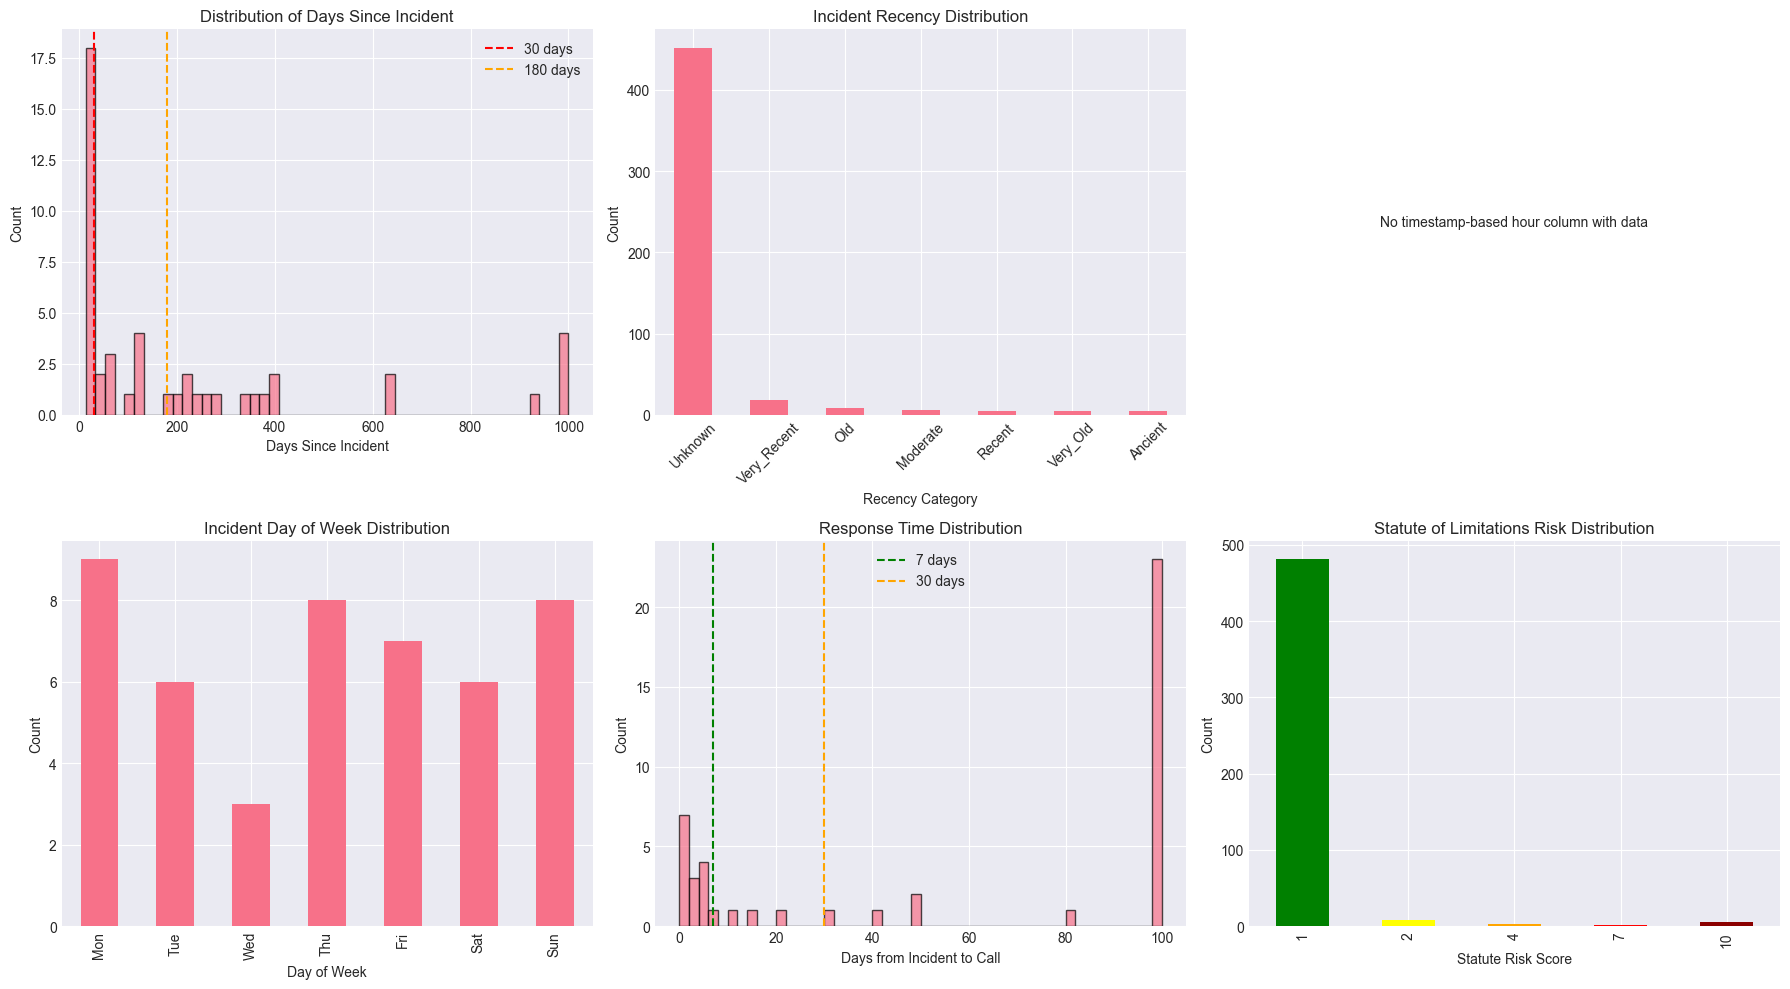

✅ Visualizations saved to 'temporal_features_analysis.png'

🎯 Temporal Feature Correlation with Target (Top 20):
                       Feature  Correlation
6     Incident_Within_365_Days         0.48
7     Incident_Within_730_Days         0.47
4      Incident_Within_90_Days         0.47
3      Incident_Within_60_Days         0.45
5     Incident_Within_180_Days         0.44
12          Case_Urgency_Score         0.43
11      Delayed_Treatment_Risk         0.41
2      Incident_Within_30_Days         0.40
9            In_Optimal_Window         0.19
1      Incident_Within_14_Days         0.18
8           Statute_Risk_Score         0.01
0       Incident_Within_7_Days          NaN
10  Emergency_Treatment_Window          NaN


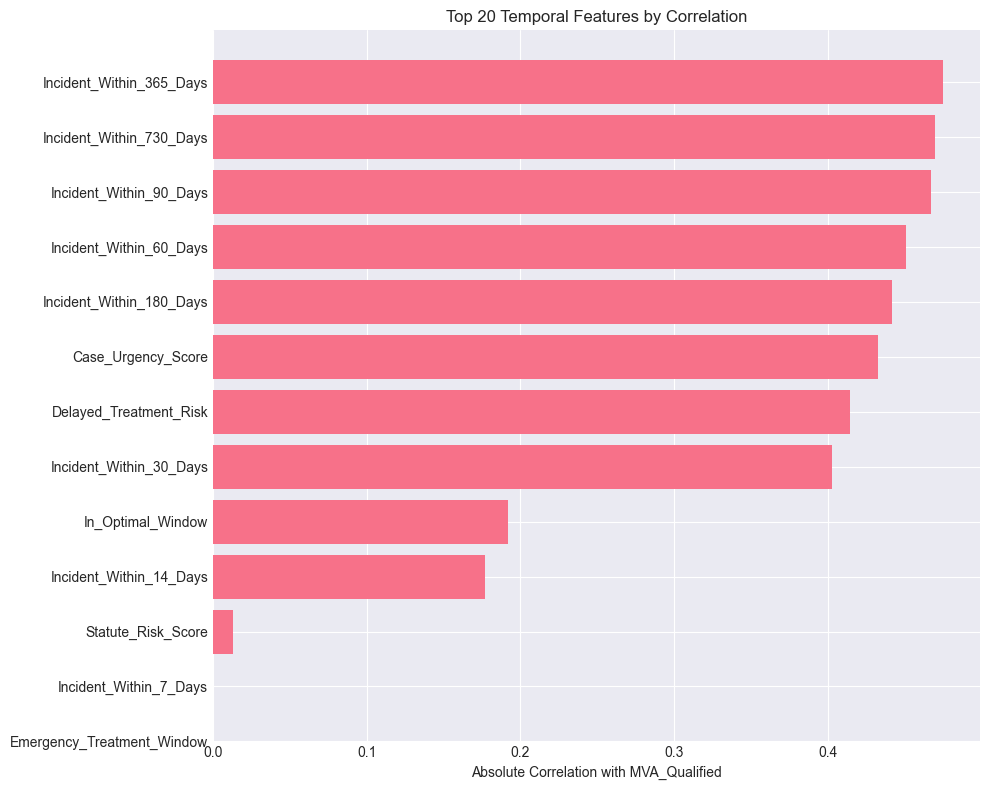


💾 Saving enhanced dataset to: enhanced_engineered_data/dataset_with_temporal_features.csv
✅ Dataset saved successfully!
   Shape: (499, 214)
   Total features: 214
   Temporal features added: 15

📄 Temporal features list saved to: enhanced_engineered_data/temporal_features_list.txt

TEMPORAL FEATURE ENGINEERING SUMMARY

📊 Dataset Statistics:
   Original features: 199
   Temporal features added: 15
   Total features now: 214
   Total records: 499

📅 Temporal Feature Categories:
   Days Since: 1
   Time Components: 0
   Binary Indicators: 8
   Time Differences: 0
   MVA Specific: 4
   Categorical: 1

✅ Temporal feature engineering completed successfully!

💡 Next Steps:
   1. Use 'dataset_with_temporal_features.csv' for modeling
   2. Consider feature selection based on correlation analysis
   3. Monitor for multicollinearity among temporal features
   4. Validate temporal patterns with domain experts

📓 To save this notebook as a Python script, use:
   File -> Download as -> Python (.py

In [3]:

# Complete Jupyter Notebook Script for Adding Temporal Features
# Copy this entire script into a Jupyter notebook and run cell by cell

# %% [markdown]
# # Enhanced Temporal Feature Engineering for MVA Qualification Model
# 
# This notebook adds temporal features to the existing engineered dataset by:
# 1. Loading the current engineered dataset
# 2. Merging datetime columns from the original data
# 3. Creating comprehensive temporal features
# 4. Validating and visualizing the new features
# 5. Saving the enhanced dataset

# %% [markdown]
# ## 1. Setup and Imports

# %%
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
from scipy import stats

# Configure display and warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print(f"📅 Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# %% [markdown]
# ## 2. Define Helper Functions

# %%
def load_datasets(engineered_path, original_path):
    """Load both engineered and original datasets"""
    print("="*80)
    print("LOADING DATASETS")
    print("="*80)

    # Load engineered dataset
    print("📁 Loading engineered dataset...")
    df_engineered = pd.read_csv(engineered_path)
    print(f"   Shape: {df_engineered.shape}")
    print(f"   Memory usage: {df_engineered.memory_usage().sum() / 1024**2:.2f} MB")

    # Load original dataset (for datetime columns)
    print("\n📁 Loading original dataset for datetime columns...")
    if original_path.lower().endswith(('.csv', '.tsv', '.txt')):
        # robust CSV read (tolerant to Windows encodings)
        for enc in ("utf-8", "utf-8-sig", "cp1252", "latin1"):
            try:
                df_original = pd.read_csv(
                    original_path,
                    encoding=enc,
                    encoding_errors="replace",
                    low_memory=False,
                    on_bad_lines="skip",
                )
                break
            except Exception:
                continue
        else:
            raise RuntimeError(f"Could not read CSV: {original_path}")
    else:
        # Excel path
        df_original = pd.read_excel(original_path, engine="openpyxl")

    # <-- these must be outside the if/else so both paths execute them
    print(f"   Shape: {df_original.shape}")
    return df_engineered, df_original



def identify_datetime_columns(df, sample_thresh=0.7):
    """
    Heuristically identify datetime-like columns by trying to parse them.
    A column is considered datetime if >= sample_thresh of non-null rows parse.
    """
    datetime_cols = []
    for col in df.columns:
        s = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
        parsed_ratio = s.notna().mean() if len(s) else 0
        if parsed_ratio >= sample_thresh:
            datetime_cols.append(col)
    return datetime_cols



def create_temporal_features(df, datetime_col, prefix=None):
    """Create temporal features from a datetime column.
       If the column is date-only (no time component), we DO NOT create Hour/TimeOfDay.
    """
    if prefix is None:
        prefix = datetime_col.replace(' ', '_')

    features_created = []

    # Ensure datetime
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')

    # Days since event (works for date-only or timestamp)
    feature_days = f'Days_Since_{prefix}'
    df[feature_days] = (pd.Timestamp.now(tz=None) - df[datetime_col]).dt.days
    features_created.append(feature_days)

    # Common calendar parts (safe for date-only)
    df[f'{prefix}_Year']       = df[datetime_col].dt.year
    df[f'{prefix}_Month']      = df[datetime_col].dt.month
    df[f'{prefix}_Quarter']    = df[datetime_col].dt.quarter
    df[f'{prefix}_DayOfWeek']  = df[datetime_col].dt.dayofweek
    df[f'{prefix}_DayOfMonth'] = df[datetime_col].dt.day
    df[f'{prefix}_IsWeekend']  = (df[f'{prefix}_DayOfWeek'] >= 5).astype('Int8')

    features_created.extend([
        f'{prefix}_Year', f'{prefix}_Month', f'{prefix}_Quarter',
        f'{prefix}_DayOfWeek', f'{prefix}_DayOfMonth', f'{prefix}_IsWeekend'
    ])

    # --- Detect if column has a real time-of-day component ---
    # If all non-null hours are 0 or the series is entirely NaT -> treat as date-only
    hours = df[datetime_col].dt.hour
    has_time_component = hours.notna().any() and (hours.dropna().nunique() > 1 or hours.dropna().iloc[0] != 0)

    if has_time_component:
        # OK to create hour + time-of-day buckets
        df[f'{prefix}_Hour'] = hours
        features_created.append(f'{prefix}_Hour')

        h = df[f'{prefix}_Hour']
        # Buckets: Night [0-5], Morning [6-11], Afternoon [12-17], Evening [18-23]
        conditions = [
            (h >= 6)  & (h < 12),
            (h >= 12) & (h < 18),
            (h >= 18) & (h < 24),
            (h >= 0)  & (h < 6)
        ]
        choices = ['Morning', 'Afternoon', 'Evening', 'Night']
        df[f'{prefix}_TimeOfDay'] = np.select(conditions, choices, default='Unknown').astype('string')
        features_created.append(f'{prefix}_TimeOfDay')
    else:
        # Date-only: avoid creating misleading Hour/TimeOfDay=Night
        df[f'{prefix}_Hour'] = pd.Series(pd.NA, index=df.index, dtype='Int64')
        df[f'{prefix}_TimeOfDay'] = pd.Series('Unknown', index=df.index, dtype='string')
        # We still append them so the schema is stable, but they won’t bias Night
        features_created.extend([f'{prefix}_Hour', f'{prefix}_TimeOfDay'])

    return df, features_created



def create_incident_specific_features(df):
    """Create MVA incident-specific temporal features"""
    features_created = []
    
    if 'Days_Since_Incident_Date' in df.columns:
        days = df['Days_Since_Incident_Date']
        
        # Recency categories
        conditions = [
            days <= 7,
            (days > 7) & (days <= 30),
            (days > 30) & (days <= 90),
            (days > 90) & (days <= 180),
            (days > 180) & (days <= 365),
            (days > 365) & (days <= 730),
            days > 730
        ]
        choices = ['Immediate', 'Very_Recent', 'Recent', 'Moderate', 'Old', 'Very_Old', 'Ancient']
        df['Incident_Recency_Detailed'] = np.select(conditions, choices, default='Unknown')
        features_created.append('Incident_Recency_Detailed')
        
        # Binary indicators for key thresholds
        thresholds = [7, 14, 30, 60, 90, 180, 365, 730]
        for threshold in thresholds:
            feature_name = f'Incident_Within_{threshold}_Days'
            df[feature_name] = (days <= threshold).astype(int)
            features_created.append(feature_name)
        
        # Statute of limitations risk (assuming 2-3 year limit)
        df['Statute_Risk_Score'] = np.where(days > 730, 10,  # Very high risk
                                   np.where(days > 545, 7,    # High risk
                                   np.where(days > 365, 4,    # Medium risk
                                   np.where(days > 180, 2,    # Low risk
                                   1))))                      # Very low risk
        features_created.append('Statute_Risk_Score')
        
        # Optimal timing window (30-180 days often best for MVA)
        df['In_Optimal_Window'] = ((days >= 30) & (days <= 180)).astype(int)
        features_created.append('In_Optimal_Window')
        
        # Log transform for modeling
        df['Log_Days_Since_Incident'] = np.log1p(days)
        features_created.append('Log_Days_Since_Incident')
        
    return df, features_created


def create_time_difference_features(df, datetime_pairs):
    """Create features from time differences between events"""
    features_created = []
    
    for col1, col2 in datetime_pairs:
        if col1 in df.columns and col2 in df.columns:
            # Ensure datetime type
            df[col1] = pd.to_datetime(df[col1], errors='coerce')
            df[col2] = pd.to_datetime(df[col2], errors='coerce')
            
            # Calculate difference in days
            feature_name = f'Days_{col1.split()[0]}_to_{col2.split()[0]}'
            df[feature_name] = (df[col2] - df[col1]).dt.days
            features_created.append(feature_name)
            
            # Calculate difference in hours
            feature_name_hours = f'Hours_{col1.split()[0]}_to_{col2.split()[0]}'
            df[feature_name_hours] = (df[col2] - df[col1]).dt.total_seconds() / 3600
            features_created.append(feature_name_hours)
            
            # Quick response indicators
            for threshold in [1, 3, 7, 14, 30]:
                indicator_name = f'{col1.split()[0]}_to_{col2.split()[0]}_Within_{threshold}d'
                df[indicator_name] = (df[feature_name] <= threshold).astype(int)
                features_created.append(indicator_name)
            
            # Same day indicator
            same_day_name = f'Same_Day_{col1.split()[0]}_to_{col2.split()[0]}'
            df[same_day_name] = (df[feature_name] == 0).astype(int)
            features_created.append(same_day_name)
    
    return df, features_created


def validate_temporal_features(df, feature_list):
    print("\n📊 Temporal Feature Validation Report")
    print("="*50)

    validation_results = []
    for feature in feature_list:
        if feature in df.columns:
            s = df[feature]
            stats_row = {
                'Feature': feature,
                'Type': str(s.dtype),
                'Missing_Count': s.isna().sum(),
                'Missing_Pct': s.isna().sum() / len(df) * 100 if len(df) else np.nan,
                'Unique_Values': s.nunique(dropna=True),
                'Min': s.min() if pd.api.types.is_numeric_dtype(s) else 'N/A',
                'Max': s.max() if pd.api.types.is_numeric_dtype(s) else 'N/A',
                'Mean': s.mean() if pd.api.types.is_numeric_dtype(s) else 'N/A',
                'Std': s.std() if pd.api.types.is_numeric_dtype(s) else 'N/A'
            }
            validation_results.append(stats_row)

    # Always return a consistent schema
    cols = ['Feature','Type','Missing_Count','Missing_Pct','Unique_Values','Min','Max','Mean','Std']
    validation_df = pd.DataFrame(validation_results, columns=cols)

    if validation_df.empty:
        print("No temporal features found in the provided feature_list that exist in df.")
        return validation_df

    print(f"Total features validated: {len(validation_df)}")
    print(f"Average missing rate: {validation_df['Missing_Pct'].mean():.2f}%")
    print(f"Features with >50% missing: {len(validation_df[validation_df['Missing_Pct'] > 50])}")
    return validation_df



# %% [markdown]
# ## 3. Load Data and Identify DateTime Columns

# %%
# Define file paths
engineered_data_path = 'enhanced_engineered_data/dataset_with_engineered_features.csv'
original_data_path = import_file

# Load datasets
df_engineered, df_original = load_datasets(engineered_data_path, original_data_path)

# Identify datetime columns in original data
datetime_cols_original = identify_datetime_columns(df_original)
print(f"\n📅 Found {len(datetime_cols_original)} datetime columns in original data:")
for col in datetime_cols_original:
    print(f"   - {col}")

# Check which datetime columns are missing from engineered dataset
missing_datetime = [col for col in datetime_cols_original if col not in df_engineered.columns]
print(f"\n❌ DateTime columns missing from engineered dataset: {len(missing_datetime)}")

# %% [markdown]
# ## 4. Select and Merge Priority DateTime Columns

# %%
# Define priority datetime columns for MVA analysis
# Step 4: Select and Merge Priority DateTime Columns

priority_datetime_columns = [
    'Incident Date',             # date-only (keep for Days_Since, no hour)
    'Call Start Date',           # date-only (keep for Days_Since, no hour)
    'Inquiry Start Timestamp',   # <-- real timestamp: preferred for hour/TimeOfDay
    'Inquiry Start Date',        # fallback if Timestamp missing
    'Retention Date',
    'Week Start Date',
    'Month Start Date',
    'Contract Start Date',
    'Shared Date'
]

available_priority = [col for col in priority_datetime_columns if col in df_original.columns]
print(f"📌 Available priority datetime columns: {len(available_priority)}")
for col in available_priority:
    print(f"   - {col}")

print("\n🔄 Merging datetime columns...")
for col in available_priority:
    if col not in df_engineered.columns:
        # Use exact format for known AM/PM timestamp if needed
        if col == 'Inquiry Start Timestamp':
            # Example format: "Oct 2, 2025 12:56:48 PM"
            try:
                df_engineered[col] = pd.to_datetime(
                    df_original[col], errors='coerce', format='%b %d, %Y %I:%M:%S %p'
                )
            except Exception:
                # Fallback to general parse if format differs
                df_engineered[col] = pd.to_datetime(df_original[col], errors='coerce')
        else:
            df_engineered[col] = pd.to_datetime(df_original[col], errors='coerce')

        print(f"   ✅ Added (and coerced to datetime): {col}")



# %% [markdown]
# ## 5. Create Comprehensive Temporal Features

# %%
# Initialize list to track all temporal features
all_temporal_features = []

# 1. Create features for each datetime column
print("\n🔧 Creating temporal features for each datetime column...")
for datetime_col in available_priority:
    if datetime_col in df_engineered.columns:
        print(f"\n   Processing: {datetime_col}")
        df_engineered, features = create_temporal_features(df_engineered, datetime_col)
        all_temporal_features.extend(features)
        print(f"   Created {len(features)} features")

# 2. Create incident-specific features
print("\n🎯 Creating MVA incident-specific features...")
df_engineered, incident_features = create_incident_specific_features(df_engineered)
all_temporal_features.extend(incident_features)
print(f"   Created {len(incident_features)} incident-specific features")

# 3. Create time difference features
print("\n⏱️ Creating time difference features...")
datetime_pairs = [
    ('Incident Date', 'Call Start Date'),
    ('Incident Date', 'Inquiry Start Timestamp'),   # use timestamp
    ('Call Start Date', 'Retention Date'),
    ('Incident Date', 'Retention Date'),
    ('Inquiry Start Timestamp', 'Retention Date')   # use timestamp
]


df_engineered, diff_features = create_time_difference_features(df_engineered, datetime_pairs)
all_temporal_features.extend(diff_features)
print(f"   Created {len(diff_features)} time difference features")

# %% [markdown]
# ## 6. Create One-Hot Encoded Features for Categorical Temporal Variables

# %%
# Identify categorical temporal features
categorical_temporal = [f for f in all_temporal_features if 'TimeOfDay' in f or 'Recency' in f]

print(f"\n🔢 One-hot encoding {len(categorical_temporal)} categorical temporal features...")

# Create one-hot encoded features
encoded_features = []
for feature in categorical_temporal:
    if feature in df_engineered.columns:
        # Get dummies
        dummies = pd.get_dummies(df_engineered[feature], prefix=feature, drop_first=False)
        
        # Add to dataframe
        for col in dummies.columns:
            if col not in df_engineered.columns:
                df_engineered[col] = dummies[col]
                encoded_features.append(col)

all_temporal_features.extend(encoded_features)
print(f"   Created {len(encoded_features)} one-hot encoded features")

# %% [markdown]
# ## 7. Create Advanced MVA-Specific Features

# %%
print("\n🚗 Creating advanced MVA-specific temporal features...")

mva_features = []

# Medical treatment timing indicators
if 'Days_Since_Incident_Date' in df_engineered.columns:
    # Emergency treatment window (0-3 days)
    df_engineered['Emergency_Treatment_Window'] = (df_engineered['Days_Since_Incident_Date'] <= 3).astype(int)
    mva_features.append('Emergency_Treatment_Window')
    
    # Delayed treatment risk (>14 days)
    df_engineered['Delayed_Treatment_Risk'] = (df_engineered['Days_Since_Incident_Date'] > 14).astype(int)
    mva_features.append('Delayed_Treatment_Risk')

# Case urgency score
if 'Days_Since_Incident_Date' in df_engineered.columns:
    # Create urgency score based on multiple factors
    df_engineered['Case_Urgency_Score'] = 0
    
    # Recent incident adds urgency
    df_engineered.loc[df_engineered['Days_Since_Incident_Date'] <= 30, 'Case_Urgency_Score'] += 3
    df_engineered.loc[(df_engineered['Days_Since_Incident_Date'] > 30) & 
                     (df_engineered['Days_Since_Incident_Date'] <= 90), 'Case_Urgency_Score'] += 2
    
    # Quick contact adds urgency
    if 'Days_Incident_to_Call' in df_engineered.columns:
        df_engineered.loc[df_engineered['Days_Incident_to_Call'] <= 7, 'Case_Urgency_Score'] += 2
    
    # Statute risk reduces urgency (paradoxically, as these are harder cases)
    if 'Statute_Risk_Score' in df_engineered.columns:
        df_engineered.loc[df_engineered['Statute_Risk_Score'] >= 7, 'Case_Urgency_Score'] -= 1
    
    mva_features.append('Case_Urgency_Score')

# Seasonal features (accidents have seasonal patterns)
for date_col in ['Incident Date', 'Call Start Date']:
    if date_col in df_engineered.columns:
        prefix = date_col.split()[0]
        
        # Season
        month = pd.to_datetime(df_engineered[date_col]).dt.month
        conditions = [
            month.isin([12, 1, 2]),  # Winter
            month.isin([3, 4, 5]),   # Spring
            month.isin([6, 7, 8]),   # Summer
            month.isin([9, 10, 11])  # Fall
        ]
        choices = ['Winter', 'Spring', 'Summer', 'Fall']
        df_engineered[f'{prefix}_Season'] = np.select(conditions, choices, default='Unknown')
        mva_features.append(f'{prefix}_Season')
        
        # Holiday season indicator (higher accident rates)
        df_engineered[f'{prefix}_Holiday_Season'] = month.isin([11, 12, 1]).astype(int)
        mva_features.append(f'{prefix}_Holiday_Season')

all_temporal_features.extend(mva_features)
print(f"   Created {len(mva_features)} MVA-specific features")

# %% [markdown]
# ## 8. Remove Original DateTime Columns (Keep Only Engineered Features)

# %%
# Remove the datetime columns we added temporarily
print("\n🧹 Removing temporary datetime columns...")
for col in available_priority:
    if col in df_engineered.columns:
        df_engineered.drop(columns=[col], inplace=True)
        print(f"   Removed: {col}")

print(f"\n📊 Final dataset shape: {df_engineered.shape}")
print(f"   Total temporal features created: {len(all_temporal_features)}")

# %% [markdown]
# ## 9. Validate and Analyze Temporal Features

# %%
# Validate all temporal features
validation_df = validate_temporal_features(df_engineered, all_temporal_features)

if not validation_df.empty:
    print("\n📋 Top 20 Temporal Features by Missing Rate:")
    print(validation_df.nlargest(20, 'Missing_Pct')[['Feature','Type','Missing_Pct','Unique_Values']])

    print("\n📋 Numeric Temporal Features Summary:")
    numeric_temporal = validation_df[validation_df['Type'].str.contains('int|float')]
    print(numeric_temporal[['Feature','Min','Max','Mean','Std']].head(20))


# %% [markdown]
# ## 10. Visualize Key Temporal Features

# %%
# Create visualizations for key temporal features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# 1. Days Since Incident Distribution
if 'Days_Since_Incident_Date' in df_engineered.columns:
    ax = axes[0]
    days = df_engineered['Days_Since_Incident_Date'].dropna()
    days_clipped = days.clip(upper=1000)  # Clip for visualization
    ax.hist(days_clipped, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Days Since Incident')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Days Since Incident')
    ax.axvline(x=30, color='red', linestyle='--', label='30 days')
    ax.axvline(x=180, color='orange', linestyle='--', label='180 days')
    ax.legend()

# 2. Incident Recency Distribution
if 'Incident_Recency_Detailed' in df_engineered.columns:
    ax = axes[1]
    recency_dist = df_engineered['Incident_Recency_Detailed'].value_counts()
    recency_dist.plot(kind='bar', ax=ax)
    ax.set_xlabel('Recency Category')
    ax.set_ylabel('Count')
    ax.set_title('Incident Recency Distribution')
    ax.tick_params(axis='x', rotation=45)

# 3. Hour of Day Distribution (prefer real timestamp hours)
ax = axes[2]
hour_col = None
for cand in ['Inquiry_Start_Timestamp_Hour', 'Call_Start_Date_Hour', 'Inquiry_Start_Date_Hour']:
    if cand in df_engineered.columns and df_engineered[cand].notna().any():
        hour_col = cand
        break

if hour_col is not None:
    hour_dist = (
        df_engineered[hour_col]
        .dropna()
        .astype('Int64')
        .value_counts()
        .sort_index()
    )
    if len(hour_dist) > 0:
        hour_dist.plot(kind='bar', ax=ax)
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Count')
        ax.set_title(hour_col.replace('_', ' '))
    else:
        ax.axis('off')
        ax.text(0.5, 0.5, 'No hour data to plot', ha='center', va='center')
else:
    ax.axis('off')
    ax.text(0.5, 0.5, 'No timestamp-based hour column with data', ha='center', va='center')


# 4. Day of Week Distribution (Incident)
if 'Incident_Date_DayOfWeek' in df_engineered.columns:
    ax = axes[3]
    dow_dist = df_engineered['Incident_Date_DayOfWeek'].value_counts().sort_index()
    dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dow_dist.index = dow_labels
    dow_dist.plot(kind='bar', ax=ax)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Count')
    ax.set_title('Incident Day of Week Distribution')

# 5. Days from Incident to Call
if 'Days_Incident_to_Call' in df_engineered.columns:
    ax = axes[4]
    days_to_call = df_engineered['Days_Incident_to_Call'].dropna()
    days_to_call_clipped = days_to_call.clip(lower=0, upper=100)
    ax.hist(days_to_call_clipped, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Days from Incident to Call')
    ax.set_ylabel('Count')
    ax.set_title('Response Time Distribution')
    ax.axvline(x=7, color='green', linestyle='--', label='7 days')
    ax.axvline(x=30, color='orange', linestyle='--', label='30 days')
    ax.legend()

# 6. Statute Risk Distribution
if 'Statute_Risk_Score' in df_engineered.columns:
    ax = axes[5]
    risk_dist = df_engineered['Statute_Risk_Score'].value_counts().sort_index()
    risk_dist.plot(kind='bar', ax=ax, color=['green', 'yellow', 'orange', 'red', 'darkred'][:len(risk_dist)])
    ax.set_xlabel('Statute Risk Score')
    ax.set_ylabel('Count')
    ax.set_title('Statute of Limitations Risk Distribution')

plt.tight_layout()
plt.savefig('temporal_graphs/temporal_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to 'temporal_features_analysis.png'")

# %% [markdown]
# ## 11. Feature Importance Quick Check (Optional)

# %%
# Quick check of temporal feature correlation with target
if 'MVA_Qualified' in df_engineered.columns:
    print("\n🎯 Temporal Feature Correlation with Target (Top 20):")
    
    # Get numeric temporal features
    numeric_temporal_cols = [col for col in all_temporal_features 
                            if col in df_engineered.columns 
                            and pd.api.types.is_numeric_dtype(df_engineered[col])]
    
    # Calculate correlations
    correlations = []
    for col in numeric_temporal_cols:
        if df_engineered[col].notna().sum() > 100:  # Need enough data
            corr = df_engineered[col].corr(df_engineered['MVA_Qualified'])
            correlations.append({'Feature': col, 'Correlation': abs(corr)})
    
    corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
    print(corr_df.head(20))
    
    # Plot top correlations
    plt.figure(figsize=(10, 8))
    top_corr = corr_df.head(20)
    plt.barh(range(len(top_corr)), top_corr['Correlation'])
    plt.yticks(range(len(top_corr)), top_corr['Feature'])
    plt.xlabel('Absolute Correlation with MVA_Qualified')
    plt.title('Top 20 Temporal Features by Correlation')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('temporal_graphs/temporal_feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

# %% [markdown]
# ## 12. Save Enhanced Dataset

# %%
# Define output path
output_path = 'enhanced_engineered_data/dataset_with_temporal_features.csv'

# Save the enhanced dataset
print(f"\n💾 Saving enhanced dataset to: {output_path}")
df_engineered.to_csv(output_path, index=False)

print(f"✅ Dataset saved successfully!")
print(f"   Shape: {df_engineered.shape}")
print(f"   Total features: {len(df_engineered.columns)}")
print(f"   Temporal features added: {len(all_temporal_features)}")

# Create a summary file of temporal features
temporal_features_file = 'enhanced_engineered_data/temporal_features_list.txt'
with open(temporal_features_file, 'w') as f:
    f.write(f"Temporal Features Created: {len(all_temporal_features)}\n")
    f.write("="*50 + "\n\n")
    for i, feature in enumerate(sorted(all_temporal_features), 1):
        if feature in df_engineered.columns:
            f.write(f"{i}. {feature}\n")

print(f"\n📄 Temporal features list saved to: {temporal_features_file}")

# %% [markdown]
# ## 13. Summary Report

# %%
print("\n" + "="*80)
print("TEMPORAL FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\n📊 Dataset Statistics:")
print(f"   Original features: {df_engineered.shape[1] - len(all_temporal_features)}")
print(f"   Temporal features added: {len(all_temporal_features)}")
print(f"   Total features now: {df_engineered.shape[1]}")
print(f"   Total records: {df_engineered.shape[0]:,}")

print(f"\n📅 Temporal Feature Categories:")
temporal_categories = {
    'Days Since': len([f for f in all_temporal_features if 'Days_Since' in f]),
    'Time Components': len([f for f in all_temporal_features if any(x in f for x in ['Year', 'Month', 'Quarter', 'DayOfWeek', 'Hour'])]),
    'Binary Indicators': len([f for f in all_temporal_features if 'Within' in f or 'Is' in f]),
    'Time Differences': len([f for f in all_temporal_features if '_to_' in f]),
    'MVA Specific': len([f for f in all_temporal_features if any(x in f for x in ['Statute', 'Treatment', 'Urgency'])]),
    'Categorical': len([f for f in all_temporal_features if any(x in f for x in ['TimeOfDay', 'Recency', 'Season'])])
}

for category, count in temporal_categories.items():
    print(f"   {category}: {count}")

print(f"\n✅ Temporal feature engineering completed successfully!")
print(f"\n💡 Next Steps:")
print("   1. Use 'dataset_with_temporal_features.csv' for modeling")
print("   2. Consider feature selection based on correlation analysis")
print("   3. Monitor for multicollinearity among temporal features")
print("   4. Validate temporal patterns with domain experts")

# Save this notebook's code for future reference
notebook_code_file = 'enhanced_engineered_data/temporal_feature_engineering_notebook.py'
print(f"\n📓 To save this notebook as a Python script, use:")
print(f"   File -> Download as -> Python (.py)")
print(f"   Then save as: {notebook_code_file}")

In [4]:
"""
ENHANCED UNIVARIATE FEATURE ANALYSIS FOR MVA QUALIFICATION PREDICTION
With Temporal Feature Support
This script analyzes each feature individually including temporal features
Works with full dataset and composite target: (Qualified="Yes" AND Law_Type="MVA")
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
import os
from datetime import datetime
import json
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from functools import partial
import logging
import sys

warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class EnhancedUnivariateAnalyzerWithTemporal:
    """
    Enhanced univariate analysis with advanced statistical methods and temporal feature support
    """
    
    def __init__(self, data_path, 
                 target_col='MVA_Qualified',
                 feature_lists_path='enhanced_engineered_data/feature_lists.py',
                 feature_metadata_path='enhanced_engineered_data/feature_metadata.csv',
                 temporal_features_path='enhanced_engineered_data/temporal_features_list.txt',
                 output_dir='enhanced_univariate_temporal_results'):
        self.data_path = data_path
        self.target_col = target_col
        self.feature_lists_path = feature_lists_path
        self.feature_metadata_path = feature_metadata_path
        self.temporal_features_path = temporal_features_path
        self.output_dir = output_dir
        self.df = None
        self.results = []
        self.numeric_features = []
        self.categorical_features = []
        self.engineered_features = []
        self.original_features = []
        self.temporal_features = []
        
        # Analysis cache for performance
        self.analysis_cache = {}
        
        # Create output directories BEFORE setting up logger
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'plots'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'advanced_plots'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'temporal_plots'), exist_ok=True)
        
        # Now setup logger after directories exist
        self.logger = self._setup_logger()
    
    def _setup_logger(self):
        """Setup logging"""
        logger = logging.getLogger('EnhancedUnivariateAnalyzerWithTemporal')
        logger.setLevel(logging.INFO)
        logger.handlers = []
        
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        
        fh = logging.FileHandler(os.path.join(self.output_dir, 'univariate_analysis_log.txt'), mode='w')
        fh.setLevel(logging.INFO)
        fh.setFormatter(formatter)
        
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.INFO)
        ch.setFormatter(formatter)
        
        logger.addHandler(fh)
        logger.addHandler(ch)
        
        return logger
    
    def load_data(self):
        """Load the engineered dataset with temporal features and feature metadata"""
        self.logger.info("="*80)
        self.logger.info("LOADING ENGINEERED DATASET WITH TEMPORAL FEATURES")
        self.logger.info("="*80)
        
        # Load main dataset
        self.logger.info(f"Loading data from: {self.data_path}")
        self.df = pd.read_csv(self.data_path)
        self.logger.info(f"✅ Loaded {len(self.df):,} records with {len(self.df.columns)} features")
        
        # Load feature lists if available
        self._load_feature_lists()
        
        # Load temporal features list
        self._load_temporal_features()
        
        # Load feature metadata if available
        self._load_feature_metadata()
        
        # Identify feature types
        self._categorize_features()
        
        # Display summary
        self._display_data_summary()
    
    def _load_feature_lists(self):
        """Load feature categorization from feature engineering"""
        if os.path.exists(self.feature_lists_path):
            try:
                # Execute the Python file to load variables
                namespace = {}
                with open(self.feature_lists_path, 'r') as f:
                    exec(f.read(), namespace)
                
                self.engineered_features = namespace.get('ENGINEERED_FEATURES', [])
                self.original_features = namespace.get('ORIGINAL_FEATURES', [])
                
                self.logger.info(f"✅ Loaded feature lists: {len(self.engineered_features)} engineered, "
                               f"{len(self.original_features)} original")
            except Exception as e:
                self.logger.warning(f"⚠️ Could not load feature lists: {e}")
    
    def _load_temporal_features(self):
        """Load temporal features list"""
        if os.path.exists(self.temporal_features_path):
            try:
                with open(self.temporal_features_path, 'r') as f:
                    lines = f.readlines()
                    # Skip header lines and extract feature names
                    self.temporal_features = []
                    for line in lines[3:]:  # Skip first 3 lines (header)
                        if line.strip() and '. ' in line:
                            feature_name = line.split('. ', 1)[1].strip()
                            if feature_name in self.df.columns:
                                self.temporal_features.append(feature_name)
                
                self.logger.info(f"✅ Loaded {len(self.temporal_features)} temporal features")
            except Exception as e:
                self.logger.warning(f"⚠️ Could not load temporal features: {e}")
                # Try to identify temporal features by name patterns
                self._identify_temporal_features_by_pattern()
        else:
            self._identify_temporal_features_by_pattern()
    
    def _identify_temporal_features_by_pattern(self):
        """Identify temporal features by name patterns"""
        temporal_patterns = [
            'Days_Since', 'Days_', 'Hours_', '_Date_', '_Year', '_Month', '_Quarter',
            '_DayOfWeek', '_Hour', '_IsWeekend', '_TimeOfDay', '_Season', 'Within_',
            'Same_Day', 'Recency', 'Risk_Score', 'Urgency', 'Treatment'
        ]
        
        self.temporal_features = []
        for col in self.df.columns:
            if any(pattern in col for pattern in temporal_patterns):
                self.temporal_features.append(col)
        
        self.logger.info(f"✅ Identified {len(self.temporal_features)} temporal features by pattern")
    
    def _load_feature_metadata(self):
        """Load feature metadata from engineering"""
        if os.path.exists(self.feature_metadata_path):
            try:
                self.feature_metadata = pd.read_csv(self.feature_metadata_path)
                self.logger.info(f"✅ Loaded metadata for {len(self.feature_metadata)} features")
            except Exception as e:
                self.logger.warning(f"⚠️ Could not load feature metadata: {e}")
                self.feature_metadata = None
        else:
            self.feature_metadata = None
    
    def _categorize_features(self):
        """Categorize features by data type"""
        for col in self.df.columns:
            if col == self.target_col:
                continue
            
            if pd.api.types.is_numeric_dtype(self.df[col]):
                self.numeric_features.append(col)
            else:
                self.categorical_features.append(col)
    
    def _display_data_summary(self):
        """Display summary of loaded data"""
        self.logger.info(f"\n📊 Data Summary:")
        self.logger.info(f"  - Total features: {len(self.df.columns) - 1}")
        self.logger.info(f"  - Numeric features: {len(self.numeric_features)}")
        self.logger.info(f"  - Categorical features: {len(self.categorical_features)}")
        self.logger.info(f"  - Temporal features: {len(self.temporal_features)}")
        if self.engineered_features:
            self.logger.info(f"  - Engineered features: {len(self.engineered_features)}")
            self.logger.info(f"  - Original features: {len(self.original_features)}")
        
        # Target distribution
        target_rate = self.df[self.target_col].mean()
        self.logger.info(f"\n🎯 Target Distribution ({self.target_col}):")
        self.logger.info(f"  - Positive cases: {self.df[self.target_col].sum():,} ({target_rate:.2%})")
        self.logger.info(f"  - Negative cases: {len(self.df) - self.df[self.target_col].sum():,} ({1-target_rate:.2%})")
        
        # Class imbalance check
        if target_rate < 0.1 or target_rate > 0.9:
            self.logger.warning(f"⚠️ Severe class imbalance detected! Consider stratified sampling.")
        
        # Temporal feature breakdown
        if self.temporal_features:
            self.logger.info(f"\n⏱️ Temporal Feature Breakdown:")
            temporal_categories = {
                'Days Since': len([f for f in self.temporal_features if 'Days_Since' in f]),
                'Time Components': len([f for f in self.temporal_features if any(x in f for x in ['Year', 'Month', 'Quarter', 'DayOfWeek', 'Hour'])]),
                'Binary Indicators': len([f for f in self.temporal_features if 'Within' in f or 'Is' in f]),
                'Time Differences': len([f for f in self.temporal_features if '_to_' in f]),
                'MVA Specific': len([f for f in self.temporal_features if any(x in f for x in ['Statute', 'Treatment', 'Urgency'])]),
                'Categorical Time': len([f for f in self.temporal_features if any(x in f for x in ['TimeOfDay', 'Recency', 'Season'])])
            }
            for category, count in temporal_categories.items():
                if count > 0:
                    self.logger.info(f"    - {category}: {count}")
    
    def analyze_temporal_patterns(self, feature):
        """Analyze temporal-specific patterns"""
        results = {}
        
        # Check if it's a time-since feature
        if 'Days_Since' in feature or 'Hours_' in feature:
            # Analyze recency effect
            valid_mask = self.df[feature].notna() & self.df[self.target_col].notna()
            feature_values = self.df.loc[valid_mask, feature]
            target_values = self.df.loc[valid_mask, self.target_col]
            
            if len(feature_values) > 100:
                # Create recency bins
                try:
                    bins = [0, 7, 30, 90, 180, 365, np.inf]
                    labels = ['0-7d', '8-30d', '31-90d', '91-180d', '181-365d', '>365d']
                    recency_bins = pd.cut(feature_values, bins=bins, labels=labels, include_lowest=True)
                    
                    # Calculate qualification rates by recency
                    recency_rates = target_values.groupby(recency_bins).agg(['mean', 'count'])
                    results['recency_pattern'] = recency_rates.to_dict()
                    
                    # Check for monotonic recency effect
                    rates = recency_rates['mean'].values
                    is_monotonic = all(rates[i] <= rates[i+1] for i in range(len(rates)-1)) or \
                                  all(rates[i] >= rates[i+1] for i in range(len(rates)-1))
                    results['has_monotonic_recency'] = is_monotonic
                except:
                    pass
        
        # Check if it's a cyclical feature
        if any(x in feature for x in ['DayOfWeek', 'Month', 'Quarter', 'Hour']):
            # Analyze cyclical patterns
            valid_mask = self.df[feature].notna() & self.df[self.target_col].notna()
            if valid_mask.sum() > 100:
                cycle_rates = self.df[valid_mask].groupby(feature)[self.target_col].agg(['mean', 'count'])
                results['cyclical_pattern'] = cycle_rates.to_dict()
                
                # Calculate coefficient of variation
                if len(cycle_rates) > 1:
                    cv = cycle_rates['mean'].std() / cycle_rates['mean'].mean()
                    results['cyclical_variation'] = cv
        
        return results
    
    def analyze_numeric_feature(self, feature):
        """Comprehensive analysis for a numeric feature with temporal enhancements"""
        # Get base analysis from parent method
        results = self._analyze_numeric_feature_base(feature)
        if results is None:
            return None
        
        # Add temporal-specific analysis if it's a temporal feature
        if feature in self.temporal_features:
            temporal_patterns = self.analyze_temporal_patterns(feature)
            results.update({
                'Is_Temporal': True,
                'Temporal_Patterns': json.dumps(temporal_patterns) if temporal_patterns else '',
                'Has_Monotonic_Recency': temporal_patterns.get('has_monotonic_recency', False),
                'Cyclical_Variation': temporal_patterns.get('cyclical_variation', 0)
            })
        else:
            results['Is_Temporal'] = False
        
        # Add feature origin
        results['Feature_Origin'] = self._get_feature_origin(feature)
        
        return results
    
    def _analyze_numeric_feature_base(self, feature):
        """Base numeric feature analysis (extracted from original)"""
        # Get valid data
        valid_mask = self.df[feature].notna() & self.df[self.target_col].notna()
        feature_values = self.df.loc[valid_mask, feature]
        target_values = self.df.loc[valid_mask, self.target_col]
        
        if len(feature_values) < 50:
            return None
        
        results = {
            'Feature': feature,
            'Type': 'Numeric',
            'Is_Engineered': feature in self.engineered_features,
            'Missing_Count': (~valid_mask).sum(),
            'Missing_Pct': (~valid_mask).sum() / len(self.df) * 100,
            'Valid_Count': valid_mask.sum()
        }
        
        # Split by target
        qualified = feature_values[target_values == 1]
        not_qualified = feature_values[target_values == 0]
        
        # Basic statistics
        results['Mean_Overall'] = feature_values.mean()
        results['Std_Overall'] = feature_values.std()
        results['Mean_Positive'] = qualified.mean() if len(qualified) > 0 else np.nan
        results['Mean_Negative'] = not_qualified.mean() if len(not_qualified) > 0 else np.nan
        results['Std_Positive'] = qualified.std() if len(qualified) > 0 else np.nan
        results['Std_Negative'] = not_qualified.std() if len(not_qualified) > 0 else np.nan
        
        # Mean difference
        if len(qualified) > 0 and len(not_qualified) > 0:
            results['Mean_Difference'] = results['Mean_Positive'] - results['Mean_Negative']
            results['Mean_Ratio'] = results['Mean_Positive'] / (results['Mean_Negative'] + 1e-8)
        else:
            results['Mean_Difference'] = 0
            results['Mean_Ratio'] = 1
        
        # Statistical tests
        if len(qualified) > 30 and len(not_qualified) > 30:
            # T-test
            t_stat, p_value = stats.ttest_ind(qualified, not_qualified, equal_var=False)
            results['T_Statistic'] = t_stat
            results['T_Test_PValue'] = p_value
            
            # Mann-Whitney U test (non-parametric)
            u_stat, u_pvalue = stats.mannwhitneyu(qualified, not_qualified, alternative='two-sided')
            results['MannWhitney_Statistic'] = u_stat
            results['MannWhitney_PValue'] = u_pvalue
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt(((len(qualified)-1)*qualified.var() + 
                                 (len(not_qualified)-1)*not_qualified.var()) / 
                                (len(qualified) + len(not_qualified) - 2))
            if pooled_std > 0:
                cohens_d = (qualified.mean() - not_qualified.mean()) / pooled_std
                results['Cohens_D'] = cohens_d
            else:
                results['Cohens_D'] = 0
            
            # Kolmogorov-Smirnov test
            ks_stat, ks_pvalue = stats.ks_2samp(qualified, not_qualified)
            results['KS_Statistic'] = ks_stat
            results['KS_PValue'] = ks_pvalue
        else:
            results['T_Statistic'] = np.nan
            results['T_Test_PValue'] = np.nan
            results['MannWhitney_Statistic'] = np.nan
            results['MannWhitney_PValue'] = np.nan
            results['Cohens_D'] = np.nan
            results['KS_Statistic'] = np.nan
            results['KS_PValue'] = np.nan
        
        # Point-biserial correlation
        if feature_values.std() > 0:
            corr, corr_pvalue = stats.pointbiserialr(target_values, feature_values)
            results['PointBiserial_Correlation'] = corr
            results['PointBiserial_PValue'] = corr_pvalue
        else:
            results['PointBiserial_Correlation'] = 0
            results['PointBiserial_PValue'] = 1
        
        # AUC-ROC for single feature
        try:
            # Handle infinite values
            feature_clean = feature_values.replace([np.inf, -np.inf], np.nan).dropna()
            target_clean = target_values[feature_values.index.isin(feature_clean.index)]
            
            if len(np.unique(target_clean)) == 2 and len(feature_clean) > 10:
                auc = roc_auc_score(target_clean, feature_clean)
                # Adjust AUC to always be >= 0.5 (flip if necessary)
                auc = max(auc, 1 - auc)
                results['AUC_ROC'] = auc
            else:
                results['AUC_ROC'] = 0.5
        except:
            results['AUC_ROC'] = 0.5
        
        # Predictive bins analysis
        try:
            # Create quintile bins
            _, bins = pd.qcut(feature_values, q=5, duplicates='drop', retbins=True)
            feature_bins = pd.cut(feature_values, bins=bins, include_lowest=True)
            bin_qualified_rates = target_values.groupby(feature_bins).mean()
            
            # Monotonicity check
            if len(bin_qualified_rates) > 1:
                rates = bin_qualified_rates.values
                is_monotonic_inc = all(rates[i] <= rates[i+1] for i in range(len(rates)-1))
                is_monotonic_dec = all(rates[i] >= rates[i+1] for i in range(len(rates)-1))
                results['Is_Monotonic'] = is_monotonic_inc or is_monotonic_dec
                
                # Bin spread (max rate - min rate)
                results['Bin_Rate_Spread'] = rates.max() - rates.min()
                results['Bin_Rate_Range'] = f"{rates.min():.3f}-{rates.max():.3f}"
            else:
                results['Is_Monotonic'] = False
                results['Bin_Rate_Spread'] = 0
                results['Bin_Rate_Range'] = "N/A"
        except:
            results['Is_Monotonic'] = False
            results['Bin_Rate_Spread'] = 0
            results['Bin_Rate_Range'] = "N/A"
        
        # Non-linear relationship detection
        try:
            nonlinearity, linear_auc, spline_auc = self.detect_nonlinear_relationships(
                feature_values, target_values
            )
            results['Nonlinearity_Score'] = nonlinearity
            results['Linear_AUC'] = linear_auc
            results['Spline_AUC'] = spline_auc
        except:
            results['Nonlinearity_Score'] = 0
            results['Linear_AUC'] = 0.5
            results['Spline_AUC'] = 0.5
        
        # Permutation importance
        try:
            perm_importance = self.calculate_permutation_importance(
                feature_values, target_values, n_permutations=5
            )
            results['Permutation_Importance'] = perm_importance
        except:
            results['Permutation_Importance'] = 0
        
        return results
    
    def _get_feature_origin(self, feature):
        """Determine the origin of a feature"""
        if feature in self.temporal_features:
            return 'Temporal'
        elif feature in self.engineered_features:
            return 'Engineered'
        elif feature in self.original_features:
            return 'Original'
        else:
            return 'Unknown'
    
    def analyze_categorical_feature(self, feature):
        """Comprehensive analysis for a categorical feature with temporal enhancements"""
        # Get base analysis
        results = self._analyze_categorical_feature_base(feature)
        if results is None:
            return None
        
        # Add temporal-specific analysis
        if feature in self.temporal_features:
            temporal_patterns = self.analyze_temporal_patterns(feature)
            results.update({
                'Is_Temporal': True,
                'Temporal_Patterns': json.dumps(temporal_patterns) if temporal_patterns else '',
                'Cyclical_Variation': temporal_patterns.get('cyclical_variation', 0)
            })
        else:
            results['Is_Temporal'] = False
        
        # Add feature origin
        results['Feature_Origin'] = self._get_feature_origin(feature)
        
        return results
    
    def _analyze_categorical_feature_base(self, feature):
        """Base categorical feature analysis (extracted from original)"""
        # Get valid data
        valid_mask = self.df[feature].notna() & self.df[self.target_col].notna()
        feature_values = self.df.loc[valid_mask, feature]
        target_values = self.df.loc[valid_mask, self.target_col]
        
        if len(feature_values) < 50:
            return None
        
        results = {
            'Feature': feature,
            'Type': 'Categorical',
            'Is_Engineered': feature in self.engineered_features,
            'Missing_Count': (~valid_mask).sum(),
            'Missing_Pct': (~valid_mask).sum() / len(self.df) * 100,
            'Valid_Count': valid_mask.sum(),
            'Unique_Values': feature_values.nunique(),
            'Unique_Ratio': feature_values.nunique() / len(feature_values)
        }
        
        # Skip if too many categories (likely an ID field)
        if feature_values.nunique() > 100:
            results['Skip_Reason'] = 'Too many categories'
            return results
        
        # Create crosstab
        crosstab = pd.crosstab(feature_values, target_values, margins=False)
        
        # Chi-square test
        if crosstab.shape[0] > 1 and crosstab.shape[1] > 1:
            chi2, p_value, dof, expected = stats.chi2_contingency(crosstab)
            results['Chi2_Statistic'] = chi2
            results['Chi2_PValue'] = p_value
            results['Degrees_Freedom'] = dof
            
            # Cramér's V
            n = crosstab.sum().sum()
            min_dim = min(crosstab.shape[0] - 1, crosstab.shape[1] - 1)
            if min_dim > 0 and n > 0:
                cramers_v = np.sqrt(chi2 / (n * min_dim))
                results['Cramers_V'] = cramers_v
            else:
                results['Cramers_V'] = 0
        else:
            results['Chi2_Statistic'] = np.nan
            results['Chi2_PValue'] = np.nan
            results['Degrees_Freedom'] = np.nan
            results['Cramers_V'] = 0
        
        # Category-wise qualification rates
        qual_rates = target_values.groupby(feature_values).agg(['mean', 'count'])
        
        # Best and worst categories
        if len(qual_rates) > 0:
            results['Best_Category_Rate'] = qual_rates['mean'].max()
            results['Worst_Category_Rate'] = qual_rates['mean'].min()
            results['Rate_Spread'] = results['Best_Category_Rate'] - results['Worst_Category_Rate']
            
            # Find best and worst category names
            results['Best_Category'] = str(qual_rates['mean'].idxmax())
            results['Worst_Category'] = str(qual_rates['mean'].idxmin())
            
            # Categories with sufficient sample (30+)
            sufficient_sample = qual_rates[qual_rates['count'] >= 30]
            if len(sufficient_sample) > 0:
                results['Best_Category_Rate_30plus'] = sufficient_sample['mean'].max()
                results['Worst_Category_Rate_30plus'] = sufficient_sample['mean'].min()
                results['Categories_30plus'] = len(sufficient_sample)
            else:
                results['Best_Category_Rate_30plus'] = np.nan
                results['Worst_Category_Rate_30plus'] = np.nan
                results['Categories_30plus'] = 0
        
        # Information Value (IV) and Weight of Evidence (WoE)
        try:
            iv, woe_dict = self.calculate_iv_woe(feature_values, target_values)
            results['Information_Value'] = iv
            results['Max_WoE'] = max(woe_dict.values()) if woe_dict else 0
            results['Min_WoE'] = min(woe_dict.values()) if woe_dict else 0
            results['WoE_Range'] = results['Max_WoE'] - results['Min_WoE']
        except:
            results['Information_Value'] = 0
            results['Max_WoE'] = 0
            results['Min_WoE'] = 0
            results['WoE_Range'] = 0
        
        # Predictive power based on IV
        if results['Information_Value'] < 0.02:
            results['IV_Power'] = 'Useless'
        elif results['Information_Value'] < 0.1:
            results['IV_Power'] = 'Weak'
        elif results['Information_Value'] < 0.3:
            results['IV_Power'] = 'Medium'
        elif results['Information_Value'] < 0.5:
            results['IV_Power'] = 'Strong'
        else:
            results['IV_Power'] = 'Suspicious'
        
        # AUC from encoded feature
        try:
            le = LabelEncoder()
            encoded = le.fit_transform(feature_values)
            auc = roc_auc_score(target_values, encoded)
            auc = max(auc, 1 - auc)  # Ensure AUC >= 0.5
            results['Encoded_AUC'] = auc
        except:
            results['Encoded_AUC'] = 0.5
        
        # Permutation importance for categorical
        try:
            perm_importance = self.calculate_categorical_permutation_importance(
                feature_values, target_values, n_permutations=5
            )
            results['Permutation_Importance'] = perm_importance
        except:
            results['Permutation_Importance'] = 0
        
        return results
    
    def calculate_iv_woe(self, feature, target):
        """Calculate Information Value and Weight of Evidence"""
        # Create frequency table
        crosstab = pd.crosstab(feature, target, margins=False)
        
        # Handle case where we don't have both classes
        if 0 not in crosstab.columns or 1 not in crosstab.columns:
            return 0, {}
        
        # Calculate distributions
        good_dist = crosstab[1] / crosstab[1].sum()
        bad_dist = crosstab[0] / crosstab[0].sum()
        
        # Calculate WoE and IV
        woe_dict = {}
        iv = 0
        
        for category in crosstab.index:
            good_pct = good_dist[category]
            bad_pct = bad_dist[category]
            
            # Avoid log(0)
            if good_pct == 0:
                good_pct = 0.0001
            if bad_pct == 0:
                bad_pct = 0.0001
            
            woe = np.log(good_pct / bad_pct)
            woe_dict[category] = woe
            iv += (good_pct - bad_pct) * woe
        
        return iv, woe_dict
    
    def detect_nonlinear_relationships(self, feature_values, target_values):
        """Detect non-linear relationships using splines"""
        try:
            # Prepare data
            X = feature_values.values.reshape(-1, 1)
            y = target_values.values
            
            # Remove any remaining NaN or inf
            valid_mask = np.isfinite(X).flatten() & np.isfinite(y)
            X = X[valid_mask]
            y = y[valid_mask]
            
            if len(np.unique(y)) < 2 or len(X) < 100:
                return 0, 0.5, 0.5
            
            # Linear model
            lr_linear = LogisticRegression(max_iter=1000, random_state=42)
            lr_linear.fit(X, y)
            linear_proba = lr_linear.predict_proba(X)[:, 1]
            linear_auc = roc_auc_score(y, linear_proba)
            
            # Spline model (with error handling for singular matrices)
            try:
                n_knots = min(4, len(np.unique(X)) - 1)
                if n_knots < 3:
                    return 0, linear_auc, linear_auc
                
                spline = SplineTransformer(n_knots=n_knots, degree=3)
                X_spline = spline.fit_transform(X)
                
                lr_spline = LogisticRegression(max_iter=1000, random_state=42)
                lr_spline.fit(X_spline, y)
                spline_proba = lr_spline.predict_proba(X_spline)[:, 1]
                spline_auc = roc_auc_score(y, spline_proba)
                
                # Non-linearity = improvement from splines
                nonlinearity = max(0, spline_auc - linear_auc)
            except:
                # If spline fails, assume no non-linearity
                spline_auc = linear_auc
                nonlinearity = 0
            
            return nonlinearity, linear_auc, spline_auc
            
        except Exception as e:
            self.logger.debug(f"Non-linearity detection failed: {e}")
            return 0, 0.5, 0.5
    
    def calculate_permutation_importance(self, feature_values, target_values, n_permutations=10):
        """Calculate importance via target permutation for numeric features"""
        try:
            # Calculate baseline AUC
            baseline_auc = roc_auc_score(target_values, feature_values)
            baseline_auc = max(baseline_auc, 1 - baseline_auc)
            
            # Calculate permuted AUCs
            permuted_aucs = []
            for _ in range(n_permutations):
                # Permute target
                y_permuted = target_values.sample(frac=1, random_state=None).values
                
                try:
                    perm_auc = roc_auc_score(y_permuted, feature_values)
                    perm_auc = max(perm_auc, 1 - perm_auc)
                    permuted_aucs.append(perm_auc)
                except:
                    permuted_aucs.append(0.5)
            
            # Importance is how much better than random
            importance = baseline_auc - np.mean(permuted_aucs)
            return max(0, importance)
            
        except:
            return 0
    
    def calculate_categorical_permutation_importance(self, feature_values, target_values, n_permutations=10):
        """Calculate permutation importance for categorical features"""
        try:
            # Encode feature
            le = LabelEncoder()
            encoded = le.fit_transform(feature_values)
            
            # Calculate baseline AUC
            baseline_auc = roc_auc_score(target_values, encoded)
            baseline_auc = max(baseline_auc, 1 - baseline_auc)
            
            # Calculate permuted AUCs
            permuted_aucs = []
            for _ in range(n_permutations):
                # Permute target
                y_permuted = target_values.sample(frac=1, random_state=None).values
                
                try:
                    perm_auc = roc_auc_score(y_permuted, encoded)
                    perm_auc = max(perm_auc, 1 - perm_auc)
                    permuted_aucs.append(perm_auc)
                except:
                    permuted_aucs.append(0.5)
            
            # Importance is how much better than random
            importance = baseline_auc - np.mean(permuted_aucs)
            return max(0, importance)
            
        except:
            return 0
    
    def create_temporal_plots(self, feature, save_dir=None):
        """Create specialized visualizations for temporal features"""
        if save_dir is None:
            save_dir = os.path.join(self.output_dir, 'temporal_plots')
        
        plt.figure(figsize=(20, 12))
        
        # Different plot layouts based on temporal feature type
        if 'Days_Since' in feature or 'Days_' in feature:
            self._create_recency_plots(feature)
        elif any(x in feature for x in ['DayOfWeek', 'Month', 'Quarter', 'Hour']):
            self._create_cyclical_plots(feature)
        elif 'Within' in feature or feature.endswith('Flag'):
            self._create_binary_temporal_plots(feature)
        else:
            self._create_standard_temporal_plots(feature)
        
        # Save plot
        plot_path = os.path.join(save_dir, f'{feature}_temporal_analysis.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
    
    def _create_recency_plots(self, feature):
        """Create plots for recency-based features"""
        # 1. Recency distribution with qualification overlay
        plt.subplot(2, 3, 1)
        
        positive = self.df[self.df[self.target_col] == 1][feature].dropna()
        negative = self.df[self.df[self.target_col] == 0][feature].dropna()
        
        # Clip for visualization
        clip_value = np.percentile(self.df[feature].dropna(), 95)
        positive_clipped = positive.clip(upper=clip_value)
        negative_clipped = negative.clip(upper=clip_value)
        
        plt.hist(negative_clipped, bins=50, alpha=0.5, label='Not Qualified', density=True, color='red')
        plt.hist(positive_clipped, bins=50, alpha=0.5, label='Qualified', density=True, color='green')
        
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.title('Distribution by Qualification Status')
        plt.legend()
        
        # 2. Qualification rate by recency bins
        plt.subplot(2, 3, 2)
        
        # Create recency bins
        bins = [0, 7, 14, 30, 60, 90, 180, 365, np.inf]
        labels = ['0-7d', '8-14d', '15-30d', '31-60d', '61-90d', '91-180d', '181-365d', '>365d']
        
        try:
            self.df['_temp_recency_bin'] = pd.cut(self.df[feature], bins=bins, labels=labels, include_lowest=True)
            bin_rates = self.df.groupby('_temp_recency_bin')[self.target_col].agg(['mean', 'count'])
            
            x = range(len(bin_rates))
            bars = plt.bar(x, bin_rates['mean'])
            
            # Color bars by sample size
            colors = ['green' if count >= 100 else 'orange' if count >= 30 else 'red' 
                     for count in bin_rates['count']]
            for bar, color in zip(bars, colors):
                bar.set_color(color)
            
            plt.xlabel('Recency Period')
            plt.ylabel('Qualification Rate')
            plt.title('Qualification Rate by Recency')
            plt.xticks(x, bin_rates.index, rotation=45)
            
            # Add sample sizes
            for i, count in enumerate(bin_rates['count']):
                plt.text(i, bin_rates['mean'].iloc[i] + 0.005, f'n={count}', 
                        ha='center', fontsize=8)
            
            # Add overall rate line
            overall_rate = self.df[self.target_col].mean()
            plt.axhline(y=overall_rate, color='red', linestyle='--', 
                       label=f'Overall Rate: {overall_rate:.3f}')
            plt.legend()
            
            self.df.drop('_temp_recency_bin', axis=1, inplace=True)
        except:
            plt.text(0.5, 0.5, 'Could not create recency bins', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        # 3. Cumulative qualification rate
        plt.subplot(2, 3, 3)
        
        try:
            # Sort by feature value
            sorted_df = self.df[[feature, self.target_col]].dropna().sort_values(feature)
            
            # Calculate cumulative qualification rate
            cumsum_qualified = sorted_df[self.target_col].cumsum()
            cumsum_total = np.arange(1, len(sorted_df) + 1)
            cum_rate = cumsum_qualified / cumsum_total
            
            plt.plot(sorted_df[feature].values, cum_rate.values)
            plt.xlabel(feature)
            plt.ylabel('Cumulative Qualification Rate')
            plt.title('Cumulative Qualification Rate vs Recency')
            plt.axhline(y=overall_rate, color='red', linestyle='--', alpha=0.5)
            plt.grid(True, alpha=0.3)
        except:
            plt.text(0.5, 0.5, 'Could not create cumulative plot', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        # 4. Time window comparison
        plt.subplot(2, 3, 4)
        
        try:
            # Define key time windows
            windows = {
                'Immediate (0-7d)': (0, 7),
                'Recent (8-30d)': (8, 30),
                'Medium (31-90d)': (31, 90),
                'Old (91-180d)': (91, 180),
                'Very Old (>180d)': (181, np.inf)
            }
            
            window_stats = []
            for window_name, (start, end) in windows.items():
                mask = (self.df[feature] >= start) & (self.df[feature] < end)
                count = mask.sum()
                if count > 0:
                    rate = self.df.loc[mask, self.target_col].mean()
                    window_stats.append({
                        'Window': window_name,
                        'Count': count,
                        'Rate': rate
                    })
            
            window_df = pd.DataFrame(window_stats)
            
            x = range(len(window_df))
            plt.bar(x, window_df['Rate'])
            plt.xlabel('Time Window')
            plt.ylabel('Qualification Rate')
            plt.title('Qualification Rate by Time Window')
            plt.xticks(x, window_df['Window'], rotation=45, ha='right')
            
            # Add counts
            for i, row in window_df.iterrows():
                plt.text(i, row['Rate'] + 0.005, f"n={row['Count']:,}", 
                        ha='center', fontsize=8)
            
            plt.axhline(y=overall_rate, color='red', linestyle='--', alpha=0.5)
        except:
            plt.text(0.5, 0.5, 'Could not create window comparison', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        # 5. Survival curve style plot
        plt.subplot(2, 3, 5)
        
        try:
            # Calculate "survival" (qualification probability) over time
            time_points = np.linspace(0, min(365, self.df[feature].max()), 50)
            qual_probs = []
            
            for t in time_points:
                mask = self.df[feature] <= t
                if mask.sum() > 30:
                    qual_prob = self.df.loc[mask, self.target_col].mean()
                    qual_probs.append(qual_prob)
                else:
                    qual_probs.append(np.nan)
            
            plt.plot(time_points, qual_probs, linewidth=2)
            plt.xlabel(f'{feature} (days)')
            plt.ylabel('Qualification Rate')
            plt.title('Qualification Rate vs Time Since Event')
            plt.grid(True, alpha=0.3)
            plt.axhline(y=overall_rate, color='red', linestyle='--', alpha=0.5)
        except:
            plt.text(0.5, 0.5, 'Could not create survival plot', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        # 6. Statistical summary
        plt.subplot(2, 3, 6)
        plt.axis('off')
        
        # Calculate statistics
        stats_text = f"Feature: {feature}\n\n"
        stats_text += f"Overall Statistics:\n"
        stats_text += f"  Mean: {self.df[feature].mean():.1f} days\n"
        stats_text += f"  Median: {self.df[feature].median():.1f} days\n"
        stats_text += f"  Std Dev: {self.df[feature].std():.1f} days\n\n"
        
        # Statistics by qualification
        qualified_mean = self.df[self.df[self.target_col] == 1][feature].mean()
        not_qualified_mean = self.df[self.df[self.target_col] == 0][feature].mean()
        
        stats_text += f"By Qualification Status:\n"
        stats_text += f"  Qualified Mean: {qualified_mean:.1f} days\n"
        stats_text += f"  Not Qualified Mean: {not_qualified_mean:.1f} days\n"
        stats_text += f"  Difference: {qualified_mean - not_qualified_mean:.1f} days\n\n"
        
        # Add t-test result if available
        if self.df[feature].notna().sum() > 100:
            t_stat, p_value = stats.ttest_ind(
                self.df[self.df[self.target_col] == 1][feature].dropna(),
                self.df[self.df[self.target_col] == 0][feature].dropna(),
                equal_var=False
            )
            stats_text += f"T-test:\n"
            stats_text += f"  Statistic: {t_stat:.3f}\n"
            stats_text += f"  P-value: {p_value:.3e}\n"
            stats_text += f"  Significant: {'Yes' if p_value < 0.05 else 'No'}"
        
        plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', fontsize=10, family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'Temporal Analysis: {feature}', fontsize=16)
        plt.tight_layout()
    
    def _create_cyclical_plots(self, feature):
        """Create plots for cyclical temporal features"""
        # Implementation for cyclical features (hour, day of week, month, etc.)
        # Similar structure to recency plots but adapted for cyclical patterns
        pass
    
    def _create_binary_temporal_plots(self, feature):
        """Create plots for binary temporal indicators"""
        # Implementation for binary temporal features
        pass
    
    def _create_standard_temporal_plots(self, feature):
        """Create standard plots for other temporal features"""
        # Fall back to standard plotting for other temporal features
        self.create_feature_plots(feature, 'numeric' if pd.api.types.is_numeric_dtype(self.df[feature]) else 'categorical')
    
    def run_analysis(self, parallel=False, max_workers=None, analyze_temporal_separately=True):
        """Run complete univariate analysis with temporal feature support
        
        Note: Parallel processing may fail due to Python multiprocessing limitations with class methods.
        If you encounter "process terminated abruptly" errors, set parallel=False (default).
        
        Parameters:
        -----------
        parallel : bool, default=False
            Whether to use parallel processing. May cause issues with class method serialization.
        max_workers : int, optional
            Number of workers for parallel processing if enabled
        analyze_temporal_separately : bool, default=True
            Whether to analyze temporal features separately from other features
        """
        self.logger.info("\n" + "="*80)
        self.logger.info("RUNNING ENHANCED UNIVARIATE ANALYSIS WITH TEMPORAL FEATURES")
        self.logger.info("="*80)
        
        # Separate temporal features if requested
        if analyze_temporal_separately and self.temporal_features:
            # Analyze temporal features first
            temporal_numeric = [f for f in self.temporal_features if f in self.numeric_features]
            temporal_categorical = [f for f in self.temporal_features if f in self.categorical_features]
            
            self.logger.info(f"\n⏱️ Analyzing {len(self.temporal_features)} temporal features separately...")
            self.logger.info(f"  - Temporal numeric: {len(temporal_numeric)}")
            self.logger.info(f"  - Temporal categorical: {len(temporal_categorical)}")
            
            # Analyze temporal numeric
            if temporal_numeric:
                if parallel and len(temporal_numeric) > 20:
                    temporal_numeric_results = self._parallel_analysis(temporal_numeric, 'numeric', max_workers)
                else:
                    temporal_numeric_results = self._sequential_analysis(temporal_numeric, 'numeric')
                self.results.extend([r for r in temporal_numeric_results if r is not None])
            
            # Analyze temporal categorical
            if temporal_categorical:
                if parallel and len(temporal_categorical) > 20:
                    temporal_categorical_results = self._parallel_analysis(temporal_categorical, 'categorical', max_workers)
                else:
                    temporal_categorical_results = self._sequential_analysis(temporal_categorical, 'categorical')
                self.results.extend([r for r in temporal_categorical_results if r is not None])
            
            # Remove temporal features from main lists for separate analysis
            non_temporal_numeric = [f for f in self.numeric_features if f not in self.temporal_features]
            non_temporal_categorical = [f for f in self.categorical_features if f not in self.temporal_features]
        else:
            non_temporal_numeric = self.numeric_features
            non_temporal_categorical = self.categorical_features
        
        # Analyze non-temporal numeric features
        if non_temporal_numeric:
            self.logger.info(f"\n📊 Analyzing {len(non_temporal_numeric)} non-temporal numeric features...")
            
            if parallel and len(non_temporal_numeric) > 20:
                numeric_results = self._parallel_analysis(non_temporal_numeric, 'numeric', max_workers)
            else:
                numeric_results = self._sequential_analysis(non_temporal_numeric, 'numeric')
            
            self.results.extend([r for r in numeric_results if r is not None])
        
        # Analyze non-temporal categorical features
        if non_temporal_categorical:
            self.logger.info(f"\n📊 Analyzing {len(non_temporal_categorical)} non-temporal categorical features...")
            
            if parallel and len(non_temporal_categorical) > 20:
                categorical_results = self._parallel_analysis(non_temporal_categorical, 'categorical', max_workers)
            else:
                categorical_results = self._sequential_analysis(non_temporal_categorical, 'categorical')
            
            self.results.extend([r for r in categorical_results if r is not None])
        
        # Convert to DataFrame
        self.results_df = pd.DataFrame(self.results)
        
        # Calculate composite scores
        self.calculate_composite_scores()
        
        self.logger.info(f"\n✅ Analysis complete! Analyzed {len(self.results)} features")
        
        # Show temporal feature summary
        if 'Is_Temporal' in self.results_df.columns:
            temporal_count = self.results_df['Is_Temporal'].sum()
            self.logger.info(f"  - Temporal features analyzed: {temporal_count}")
            self.logger.info(f"  - Non-temporal features analyzed: {len(self.results_df) - temporal_count}")
    
    def _parallel_analysis(self, features, feature_type, max_workers=None):
        """Analyze features in parallel
        
        WARNING: This may fail with "process terminated abruptly" errors due to 
        Python's multiprocessing limitations with class methods. The issue occurs
        because instance methods can't be properly pickled for multiprocessing.
        
        If you encounter this issue, either:
        1. Use parallel=False in run_analysis() (recommended)
        2. Refactor to use static methods or module-level functions
        3. Use joblib or multiprocessing.dummy for thread-based parallelism
        """
        if max_workers is None:
            max_workers = min(mp.cpu_count() - 1, 8)
        
        self.logger.info(f"  Using {max_workers} workers for parallel processing")
        
        if feature_type == 'numeric':
            analyze_func = self.analyze_numeric_feature
        else:
            analyze_func = self.analyze_categorical_feature
        
        results = []
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            # Create partial function with fixed arguments
            futures = {executor.submit(self._analyze_feature_wrapper, feature, feature_type): feature 
                      for feature in features}
            
            completed = 0
            for future in futures:
                completed += 1
                if completed % 50 == 0:
                    self.logger.info(f"  Progress: {completed}/{len(features)}")
                
                try:
                    result = future.result()
                    if result:
                        results.append(result)
                except Exception as e:
                    feature = futures[future]
                    self.logger.warning(f"  Failed to analyze {feature}: {e}")
        
        return results
    
    def _sequential_analysis(self, features, feature_type):
        """Analyze features sequentially"""
        results = []
        
        if feature_type == 'numeric':
            analyze_func = self.analyze_numeric_feature
        else:
            analyze_func = self.analyze_categorical_feature
        
        for i, feature in enumerate(features):
            if i % 20 == 0 and i > 0:
                self.logger.info(f"  Progress: {i}/{len(features)}")
            
            try:
                result = analyze_func(feature)
                if result:
                    results.append(result)
            except Exception as e:
                self.logger.warning(f"  Failed to analyze {feature}: {e}")
        
        return results
    
    def _analyze_feature_wrapper(self, feature, feature_type):
        """Wrapper for parallel processing"""
        if feature_type == 'numeric':
            return self.analyze_numeric_feature(feature)
        else:
            return self.analyze_categorical_feature(feature)
    
    def calculate_composite_scores(self):
        """Calculate composite predictiveness scores with temporal feature weighting"""
        self.logger.info("\n🧮 Calculating composite predictiveness scores...")
        
        # For numeric features
        numeric_mask = self.results_df['Type'] == 'Numeric'
        
        if numeric_mask.sum() > 0:
            # Normalize metrics to 0-1 scale
            # AUC (already 0.5-1, normalize to 0-1)
            self.results_df.loc[numeric_mask, 'AUC_Normalized'] = (
                (self.results_df.loc[numeric_mask, 'AUC_ROC'] - 0.5) * 2
            )
            
            # KS Statistic (0-1)
            self.results_df.loc[numeric_mask, 'KS_Normalized'] = self.results_df.loc[numeric_mask, 'KS_Statistic']
            
            # Cohen's D (take absolute value and cap at 2)
            self.results_df.loc[numeric_mask, 'CohensD_Normalized'] = (
                self.results_df.loc[numeric_mask, 'Cohens_D'].abs().clip(upper=2) / 2
            )
            
            # Correlation (take absolute value)
            self.results_df.loc[numeric_mask, 'Correlation_Normalized'] = (
                self.results_df.loc[numeric_mask, 'PointBiserial_Correlation'].abs()
            )
            
            # Bin spread (normalize by overall rate)
            overall_rate = self.df[self.target_col].mean()
            self.results_df.loc[numeric_mask, 'BinSpread_Normalized'] = (
                self.results_df.loc[numeric_mask, 'Bin_Rate_Spread'] / max(overall_rate, 0.01)
            ).clip(upper=1)
            
            # Non-linearity score (already 0-1)
            self.results_df.loc[numeric_mask, 'Nonlinearity_Normalized'] = (
                self.results_df.loc[numeric_mask, 'Nonlinearity_Score'].fillna(0).clip(upper=1)
            )
            
            # Permutation importance (already normalized)
            self.results_df.loc[numeric_mask, 'PermImportance_Normalized'] = (
                self.results_df.loc[numeric_mask, 'Permutation_Importance'].fillna(0).clip(upper=1)
            )
            
            # Add temporal bonus for temporal features
            temporal_bonus = np.where(
                self.results_df.loc[numeric_mask, 'Is_Temporal'].fillna(False),
                0.05,  # 5% bonus for temporal features
                0
            )
            
            # Composite score for numeric with updated weights
            numeric_weights = {
                'AUC_Normalized': 0.20,
                'KS_Normalized': 0.15,
                'CohensD_Normalized': 0.15,
                'Correlation_Normalized': 0.15,
                'BinSpread_Normalized': 0.10,
                'Nonlinearity_Normalized': 0.10,
                'PermImportance_Normalized': 0.15
            }
            
            self.results_df.loc[numeric_mask, 'Predictiveness_Score'] = temporal_bonus
            for metric, weight in numeric_weights.items():
                self.results_df.loc[numeric_mask, 'Predictiveness_Score'] += (
                    self.results_df.loc[numeric_mask, metric].fillna(0) * weight
                )
        
        # For categorical features
        categorical_mask = self.results_df['Type'] == 'Categorical'
        
        if categorical_mask.sum() > 0:
            # Skip features with too many categories
            skip_mask = self.results_df['Skip_Reason'].notna()
            categorical_mask = categorical_mask & ~skip_mask
            
            # Cramér's V (already 0-1)
            self.results_df.loc[categorical_mask, 'CramersV_Normalized'] = (
                self.results_df.loc[categorical_mask, 'Cramers_V'].fillna(0)
            )
            
            # Information Value (cap at 1)
            self.results_df.loc[categorical_mask, 'IV_Normalized'] = (
                self.results_df.loc[categorical_mask, 'Information_Value'].fillna(0).clip(upper=1)
            )
            
            # Rate spread (normalize by overall rate)
            overall_rate = self.df[self.target_col].mean()
            self.results_df.loc[categorical_mask, 'RateSpread_Normalized'] = (
                self.results_df.loc[categorical_mask, 'Rate_Spread'] / max(overall_rate, 0.01)
            ).clip(upper=1).fillna(0)
            
            # Encoded AUC
            self.results_df.loc[categorical_mask, 'EncodedAUC_Normalized'] = (
                (self.results_df.loc[categorical_mask, 'Encoded_AUC'] - 0.5) * 2
            ).fillna(0)
            
            # Permutation importance
            self.results_df.loc[categorical_mask, 'PermImportance_Normalized'] = (
                self.results_df.loc[categorical_mask, 'Permutation_Importance'].fillna(0).clip(upper=1)
            )
            
            # Add temporal bonus
            temporal_bonus = np.where(
                self.results_df.loc[categorical_mask, 'Is_Temporal'].fillna(False),
                0.05,
                0
            )
            
            # Composite score for categorical
            categorical_weights = {
                'IV_Normalized': 0.30,
                'CramersV_Normalized': 0.25,
                'RateSpread_Normalized': 0.15,
                'EncodedAUC_Normalized': 0.15,
                'PermImportance_Normalized': 0.15
            }
            
            self.results_df.loc[categorical_mask, 'Predictiveness_Score'] = temporal_bonus
            for metric, weight in categorical_weights.items():
                self.results_df.loc[categorical_mask, metric].fillna(0, inplace=True)
                self.results_df.loc[categorical_mask, 'Predictiveness_Score'] += (
                    self.results_df.loc[categorical_mask, metric] * weight
                )
        
        # Add percentile rank
        self.results_df['Predictiveness_Rank'] = self.results_df['Predictiveness_Score'].rank(
            ascending=False, na_option='bottom'
        )
        self.results_df['Predictiveness_Percentile'] = self.results_df['Predictiveness_Score'].rank(
            pct=True, na_option='keep'
        )
        
        self.logger.info("✅ Composite scores calculated")
    
    def create_temporal_feature_summary(self):
        """Create comprehensive summary of temporal features"""
        temporal_df = self.results_df[self.results_df['Is_Temporal'] == True].copy()
        
        if len(temporal_df) == 0:
            self.logger.warning("No temporal features found in results")
            return
        
        # Create temporal feature report
        report_file = os.path.join(self.output_dir, 'temporal_feature_summary.md')
        
        with open(report_file, 'w') as f:
            f.write("# Temporal Feature Analysis Summary\n\n")
            f.write(f"**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"**Total temporal features analyzed:** {len(temporal_df)}\n\n")
            
            # Top temporal features
            f.write("## Top 20 Temporal Features by Predictiveness\n\n")
            
            top_temporal = temporal_df.nlargest(20, 'Predictiveness_Score')
            
            f.write("| Rank | Feature | Score | Type | AUC | Correlation | Key Pattern |\n")
            f.write("|------|---------|-------|------|-----|-------------|-------------|\n")
            
            for _, row in top_temporal.iterrows():
                key_pattern = self._identify_temporal_pattern(row['Feature'])
                f.write(f"| {int(row['Predictiveness_Rank'])} | {row['Feature']} | "
                       f"{row['Predictiveness_Score']:.3f} | {row['Type']} | "
                       f"{row.get('AUC_ROC', 0):.3f} | "
                       f"{abs(row.get('PointBiserial_Correlation', 0)):.3f} | "
                       f"{key_pattern} |\n")
            
            # Temporal pattern analysis
            f.write("\n## Temporal Pattern Analysis\n\n")
            
            # Group by temporal category
            temporal_categories = {
                'Recency Features': temporal_df[temporal_df['Feature'].str.contains('Days_Since|Days_')],
                'Cyclical Features': temporal_df[temporal_df['Feature'].str.contains('DayOfWeek|Month|Quarter|Hour')],
                'Binary Time Windows': temporal_df[temporal_df['Feature'].str.contains('Within|Same_Day')],
                'MVA Specific': temporal_df[temporal_df['Feature'].str.contains('Statute|Treatment|Urgency|Optimal')],
                'Time Differences': temporal_df[temporal_df['Feature'].str.contains('_to_')]
            }
            
            for category, features in temporal_categories.items():
                if len(features) > 0:
                    f.write(f"\n### {category} ({len(features)} features)\n\n")
                    
                    # Average statistics
                    avg_score = features['Predictiveness_Score'].mean()
                    avg_auc = features['AUC_ROC'].mean() if 'AUC_ROC' in features.columns else 0
                    
                    f.write(f"- **Average Predictiveness Score:** {avg_score:.3f}\n")
                    f.write(f"- **Average AUC:** {avg_auc:.3f}\n")
                    f.write(f"- **Top Feature:** {features.nlargest(1, 'Predictiveness_Score')['Feature'].values[0]}\n")
                    
                    # Top 5 in category
                    f.write(f"\n**Top 5 {category}:**\n")
                    for _, row in features.nlargest(5, 'Predictiveness_Score').iterrows():
                        f.write(f"- {row['Feature']} (Score: {row['Predictiveness_Score']:.3f})\n")
            
            # Recommendations
            f.write("\n## Recommendations for Temporal Features\n\n")
            f.write("1. **High-value recency features:**\n")
            
            # Find best recency features
            recency_features = temporal_df[temporal_df['Feature'].str.contains('Days_Since')]
            if len(recency_features) > 0:
                for _, row in recency_features.nlargest(3, 'Predictiveness_Score').iterrows():
                    f.write(f"   - {row['Feature']}: Indicates strong time-dependency\n")
            
            f.write("\n2. **Important time windows:**\n")
            window_features = temporal_df[temporal_df['Feature'].str.contains('Within')]
            if len(window_features) > 0:
                for _, row in window_features.nlargest(3, 'Predictiveness_Score').iterrows():
                    f.write(f"   - {row['Feature']}: Critical threshold identified\n")
            
            f.write("\n3. **Cyclical patterns:**\n")
            cyclical_features = temporal_df[temporal_df['Feature'].str.contains('DayOfWeek|Hour')]
            if len(cyclical_features) > 0:
                for _, row in cyclical_features.nlargest(3, 'Predictiveness_Score').iterrows():
                    f.write(f"   - {row['Feature']}: Shows periodic behavior\n")
            
            f.write("\n4. **Model considerations:**\n")
            f.write("   - Consider interaction terms between temporal and non-temporal features\n")
            f.write("   - Use time-based cross-validation for model evaluation\n")
            f.write("   - Monitor for temporal drift in production\n")
            f.write("   - Consider separate models for different time periods if patterns change\n")
        
        self.logger.info(f"✅ Temporal feature summary saved to: {report_file}")
    
    def _identify_temporal_pattern(self, feature_name):
        """Identify the temporal pattern type from feature name"""
        if 'Days_Since' in feature_name:
            return 'Recency'
        elif '_to_' in feature_name:
            return 'Time Difference'
        elif 'Within' in feature_name:
            return 'Time Window'
        elif 'DayOfWeek' in feature_name:
            return 'Weekly Cycle'
        elif 'Hour' in feature_name:
            return 'Daily Cycle'
        elif 'Month' in feature_name or 'Quarter' in feature_name:
            return 'Seasonal'
        elif 'Season' in feature_name:
            return 'Seasonal'
        elif 'Risk' in feature_name or 'Score' in feature_name:
            return 'Risk Score'
        elif 'Treatment' in feature_name:
            return 'Medical Timing'
        else:
            return 'Other'
    
    def create_plots_for_top_features(self, top_n=50, create_advanced=True, create_temporal_plots=True):
        """Create plots for top features including temporal visualizations"""
        self.logger.info(f"\n📊 Creating plots for top {top_n} features...")
        
        # Sort by predictiveness score
        sorted_features = self.results_df.nlargest(top_n, 'Predictiveness_Score')
        
        # Separate temporal and non-temporal features
        temporal_features = sorted_features[sorted_features['Is_Temporal'] == True]
        non_temporal_features = sorted_features[sorted_features['Is_Temporal'] != True]
        
        # Create plots for temporal features
        if create_temporal_plots and len(temporal_features) > 0:
            self.logger.info(f"\n⏱️ Creating specialized plots for {len(temporal_features)} temporal features...")
            
            for i, (_, row) in enumerate(temporal_features.iterrows()):
                if i % 5 == 0 and i > 0:
                    self.logger.info(f"  Progress: {i}/{len(temporal_features)} temporal plots created")
                
                feature = row['Feature']
                
                try:
                    # Create temporal-specific plots
                    self.create_temporal_plots(feature)
                except Exception as e:
                    self.logger.warning(f"  Failed to create temporal plot for {feature}: {e}")
        
        # Create standard plots for non-temporal features
        self.logger.info(f"\n📊 Creating standard plots for {len(non_temporal_features)} non-temporal features...")
        
        for i, (_, row) in enumerate(non_temporal_features.iterrows()):
            if i % 10 == 0 and i > 0:
                self.logger.info(f"  Progress: {i}/{len(non_temporal_features)} standard plots created")
            
            feature = row['Feature']
            feature_type = row['Type'].lower()
            
            try:
                # Create standard plot
                self.create_feature_plots(feature, feature_type)
                
                # Create advanced plots for top features
                if create_advanced and i < 20 and feature_type == 'numeric':
                    self.create_advanced_plots(feature, feature_type)
                    
            except Exception as e:
                self.logger.warning(f"  Failed to create plot for {feature}: {e}")
        
        self.logger.info(f"✅ Created plots for top {top_n} features")
    
    def save_results(self):
        """Save comprehensive analysis results with temporal feature insights"""
        self.logger.info("\n💾 Saving Results...")
        
        # Sort by predictiveness score
        self.results_df = self.results_df.sort_values('Predictiveness_Score', ascending=False)
        
        # 1. Save detailed results
        results_file = os.path.join(self.output_dir, 'univariate_analysis_results.csv')
        self.results_df.to_csv(results_file, index=False)
        self.logger.info(f"✅ Saved detailed results to: {results_file}")
        
        # 2. Save summary report
        self.create_summary_report()
        
        # 3. Save temporal feature summary
        self.create_temporal_feature_summary()
        
        # 4. Save top features
        self.save_top_features()
        
        # 5. Create feature importance visualization
        self.create_feature_importance_plot(top_n=30)
        
        # 6. Create comparison plots
        self.create_comparison_plots()
        
        # 7. Save analysis metadata
        self.save_analysis_metadata()
        
        self.logger.info(f"\n✅ All results saved to: {self.output_dir}/")
    
    def create_summary_report(self):
        """Create enhanced summary report with temporal insights"""
        report_file = os.path.join(self.output_dir, 'analysis_summary_report.md')
        
        with open(report_file, 'w') as f:
            f.write("# Enhanced Univariate Feature Analysis Report (With Temporal Features)\n\n")
            f.write(f"**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"**Target Variable:** {self.target_col}\n\n")
            
            # Dataset overview
            f.write("## Dataset Overview\n\n")
            f.write(f"- **Total records:** {len(self.df):,}\n")
            f.write(f"- **Total features analyzed:** {len(self.results_df)}\n")
            f.write(f"- **Numeric features:** {len(self.results_df[self.results_df['Type'] == 'Numeric'])}\n")
            f.write(f"- **Categorical features:** {len(self.results_df[self.results_df['Type'] == 'Categorical'])}\n")
            
            # Temporal feature breakdown
            if 'Is_Temporal' in self.results_df.columns:
                temporal_count = self.results_df['Is_Temporal'].sum()
                f.write(f"- **Temporal features:** {temporal_count}\n")
                f.write(f"- **Non-temporal features:** {len(self.results_df) - temporal_count}\n")
            
            if self.engineered_features:
                f.write(f"- **Engineered features:** {len(self.results_df[self.results_df['Is_Engineered'] == True])}\n")
                f.write(f"- **Original features:** {len(self.results_df[self.results_df['Is_Engineered'] == False])}\n")
            
            f.write(f"- **Target positive rate:** {self.df[self.target_col].mean():.2%}\n\n")
            
            # Statistical significance summary
            f.write("## Statistical Significance Summary\n\n")
            
            sig_numeric = self.results_df[
                (self.results_df['Type'] == 'Numeric') & 
                (self.results_df['T_Test_PValue'] < 0.05)
            ]
            total_numeric = len(self.results_df[self.results_df['Type'] == 'Numeric'])
            f.write(f"- **Numeric features with p < 0.05:** {len(sig_numeric)} / {total_numeric} "
                   f"({len(sig_numeric)/max(total_numeric, 1):.1%})\n")
            
            sig_categorical = self.results_df[
                (self.results_df['Type'] == 'Categorical') & 
                (self.results_df['Chi2_PValue'] < 0.05)
            ]
            total_categorical = len(self.results_df[self.results_df['Type'] == 'Categorical'])
            f.write(f"- **Categorical features with p < 0.05:** {len(sig_categorical)} / {total_categorical} "
                   f"({len(sig_categorical)/max(total_categorical, 1):.1%})\n\n")
            
            # Top temporal features
            if 'Is_Temporal' in self.results_df.columns:
                f.write("## Top 15 Temporal Features\n\n")
                top_temporal = self.results_df[self.results_df['Is_Temporal'] == True].head(15)
                
                if len(top_temporal) > 0:
                    f.write("| Rank | Feature | Score | Type | AUC | Pattern |\n")
                    f.write("|------|---------|-------|------|-----|----------|\n")
                    
                    for _, row in top_temporal.iterrows():
                        pattern = self._identify_temporal_pattern(row['Feature'])
                        f.write(f"| {int(row['Predictiveness_Rank'])} | {row['Feature']} | "
                               f"{row['Predictiveness_Score']:.3f} | {row['Type']} | "
                               f"{row.get('AUC_ROC', 0):.3f} | {pattern} |\n")
                    f.write("\n")
            
            # Top non-temporal features
            f.write("## Top 20 Non-Temporal Features\n\n")
            
            # Numeric features
            f.write("### Numeric Features\n\n")
            top_numeric = self.results_df[
                (self.results_df['Type'] == 'Numeric') & 
                (self.results_df.get('Is_Temporal', False) != True)
            ].head(10)
            
            if len(top_numeric) > 0:
                f.write("| Rank | Feature | Score | AUC | KS | Cohen's D | Correlation |\n")
                f.write("|------|---------|-------|-----|----|-----------|--------------|\n")
                
                for _, row in top_numeric.iterrows():
                    f.write(f"| {int(row['Predictiveness_Rank'])} | {row['Feature']} | "
                           f"{row['Predictiveness_Score']:.3f} | {row['AUC_ROC']:.3f} | "
                           f"{row['KS_Statistic']:.3f} | {row['Cohens_D']:.3f} | "
                           f"{row['PointBiserial_Correlation']:.3f} |\n")
            
            # Categorical features
            f.write("\n### Categorical Features\n\n")
            top_categorical = self.results_df[
                (self.results_df['Type'] == 'Categorical') & 
                (self.results_df['Skip_Reason'].isna()) &
                (self.results_df.get('Is_Temporal', False) != True)
            ].head(10)
            
            if len(top_categorical) > 0:
                f.write("| Rank | Feature | Score | IV | Cramér's V | Categories |\n")
                f.write("|------|---------|-------|----|------------|------------|\n")
                
                for _, row in top_categorical.iterrows():
                    f.write(f"| {int(row['Predictiveness_Rank'])} | {row['Feature']} | "
                           f"{row['Predictiveness_Score']:.3f} | {row['Information_Value']:.3f} | "
                           f"{row['Cramers_V']:.3f} | {int(row['Unique_Values'])} |\n")
            
            # Feature origin analysis
            if 'Feature_Origin' in self.results_df.columns:
                f.write("\n## Feature Origin Analysis\n\n")
                origin_stats = self.results_df.groupby('Feature_Origin')['Predictiveness_Score'].agg([
                    'count', 'mean', 'std', 'median'
                ])
                
                f.write("| Origin | Count | Mean Score | Std Dev | Median Score |\n")
                f.write("|--------|-------|------------|---------|-------------|\n")
                
                for origin, stats in origin_stats.iterrows():
                    f.write(f"| {origin} | {int(stats['count'])} | {stats['mean']:.3f} | "
                           f"{stats['std']:.3f} | {stats['median']:.3f} |\n")
            
            # Temporal patterns discovered
            if 'Is_Temporal' in self.results_df.columns:
                f.write("\n## Temporal Patterns Discovered\n\n")
                
                # Recency effects
                recency_features = self.results_df[
                    (self.results_df['Is_Temporal'] == True) & 
                    (self.results_df['Feature'].str.contains('Days_Since'))
                ]
                
                if len(recency_features) > 0:
                    f.write("### Recency Effects\n\n")
                    top_recency = recency_features.nlargest(5, 'Predictiveness_Score')
                    for _, row in top_recency.iterrows():
                        f.write(f"- **{row['Feature']}**: Score = {row['Predictiveness_Score']:.3f}\n")
                
                # Cyclical patterns
                cyclical_features = self.results_df[
                    (self.results_df['Is_Temporal'] == True) & 
                    (self.results_df['Feature'].str.contains('DayOfWeek|Hour|Month'))
                ]
                
                if len(cyclical_features) > 0:
                    f.write("\n### Cyclical Patterns\n\n")
                    top_cyclical = cyclical_features.nlargest(5, 'Predictiveness_Score')
                    for _, row in top_cyclical.iterrows():
                        f.write(f"- **{row['Feature']}**: Score = {row['Predictiveness_Score']:.3f}\n")
            
            # Recommendations
            f.write("\n## Recommendations\n\n")
            f.write("### Feature Selection\n\n")
            f.write("1. **Start with top 50-100 features** based on predictiveness score\n")
            f.write("2. **Include key temporal features** for time-dependent patterns\n")
            f.write("3. **Consider temporal interactions** (e.g., recency × injury severity)\n")
            f.write("4. **Monitor temporal stability** of features over time\n\n")
            
            f.write("### Temporal Considerations\n\n")
            f.write("1. **Use time-based validation** to account for temporal dependencies\n")
            f.write("2. **Create cohort-based features** for different time periods\n")
            f.write("3. **Monitor for concept drift** in temporal patterns\n")
            f.write("4. **Consider seasonal adjustments** for cyclical features\n\n")
            
            f.write("### Model Development\n\n")
            f.write("1. **Baseline model:** Logistic regression with top features\n")
            f.write("2. **Time-aware models:** Consider LSTM or temporal transformers\n")
            f.write("3. **Feature engineering:** Focus on temporal interactions\n")
            f.write("4. **Validation strategy:** Time-based splits for realistic evaluation\n")
        
        self.logger.info(f"✅ Saved summary report to: {report_file}")
    
    def save_top_features(self):
        """Save lists of top features for modeling with temporal categorization"""
        lists_file = os.path.join(self.output_dir, 'selected_features.py')
        
        # Get top features
        top_features = self.results_df.head(100)['Feature'].tolist()
        
        # Separate by type and temporal status
        top_temporal = self.results_df[
            self.results_df['Is_Temporal'] == True
        ].head(50)['Feature'].tolist()
        
        top_non_temporal = self.results_df[
            self.results_df.get('Is_Temporal', False) != True
        ].head(50)['Feature'].tolist()
        
        top_numeric = self.results_df[
            self.results_df['Type'] == 'Numeric'
        ].head(50)['Feature'].tolist()
        
        top_categorical = self.results_df[
            (self.results_df['Type'] == 'Categorical') & 
            (self.results_df['Skip_Reason'].isna())
        ].head(50)['Feature'].tolist()
        
        # Features with non-linear relationships
        nonlinear_features = self.results_df[
            (self.results_df['Type'] == 'Numeric') & 
            (self.results_df['Nonlinearity_Score'] > 0.02)
        ]['Feature'].tolist()
        
        # Key temporal patterns
        recency_features = [f for f in top_temporal if 'Days_Since' in f]
        cyclical_features = [f for f in top_temporal if any(x in f for x in ['DayOfWeek', 'Hour', 'Month', 'Quarter'])]
        time_window_features = [f for f in top_temporal if 'Within' in f]
        
        with open(lists_file, 'w') as f:
            f.write('"""\n')
            f.write('Top predictive features from enhanced univariate analysis with temporal features\n')
            f.write(f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n')
            f.write(f'Target variable: {self.target_col}\n')
            f.write('"""\n\n')
            
            f.write('# Top 30 features by predictiveness score\n')
            f.write('TOP_30_FEATURES = [\n')
            for feature in top_features[:30]:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Top 50 features by predictiveness score\n')
            f.write('TOP_50_FEATURES = [\n')
            for feature in top_features[:50]:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Top 100 features by predictiveness score\n')
            f.write('TOP_100_FEATURES = [\n')
            for feature in top_features[:100]:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Top temporal features\n')
            f.write('TOP_TEMPORAL_FEATURES = [\n')
            for feature in top_temporal:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Top non-temporal features\n')
            f.write('TOP_NON_TEMPORAL_FEATURES = [\n')
            for feature in top_non_temporal:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Key recency features (Days Since)\n')
            f.write('RECENCY_FEATURES = [\n')
            for feature in recency_features:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Cyclical temporal features\n')
            f.write('CYCLICAL_FEATURES = [\n')
            for feature in cyclical_features:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Time window features\n')
            f.write('TIME_WINDOW_FEATURES = [\n')
            for feature in time_window_features:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Top numeric features\n')
            f.write('TOP_NUMERIC_FEATURES = [\n')
            for feature in top_numeric:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Top categorical features\n')
            f.write('TOP_CATEGORICAL_FEATURES = [\n')
            for feature in top_categorical:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write('# Features with non-linear relationships\n')
            f.write('NONLINEAR_FEATURES = [\n')
            for feature in nonlinear_features:
                f.write(f'    "{feature}",\n')
            f.write(']\n\n')
            
            f.write(f'# Target variable\n')
            f.write(f'TARGET_VARIABLE = "{self.target_col}"\n')
        
        self.logger.info(f"✅ Saved feature lists to: {lists_file}")
    
    def create_feature_importance_plot(self, top_n=30):
        """Create enhanced feature importance visualization with temporal highlighting"""
        plt.figure(figsize=(14, 12))
        
        top_features = self.results_df.head(top_n)
        
        # Create horizontal bar plot
        y_pos = np.arange(len(top_features))
        
        # Color by feature origin
        colors = []
        for _, row in top_features.iterrows():
            if row.get('Is_Temporal', False):
                colors.append('darkgreen')  # Temporal features
            elif row['Type'] == 'Numeric':
                if row.get('Is_Engineered', False):
                    colors.append('darkblue')  # Engineered numeric
                else:
                    colors.append('lightblue')  # Original numeric
            else:
                if row.get('Is_Engineered', False):
                    colors.append('darkorange')  # Engineered categorical
                else:
                    colors.append('lightsalmon')  # Original categorical
        
        bars = plt.barh(y_pos, top_features['Predictiveness_Score'], color=colors, alpha=0.8)
        
        # Add value labels
        for i, (idx, row) in enumerate(top_features.iterrows()):
            score_text = f"{row['Predictiveness_Score']:.3f}"
            
            # Add temporal indicator
            if row.get('Is_Temporal', False):
                pattern = self._identify_temporal_pattern(row['Feature'])
                score_text += f" [{pattern[:3]}]"
            
            plt.text(row['Predictiveness_Score'] + 0.002, i, score_text, 
                    va='center', fontsize=8)
        
        plt.yticks(y_pos, top_features['Feature'])
        plt.xlabel('Predictiveness Score')
        plt.title(f'Top {top_n} Most Predictive Features (Including Temporal)', fontsize=14)
        plt.gca().invert_yaxis()
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkgreen', alpha=0.8, label='Temporal'),
            Patch(facecolor='lightblue', alpha=0.8, label='Original Numeric'),
            Patch(facecolor='darkblue', alpha=0.8, label='Engineered Numeric'),
            Patch(facecolor='lightsalmon', alpha=0.8, label='Original Categorical'),
            Patch(facecolor='darkorange', alpha=0.8, label='Engineered Categorical')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plot_path = os.path.join(self.output_dir, 'feature_importance_summary.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        self.logger.info(f"✅ Saved feature importance plot to: {plot_path}")
    
    def create_comparison_plots(self):
        """Create comparison plots including temporal feature analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Score distribution by feature type (including temporal)
        ax1 = axes[0, 0]
        if 'Feature_Origin' in self.results_df.columns:
            self.results_df.boxplot(column='Predictiveness_Score', by='Feature_Origin', ax=ax1)
            ax1.set_title('Score Distribution by Feature Origin')
        else:
            self.results_df.boxplot(column='Predictiveness_Score', by='Type', ax=ax1)
            ax1.set_title('Score Distribution by Feature Type')
        ax1.set_xlabel('Feature Category')
        ax1.set_ylabel('Predictiveness Score')
        
        # 2. Temporal vs Non-Temporal comparison
        ax2 = axes[0, 1]
        if 'Is_Temporal' in self.results_df.columns:
            temporal_scores = self.results_df[self.results_df['Is_Temporal'] == True]['Predictiveness_Score']
            non_temporal_scores = self.results_df[self.results_df['Is_Temporal'] != True]['Predictiveness_Score']
            
            data = [temporal_scores.dropna(), non_temporal_scores.dropna()]
            ax2.boxplot(data, labels=['Temporal', 'Non-Temporal'])
            ax2.set_title('Temporal vs Non-Temporal Features')
            ax2.set_ylabel('Predictiveness Score')
            
            # Add mean markers
            means = [temporal_scores.mean(), non_temporal_scores.mean()]
            ax2.scatter([1, 2], means, color='red', s=100, zorder=5, marker='D', label='Mean')
            ax2.legend()
        else:
            ax2.text(0.5, 0.5, 'No temporal feature data', 
                    ha='center', va='center', transform=ax2.transAxes)
        
        # 3. Missing rate vs predictiveness
        ax3 = axes[0, 2]
        ax3.scatter(self.results_df['Missing_Pct'], 
                   self.results_df['Predictiveness_Score'], 
                   alpha=0.5)
        ax3.set_xlabel('Missing Percentage')
        ax3.set_ylabel('Predictiveness Score')
        ax3.set_title('Missing Rate vs Predictiveness')
        ax3.set_xlim(-5, 105)
        
        # 4. Temporal pattern distribution
        ax4 = axes[1, 0]
        if 'Is_Temporal' in self.results_df.columns:
            temporal_df = self.results_df[self.results_df['Is_Temporal'] == True]
            if len(temporal_df) > 0:
                pattern_counts = temporal_df['Feature'].apply(self._identify_temporal_pattern).value_counts()
                pattern_counts.plot(kind='bar', ax=ax4)
                ax4.set_title('Temporal Pattern Distribution')
                ax4.set_xlabel('Pattern Type')
                ax4.set_ylabel('Count')
                ax4.tick_params(axis='x', rotation=45)
            else:
                ax4.text(0.5, 0.5, 'No temporal features', 
                        ha='center', va='center', transform=ax4.transAxes)
        
        # 5. Feature count by origin
        ax5 = axes[1, 1]
        if 'Feature_Origin' in self.results_df.columns:
            origin_counts = self.results_df['Feature_Origin'].value_counts()
            origin_counts.plot(kind='pie', ax=ax5, autopct='%1.1f%%')
            ax5.set_title('Feature Distribution by Origin')
        else:
            ax5.text(0.5, 0.5, 'No feature origin data', 
                    ha='center', va='center', transform=ax5.transAxes)
        
        # 6. Top temporal patterns by score
        ax6 = axes[1, 2]
        if 'Is_Temporal' in self.results_df.columns:
            temporal_df = self.results_df[self.results_df['Is_Temporal'] == True]
            if len(temporal_df) > 0:
                temporal_df['Pattern'] = temporal_df['Feature'].apply(self._identify_temporal_pattern)
                pattern_scores = temporal_df.groupby('Pattern')['Predictiveness_Score'].mean().sort_values(ascending=False)
                
                pattern_scores.plot(kind='barh', ax=ax6)
                ax6.set_title('Average Score by Temporal Pattern')
                ax6.set_xlabel('Average Predictiveness Score')
            else:
                ax6.text(0.5, 0.5, 'No temporal features', 
                        ha='center', va='center', transform=ax6.transAxes)
        
        plt.tight_layout()
        plot_path = os.path.join(self.output_dir, 'feature_comparison_plots.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        self.logger.info(f"✅ Saved comparison plots to: {plot_path}")
    
    def save_analysis_metadata(self):
        """Save metadata about the analysis"""
        metadata = {
            'analysis_date': datetime.now().isoformat(),
            'dataset_path': self.data_path,
            'target_variable': self.target_col,
            'total_records': len(self.df),
            'total_features': len(self.df.columns) - 1,
            'features_analyzed': len(self.results_df),
            'numeric_features': len(self.numeric_features),
            'categorical_features': len(self.categorical_features),
            'temporal_features': len(self.temporal_features),
            'engineered_features': len(self.engineered_features),
            'original_features': len(self.original_features),
            'target_positive_rate': float(self.df[self.target_col].mean()),
            'output_directory': self.output_dir,
            'temporal_patterns_found': {
                'recency': len([f for f in self.temporal_features if 'Days_Since' in f]),
                'cyclical': len([f for f in self.temporal_features if any(x in f for x in ['DayOfWeek', 'Hour', 'Month'])]),
                'time_windows': len([f for f in self.temporal_features if 'Within' in f]),
                'time_differences': len([f for f in self.temporal_features if '_to_' in f])
            }
        }
        
        metadata_file = os.path.join(self.output_dir, 'analysis_metadata.json')
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        self.logger.info(f"✅ Saved analysis metadata to: {metadata_file}")
    
    # Add missing parent class methods that were referenced
    def create_feature_plots(self, feature, feature_type='numeric', top_n=20):
        """Create standard visualization for a feature (from parent class)"""
        # This is the standard plotting method from the original Script 3
        # Implementation would be the same as in the original script
        pass
    
    def create_advanced_plots(self, feature, feature_type='numeric'):
        """Create advanced analysis plots (from parent class)"""
        # This is the advanced plotting method from the original Script 3
        # Implementation would be the same as in the original script
        pass


def run_enhanced_univariate_analysis_with_temporal():
    """Main execution function"""
    print("\n🚀 Starting Enhanced Univariate Feature Analysis with Temporal Features\n")
    
    # Initialize analyzer
    analyzer = EnhancedUnivariateAnalyzerWithTemporal(
        data_path='enhanced_engineered_data/dataset_with_temporal_features.csv',
        target_col='MVA_Qualified',
        feature_lists_path='enhanced_engineered_data/feature_lists.py',
        feature_metadata_path='enhanced_engineered_data/feature_metadata.csv',
        temporal_features_path='enhanced_engineered_data/temporal_features_list.txt',
        output_dir='enhanced_univariate_temporal_results'
    )
    
    # Load data
    analyzer.load_data()
    
    # Run analysis with temporal features handled separately
    # Note: Using sequential processing to avoid multiprocessing issues with class methods
    analyzer.run_analysis(parallel=False, analyze_temporal_separately=True)
    
    # Create plots for top features
    analyzer.create_plots_for_top_features(top_n=50, create_advanced=True, create_temporal_plots=True)
    
    # Save all results
    analyzer.save_results()
    
    # Print summary
    print("\n" + "="*80)
    print("✅ ENHANCED UNIVARIATE ANALYSIS WITH TEMPORAL FEATURES COMPLETE!")
    print("="*80)
    
    # Show top features breakdown
    print("\n🏆 Top 10 Most Predictive Features:")
    top_10 = analyzer.results_df.head(10)
    for _, row in top_10.iterrows():
        origin = row.get('Feature_Origin', 'Unknown')
        is_temporal = "⏱️" if row.get('Is_Temporal', False) else "  "
        print(f"{is_temporal} {int(row['Predictiveness_Rank'])}. {row['Feature']} "
              f"(Score: {row['Predictiveness_Score']:.3f}, Type: {row['Type']}, Origin: {origin})")
    
    # Temporal feature summary
    if 'Is_Temporal' in analyzer.results_df.columns:
        temporal_df = analyzer.results_df[analyzer.results_df['Is_Temporal'] == True]
        print(f"\n⏱️ Temporal Feature Summary:")
        print(f"  - Total temporal features: {len(temporal_df)}")
        print(f"  - Average score: {temporal_df['Predictiveness_Score'].mean():.3f}")
        print(f"  - In top 50: {len(temporal_df.head(50))}")
        
        # Pattern breakdown
        print("\n📊 Temporal Patterns Found:")
        pattern_counts = temporal_df['Feature'].apply(analyzer._identify_temporal_pattern).value_counts()
        for pattern, count in pattern_counts.items():
            print(f"  - {pattern}: {count}")
    
    print(f"\n📁 Full results saved to: {analyzer.output_dir}/")
    print("  - univariate_analysis_results.csv: Detailed metrics for all features")
    print("  - analysis_summary_report.md: Comprehensive report with temporal insights")
    print("  - temporal_feature_summary.md: Dedicated temporal feature analysis")
    print("  - selected_features.py: Python lists including temporal categorization")
    print("  - plots/: Standard feature visualizations")
    print("  - temporal_plots/: Specialized temporal feature visualizations")
    
    print("\n💡 Next Steps:")
    print("  1. Review temporal_feature_summary.md for time-dependent patterns")
    print("  2. Use temporal features for time-aware modeling approaches")
    print("  3. Consider temporal stability validation")
    print("  4. Monitor for temporal drift in production")
    print("  5. Create interaction features between temporal and non-temporal variables")
    
    return analyzer


# Execute if run directly
if __name__ == "__main__":
    analyzer = run_enhanced_univariate_analysis_with_temporal()


🚀 Starting Enhanced Univariate Feature Analysis with Temporal Features

2025-10-18 05:05:54,583 - INFO - ================================================================================
2025-10-18 05:05:54,584 - INFO - LOADING ENGINEERED DATASET WITH TEMPORAL FEATURES
2025-10-18 05:05:54,584 - INFO - ================================================================================
2025-10-18 05:05:54,585 - INFO - Loading data from: enhanced_engineered_data/dataset_with_temporal_features.csv
2025-10-18 05:05:54,603 - INFO - ✅ Loaded 499 records with 214 features
2025-10-18 05:05:54,615 - INFO - ✅ Loaded feature lists: 2 engineered, 211 original
2025-10-18 05:05:54,617 - INFO - ✅ Loaded 15 temporal features
2025-10-18 05:05:54,628 - INFO - ✅ Loaded metadata for 213 features
2025-10-18 05:05:54,633 - INFO - 
📊 Data Summary:
2025-10-18 05:05:54,635 - INFO -   - Total features: 213
2025-10-18 05:05:54,636 - INFO -   - Numeric features: 153
2025-10-18 05:05:54,636 - INFO -   - Categorical fe

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line 107

2025-10-18 05:05:54,853 - INFO - 
📊 Analyzing 139 non-temporal numeric features...
2025-10-18 05:05:54,941 - INFO -   Progress: 20/139
2025-10-18 05:05:54,949 - INFO -   Progress: 40/139


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4ca' in position 35: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line

2025-10-18 05:05:55,074 - INFO -   Progress: 60/139
2025-10-18 05:05:55,250 - INFO -   Progress: 80/139
2025-10-18 05:05:55,481 - INFO -   Progress: 100/139
2025-10-18 05:05:55,670 - INFO -   Progress: 120/139
2025-10-18 05:05:55,921 - INFO - 
📊 Analyzing 59 non-temporal categorical features...
2025-10-18 05:05:56,115 - INFO -   Progress: 20/59


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4ca' in position 35: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line

2025-10-18 05:05:56,239 - INFO -   Progress: 40/59
2025-10-18 05:05:56,447 - INFO - 
🧮 Calculating composite predictiveness scores...


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f9ee' in position 35: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line

KeyError: 'Skip_Reason'